In [ ]:
## **Executive Summary**
This framework provides a comprehensive approach to predict customer returns, optimize logistics, and identify high-risk product categories using the DataCo Supply Chain dataset. This project will implement multiple machine learning techniques to address three core business objectives.

### **Dataset Overview**

DataSet File: [DataCoSupplyChainDataset.csv](https://www.kaggle.com/code/adityabatsexemplary/supply-chain/input/)

* Records: 180,000+ transactions (2015-2019)
* Features: 50+ variables covering orders, shipping, delivery, * financials
* Product Categories: Clothing, Sports, Electronic Supplies
* Current Performance: 41% On-Time Rate, 54.83% late deliveries

### **Business Objectives & Model Strategy**
**1. Predicting Customer Returns**
**Objective:** Build predictive models to identify orders likely to result in returns
**Approach:** Classification + Regression

  **Key Features for Return Prediction:**

  * Late_delivery_risk (primary predictor)
  * Days_for_shipping_real vs Days_for_shipment_scheduled
  * Order_Item_Discount (high discounts may indicate quality issues)
  * Product_Category_Id (category-specific return patterns)
  * Customer_Segment (customer behavior patterns)
  * Benefit_per_order (profitability correlation)
  * Order_Item_Quantity (bulk order behavior)

  **Models to Implement:**

1. Random Forest Classifier: Predict binary return likelihood
2. Gradient Boosting: Handle complex feature interactions.
3. Logistic Regression: Interpretable baseline model

## **Expected Results**
The project will deliver:
* A predictive model to flag high-risk orders for potential returns, enabling proactive customer service.
* Data visualizations to help non-technical stakeholders understand key trends and bottlenecks in the supply chain.


In [12]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import uniform, randint



from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.dummy import DummyClassifier 
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.impute import SimpleImputer # Import SimpleImputer 

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.svm import SVC 
from scipy import stats 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.base import BaseEstimator, TransformerMixin

import warnings

import time
import joblib
import os
import itertools
from IPython.display import HTML

# Configurations
warnings.filterwarnings('ignore')
os.makedirs('images', exist_ok=True)
os.makedirs('images/all', exist_ok=True)

# Display with all columns visible (no clipping)
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)




In [13]:
# Load DataCoSupplyChain dataset
# Specify an encoding to avoid UnicodeDecodeError

sc_df = pd.read_csv("data/DataCoSupplyChainDataset.csv", encoding="ISO-8859-1")
sc_df

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.750000,0.29,1,327.750000,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.750000,-0.80,1,327.750000,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.750000,-0.80,1,327.750000,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.750000,0.08,1,327.750000,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.750000,0.45,1,327.750000,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,EE. UU.,XXXXXXXXX,Maria,1005,Peterson,XXXXXXXXX,Home Office,NY,1322 Broad Glade,11207.0,7,Fan Shop,40.640930,-73.942711,Pacific Asia,Shanghái,China,1005,1/16/2016 3:40,26043,1004,0.000000,0.00,65177,399.980011,0.10,1,399.980011,399.980011,40.000000,Eastern Asia,Shanghái,CLOSED,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 3:40,S

# Simple Random Sampling

Since this Datasets have over 180K records, I am reducing size of records to 'N' number (5K, 10K or 20K) depends on how long it takes to train model.

In [14]:
# Print the original DataFrame's size
print(f"Original DataFrame size: {len(sc_df)} records")

# Perform Simple Random Sampling
# Sample N = 5000 records from the DataFrame
# `random_state` is used for reproducibility to get the same sample each time

df = sc_df.sample(n=5000, random_state=42)

# Print the size of the new sampled DataFrame
print(f"Sampled DataFrame size (by n): {len(df)} records")

# Sample 10% of the original records
df_supply = sc_df.sample(frac=0.1, random_state=42)

# Print the size of the new sampled DataFrame
print(f"Sampled DataFrame size (by frac): {len(df_supply)} records")

df_supply

Original DataFrame size: 180519 records
Sampled DataFrame size (by n): 5000 records
Sampled DataFrame size (by frac): 18052 records


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
80120,TRANSFER,5,4,11.090000,175.990005,Late delivery,1,48,Water Sports,Caguas,Puerto Rico,XXXXXXXXX,Zachary,6109,Tate,XXXXXXXXX,Consumer,PR,8916 Round Zephyr Ridge,725.0,7,Fan Shop,18.203976,-66.370544,USCA,Los Angeles,Estados Unidos,6109,4/1/2016 21:05,31299,1073,24.00,0.12,78239,199.990005,0.06,1,199.990005,175.990005,11.090000,West of USA,California,PROCESSING,90036.0,1073,48,NaN,http://images.acmesports.sports/Pelican+Sunstr...,Pelican Sunstream 100 Kayak,199.990005,0,4/6/2016 21:05,Standard Class
19670,PAYMENT,2,1,9.800000,245.000000,Late delivery,1,24,Women's Apparel,Florissant,EE. UU.,XXXXXXXXX,Gary,12041,Oneal,XXXXXXXXX,Consumer,MO,372 Sunny Arbor,63033.0,5,Golf,38.807110,-90.297806,LATAM,Tegucigalpa,Honduras,12041,6/9/2017 18:43,61023,502,5.00,0.02,152658,50.000000,0.04,5,250.000000,245.000000,9.800000,Central America,Francisco Morazán,PENDING_PAYMENT,NaN,502,24,NaN,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,6/11/2017 18:43,First Class
114887,TRANSFER,2,4,117.550003,244.899994,Advance shipping,0,46,Indoor/Outdoor Games,Carmichael,EE. UU.,XXXXXXXXX,Andrea,4271,Alexander,XXXXXXXXX,Corporate,CA,2407 Foggy Acres,95608.0,7,Fan Shop,38.608032,-121.321953,LATAM,Tijuana,México,4271,1/2/2015 14:32,111,1014,5.00,0.02,253,49.980000,0.48,5,249.899994,244.899994,117.550003,Central America,Baja California,PROCESSING,NaN,1014,46,NaN,http://images.acmesports.sports/O%27Brien+Men%...,O'Brien Men's Neoprene Life Vest,49.980000,0,1/4/2015 14:32,Standard Class
120110,TRANSFER,5,4,118.430000,251.979996,Late delivery,1,43,Camping & Hiking,Troy,EE. UU.,XXXXXXXXX,Joyce,3521,Callahan,XXXXXXXXX,Consumer,NY,4075 Silver Hills Heights,12180.0,7,Fan Shop,42.730049,-73.689529,Africa,Pretoria,SudAfrica,3521,1/10/2017 1:46,50699,957,48.00,0.16,126700,299.980011,0.47,1,299.980011,251.979996,118.430000,Southern Africa,Gauteng,PENDING,NaN,957,43,NaN,http://images.acmesports.sports/Diamondback+Wo...,Diamondback Women's Serene Classic Comfort Bi,299.980011,0,1/15/2017 1:46,Standard Class
56658,DEBIT,2,4,-21.590000,107.970001,Advance shipping,0,29,Shop By Sport,Caguas,Puerto Rico,XXXXXXXXX,Mildred,12073,Merritt,XXXXXXXXX,Consumer,PR,4661 Green Freeway,725.0,5,Golf,18.234550,-66.370575,LATAM,Santiago de los Caballeros,República Dominicana,12073,4/6/2017 7:15,56606,627,12.00,0.10,141586,39.990002,-0.20,3,119.970001,107.970001,-21.590000,Caribbean,Santiago de Chile,COMPLETE,NaN,627,29,NaN,http://images.acmesports.sports/Under+Armour+G...,Under Armour Girls' Toddler Spine Surge Runni,39.990002,0,4/8/2017 7:15,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168221,PAYMENT,4,4,85.080002,207.500000,Shipping on time,0,24,Women's Apparel,Piscataway,EE. UU.,XXXXXXXXX,Mary,2593,Nichols,XXXXXXXXX,Home Office,NJ,3237 Fallen Panda Isle,8854.0,5,Golf,40.575668,-74.454445,Europe,Harlow,Reino Unido,2593,6/28/2017 11:09,62303,502,42.50,0.17,155764,50.000000,0.41,5,250.000000,207.500000,85.08

In [15]:
# Display Column Descriptions
# Load DescriptionDataCoSupplyChain data containing column details for the DataCoSupplyChainDataset.xls

df_desc = pd.read_csv("data/DescriptionDataCoSupplyChain.xls", encoding="ISO-8859-1")

HTML(df_desc.to_html())


,FIELDS,DESCRIPTION
0,Type,: Type of transaction made
1,Days for shipping (real),: Actual shipping days of the purchased product
2,Days for shipment (scheduled),: Days of scheduled delivery of the purchased product
3,Benefit per order,: Earnings per order placed
4,Sales per customer,: Total sales per customer made per customer
5,Delivery Status,": Delivery status of orders: Advance shipping , Late delivery , Shipping canceled , Shipping on time"
6,Late_delivery_risk,": Categorical variable that indicates if sending is late (1), it is not late (0)."
7,Category Id,: Product category code
8,Category Name,: Description of the product category
9,Customer City,: City where the customer made the purchase


# Rename Columns
Rename columns in the dataframe `df_supply` to appropriate names.

In [16]:
# Rename Columns
column_mapping = {
    'Type': 'transaction_type',
    'Days for shipping (real)': 'actual_shipping_days',
    'Days for shipment (scheduled)': 'scheduled_shipping_days',
    'Benefit per order': 'order_benefit',
    'Sales per customer': 'customer_sales',
    'Delivery Status': 'delivery_status',
    'Late_delivery_risk': 'late_delivery_risk',
    'Category Id': 'categoryID',
    'Category Name': 'category_name',
    'Customer City': 'customer_city',
    'Customer Country': 'customer_country',
    'Customer Email': 'customer_email',
    'Customer Fname': 'customer_fname',
    'Customer Id': 'customerID',
    'Customer Lname': 'customer_lname',
    'Customer Password': 'customer_password',
    'Customer Segment': 'customer_segment',
    'Customer State': 'customer_state',
    'Customer Street': 'customer_street',
    'Customer Zipcode': 'customer_zipcode',
    'Department Id': 'departmentID',
    'Department Name': 'department_name',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'Market': 'market',
    'Order City': 'order_city',
    'Order Country': 'order_country',
    'Order Customer Id': 'order_customerID',
    'order date (DateOrders)': 'order_date',
    'Order Id': 'orderID',
    'Order Item Cardprod Id': 'order_item_card_productID',
    'Order Item Discount': 'order_item_discount',
    'Order Item Discount Rate': 'order_item_discount_rate',
    'Order Item Id': 'order_itemID',
    'Order Item Product Price': 'order_item_product_price',
    'Order Item Profit Ratio': 'order_item_profit_ratio',
    'Order Item Quantity': 'order_item_quantity',
    'Sales': 'sales',
    'Order Item Total': 'order_item_total',
    'Order Profit Per Order': 'order_profit_per_order',
    'Order Region': 'order_region',
    'Order State': 'order_state',
    'Order Status': 'order_status',
    'Order Zipcode': 'order_zipcode',
    'Product Card Id': 'product_cardID',
    'Product Category Id': 'product_categoryID',
    'Product Description': 'product_description',
    'Product Image': 'product_image',
    'Product Name': 'product_name',
    'Product Price': 'product_price',
    'Product Status': 'product_status',
    'shipping date (DateOrders)': 'shipping_date',
    'Shipping Mode': 'shipping_mode'
}

df_supply.rename(columns=column_mapping, inplace=True)
print(df_supply.columns)

Index(['transaction_type', 'actual_shipping_days', 'scheduled_shipping_days',
       'order_benefit', 'customer_sales', 'delivery_status',
       'late_delivery_risk', 'categoryID', 'category_name', 'customer_city',
       'customer_country', 'customer_email', 'customer_fname', 'customerID',
       'customer_lname', 'customer_password', 'customer_segment',
       'customer_state', 'customer_street', 'customer_zipcode', 'departmentID',
       'department_name', 'latitude', 'longitude', 'market', 'order_city',
       'order_country', 'order_customerID', 'order_date', 'orderID',
       'order_item_card_productID', 'order_item_discount',
       'order_item_discount_rate', 'order_itemID', 'order_item_product_price',
       'order_item_profit_ratio', 'order_item_quantity', 'sales',
       'order_item_total', 'order_profit_per_order', 'order_region',
       'order_state', 'order_status', 'order_zipcode', 'product_cardID',
       'product_categoryID', 'product_description', 'product_image',
  

#Inspect Datasets


In [17]:
df_supply.info()
print("=" * 70)

print(f"\033[1mSummarize numerical features\033[0m")
print(df_supply.describe())
print("=" * 70)

# Summarize categorical features
print(f"\033[1mSummarize categorical features\033[0m")
for col in df_supply.select_dtypes(include='object').columns:
    print(f"\nColumn: {col} count: {col.count}")
    display(df_supply[col].value_counts())

print("=" * 70)
df_supply.select_dtypes(include = "object").agg(["nunique"])

<class 'pandas.core.frame.DataFrame'>
Index: 18052 entries, 80120 to 44208
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_type           18052 non-null  object 
 1   actual_shipping_days       18052 non-null  int64  
 2   scheduled_shipping_days    18052 non-null  int64  
 3   order_benefit              18052 non-null  float64
 4   customer_sales             18052 non-null  float64
 5   delivery_status            18052 non-null  object 
 6   late_delivery_risk         18052 non-null  int64  
 7   categoryID                 18052 non-null  int64  
 8   category_name              18052 non-null  object 
 9   customer_city              18052 non-null  object 
 10  customer_country           18052 non-null  object 
 11  customer_email             18052 non-null  object 
 12  customer_fname             18052 non-null  object 
 13  customerID                 18052 non-null  int6

transaction_type
DEBIT       6941
TRANSFER    5034
PAYMENT     4125
CASH        1952
Name: count, dtype: int64


Column: delivery_status count: <built-in method count of str object at 0x1658f02f0>


delivery_status
Late delivery        9973
Advance shipping     4104
Shipping on time     3221
Shipping canceled     754
Name: count, dtype: int64


Column: category_name count: <built-in method count of str object at 0x1658f20b0>


category_name
Cleats                  2406
Men's Footwear          2157
Women's Apparel         2147
Indoor/Outdoor Games    1918
Fishing                 1797
Water Sports            1589
Camping & Hiking        1437
Cardio Equipment        1205
Shop By Sport           1085
Electronics              340
Accessories              185
Golf Balls               125
Girls' Apparel           124
Trade-In                 107
Golf Gloves              105
Children's Clothing       77
Baseball & Softball       69
Cameras                   66
Video Games               64
Toys                      62
Women's Clothing          62
Boxing & MMA              54
Golf Shoes                51
Consumer Electronics      47
Hockey                    47
Books                     46
Lacrosse                  45
Crafts                    43
Pet Supplies              43
Hunting & Shooting        42
Garden                    41
Computers                 41
Music                     41
Tennis & Racquet          39



Column: customer_city count: <built-in method count of str object at 0x1658f1bb0>


customer_city
Caguas         6693
Brooklyn        383
Chicago         375
Los Angeles     348
New York        205
               ... 
Madera            2
Conway            2
Birmingham        2
Sumner            1
CA                1
Name: count, Length: 562, dtype: int64


Column: customer_country count: <built-in method count of str object at 0x1658f0730>


customer_country
EE. UU.        11095
Puerto Rico     6957
Name: count, dtype: int64


Column: customer_email count: <built-in method count of str object at 0x1658f1ff0>


customer_email
XXXXXXXXX    18052
Name: count, dtype: int64


Column: customer_fname count: <built-in method count of str object at 0x1658f1630>


customer_fname
Mary       6639
James       181
Michael     164
Robert      163
David       157
           ... 
Maggie        1
Reagan        1
Maryam        1
Tashya        1
Sloane        1
Name: count, Length: 586, dtype: int64


Column: customer_lname count: <built-in method count of str object at 0x1658f2130>


customer_lname
Smith        6363
Johnson        90
Brown          88
Williams       85
Jones          74
             ... 
Morin           1
Mcpherson       1
Knox            1
Mccall          1
Lindsay         1
Name: count, Length: 1016, dtype: int64


Column: customer_password count: <built-in method count of str object at 0x1658e7bb0>


customer_password
XXXXXXXXX    18052
Name: count, dtype: int64


Column: customer_segment count: <built-in method count of str object at 0x1658e76f0>


customer_segment
Consumer       9351
Corporate      5504
Home Office    3197
Name: count, dtype: int64


Column: customer_state count: <built-in method count of str object at 0x1658e74b0>


customer_state
PR       6957
CA       2954
NY       1200
TX        869
IL        738
FL        560
OH        423
MI        383
PA        353
NJ        326
AZ        295
MD        244
GA        244
NC        217
CO        189
VA        187
NV        157
OR        149
MA        147
MO        145
TN        138
HI        122
CT        116
WA        102
LA         94
WI         90
UT         86
NM         85
DC         62
SC         61
MN         61
IN         49
KY         47
KS         42
DE         31
WV         23
RI         21
ID         18
OK         18
ND         17
AR         15
IA          8
MT          6
AL          2
95758       1
Name: count, dtype: int64


Column: customer_street count: <built-in method count of str object at 0x1658e7630>


customer_street
2407 Gentle Woods            17
1185 Rustic River Thicket    16
4388 Burning Goose Ridge     15
3702 Burning Passage         14
2863 Crystal Barn End        14
                             ..
9853 Jagged Wharf             1
6760 Grand Cloud Hill         1
8916 Quaking Creek Trail      1
8364 High Road                1
8510 Round Bear Gate          1
Name: count, Length: 5850, dtype: int64


Column: department_name count: <built-in method count of str object at 0x1658e7ef0>


department_name
Fan Shop              6845
Apparel               4784
Golf                  3356
Footwear              1426
Outdoors               941
Fitness                248
Discs Shop             173
Technology             154
Book Shop               46
Pet Shop                43
Health and Beauty       36
Name: count, dtype: int64


Column: market count: <built-in method count of str object at 0x165912970>


market
LATAM           5192
Europe          5030
Pacific Asia    4029
USCA            2639
Africa          1162
Name: count, dtype: int64


Column: order_city count: <built-in method count of str object at 0x1658e4c30>


order_city
New York City         223
Santo Domingo         216
Los Angeles           211
Tegucigalpa           178
Managua               176
                     ... 
Dongguan                1
Osasco                  1
North Charleston        1
Fontenay-sous-Bois      1
Harlow                  1
Name: count, Length: 2783, dtype: int64


Column: order_country count: <built-in method count of str object at 0x1658e7af0>


order_country
Estados Unidos          2544
Francia                 1347
México                  1328
Alemania                 974
Brasil                   819
                        ... 
Gabón                      1
Laos                       1
Guinea Ecuatorial          1
Bosnia y Herzegovina       1
Eritrea                    1
Name: count, Length: 153, dtype: int64


Column: order_date count: <built-in method count of str object at 0x1658e7e70>


order_date
8/29/2016 12:06    5
8/12/2016 20:43    4
6/6/2017 4:53      4
6/3/2016 20:49     3
8/20/2017 10:54    3
                  ..
11/1/2016 8:52     1
7/13/2016 15:30    1
5/18/2016 16:59    1
6/17/2015 0:17     1
1/29/2015 12:55    1
Name: count, Length: 15887, dtype: int64


Column: order_region count: <built-in method count of str object at 0x1659070b0>


order_region
Central America    2851
Western Europe     2729
South America      1509
Northern Europe    1017
Oceania             971
Southeast Asia      916
Southern Europe     906
West of USA         841
Caribbean           832
South Asia          773
Eastern Asia        718
East of USA         694
West Asia           596
US Center           594
South of  USA       415
Eastern Europe      378
West Africa         360
North Africa        314
Central Africa      191
East Africa         183
Southern Africa     114
Canada               95
Central Asia         55
Name: count, dtype: int64


Column: order_state count: <built-in method count of str object at 0x1659067b0>


order_state
Inglaterra                     702
California                     543
Isla de Francia                485
Renania del Norte-Westfalia    339
San Salvador                   307
                              ... 
Garb-Chrarda-Beni Hsen           1
Khulna                           1
Kahramanmara?                    1
Ivano-Frankivsk                  1
Aceh                             1
Name: count, Length: 941, dtype: int64


Column: order_status count: <built-in method count of str object at 0x165906170>


order_status
COMPLETE           5987
PENDING_PAYMENT    3942
PROCESSING         2218
PENDING            2062
CLOSED             1952
ON_HOLD             954
SUSPECTED_FRAUD     401
CANCELED            353
PAYMENT_REVIEW      183
Name: count, dtype: int64


Column: product_image count: <built-in method count of str object at 0x165904eb0>


product_image
http://images.acmesports.sports/Perfect+Fitness+Perfect+Rip+Deck               2404
http://images.acmesports.sports/Nike+Men%27s+CJ+Elite+2+TD+Football+Cleat      2157
http://images.acmesports.sports/Nike+Men%27s+Dri-FIT+Victory+Golf+Polo         2147
http://images.acmesports.sports/O%27Brien+Men%27s+Neoprene+Life+Vest           1918
http://images.acmesports.sports/Field+%26+Stream+Sportsman+16+Gun+Fire+Safe    1797
                                                                               ... 
http://images.acmesports.sports/Bowflex+SelectTech+1090+Dumbbells                 1
http://images.acmesports.sports/GoPro+HERO3%2B+Black+Edition+Camera               1
http://images.acmesports.sports/Garmin+Approach+S4+Golf+GPS+Watch                 1
http://images.acmesports.sports/Elevation+Training+Mask+2.0                       1
http://images.acmesports.sports/SOLE+E25+Elliptical                               1
Name: count, Length: 117, dtype: int64


Column: product_name count: <built-in method count of str object at 0x165905530>


product_name
Perfect Fitness Perfect Rip Deck             2404
Nike Men's CJ Elite 2 TD Football Cleat      2157
Nike Men's Dri-FIT Victory Golf Polo         2147
O'Brien Men's Neoprene Life Vest             1918
Field & Stream Sportsman 16 Gun Fire Safe    1797
                                             ... 
Bowflex SelectTech 1090 Dumbbells               1
GoPro HERO3+ Black Edition Camera               1
Garmin Approach S4 Golf GPS Watch               1
Elevation Training Mask 2.0                     1
SOLE E25 Elliptical                             1
Name: count, Length: 117, dtype: int64


Column: shipping_date count: <built-in method count of str object at 0x165905f30>


shipping_date
8/31/2016 12:06    5
6/14/2016 8:01     4
8/7/2016 20:33     4
2/21/2017 17:49    4
2/5/2017 21:42     4
                  ..
10/26/2015 6:14    1
1/9/2018 5:49      1
10/3/2016 15:45    1
10/8/2016 16:26    1
1/30/2015 0:55     1
Name: count, Length: 15761, dtype: int64


Column: shipping_mode count: <built-in method count of str object at 0x165907030>


shipping_mode
Standard Class    10807
Second Class       3557
First Class        2763
Same Day            925
Name: count, dtype: int64

,transaction_type,delivery_status,category_name,customer_city,customer_country,customer_email,customer_fname,customer_lname,customer_password,customer_segment,customer_state,customer_street,department_name,market,order_city,order_country,order_date,order_region,order_state,order_status,product_image,product_name,shipping_date,shipping_mode
nunique,4,4,50,562,2,1,586,1016,1,3,45,5850,11,5,2783,153,15887,23,941,9,117,117,15761,4


# Check and remove duplicate rows

In [18]:
# Check duplicate data and remove all duplicate rows
duplicate_count = df_supply.duplicated().sum()
print(f"Percentage of duplicate rows: {df_supply.duplicated().mean() * 100:.2f}%")
print(f"Total Duplicate rows: {duplicate_count}")
# Deleting duplicate rows
if duplicate_count > 0:
    df_supply = df_supply.drop_duplicates()

Percentage of duplicate rows: 0.00%
Total Duplicate rows: 0


# Check for any null values

In [19]:
df_supply.isnull().sum()

transaction_type                 0
actual_shipping_days             0
scheduled_shipping_days          0
order_benefit                    0
customer_sales                   0
delivery_status                  0
late_delivery_risk               0
categoryID                       0
category_name                    0
customer_city                    0
customer_country                 0
customer_email                   0
customer_fname                   0
customerID                       0
customer_lname                   1
customer_password                0
customer_segment                 0
customer_state                   0
customer_street                  0
customer_zipcode                 1
departmentID                     0
department_name                  0
latitude                         0
longitude                        0
market                           0
order_city                       0
order_country                    0
order_customerID                 0
order_date          

Based on the null values, we have nulls in customer last names, zipcodes for order and customer, and product descriptions. This might happen because the encoding that we use cannot correctly read the dataset we have.



In [20]:
# Check for outliers in numerical columns
numerical_cols = df_supply.select_dtypes(include=np.number).columns

print("\nOutlier Analysis:")
print("=" * 70)

for col in numerical_cols:
    Q1 = df_supply[col].quantile(0.25)
    Q3 = df_supply[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_supply[(df_supply[col] < lower_bound) | (df_supply[col] > upper_bound)]

    print(f"\nColumn: {col}")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {len(outliers)}")
    if len(outliers) > 0:
        display(outliers.head()) # Display the first few outlier rows


Outlier Analysis:

Column: actual_shipping_days
  Q1: 2.00
  Q3: 5.00
  IQR: 3.00
  Lower Bound: -2.50
  Upper Bound: 9.50
  Number of outliers: 0

Column: scheduled_shipping_days
  Q1: 2.00
  Q3: 4.00
  IQR: 2.00
  Lower Bound: -1.00
  Upper Bound: 7.00
  Number of outliers: 0

Column: order_benefit
  Q1: 6.37
  Q3: 65.34
  IQR: 58.97
  Lower Bound: -82.08
  Upper Bound: 153.79
  Number of outliers: 1878


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
137738,TRANSFER,2,4,167.029999,347.980011,Shipping canceled,0,45,Fishing,Huntington Park,EE. UU.,XXXXXXXXX,Mary,5175,Sullivan,XXXXXXXXX,Corporate,CA,9672 Green Mountain Pines,90255.0,7,Fan Shop,33.977638,-118.220688,LATAM,Arraiján,Panamá,5175,5/10/2017 18:03,58966,1004,52.000000,0.13,147606,399.980011,0.48,1,399.980011,347.980011,167.029999,Central America,Panamá,CANCELED,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,5/12/2017 18:03,Standard Class
107119,PAYMENT,2,1,-100.010002,149.940002,Late delivery,1,46,Indoor/Outdoor Games,Caguas,Puerto Rico,XXXXXXXXX,Samuel,4415,Mitchell,XXXXXXXXX,Home Office,PR,9135 Green Island Moor,725.0,7,Fan Shop,18.201143,-66.370605,LATAM,San Andrés Tuxtla,México,4415,3/10/2017 3:15,54745,1014,49.980000,0.25,136913,49.980000,-0.67,4,199.919998,149.940002,-100.010002,Central America,Veracruz,PENDING_PAYMENT,NaN,1014,46,NaN,http://images.acmesports.sports/O%27Brien+Men%...,O'Brien Men's Neoprene Life Vest,49.980000,0,3/12/2017 3:15,First Class
10436,TRANSFER,2,4,174.979996,499.950012,Shipping canceled,0,9,Cardio Equipment,Cumberland,EE. UU.,XXXXXXXXX,Thomas,3957,Smith,XXXXXXXXX,Corporate,MD,1110 Merry Trace,21502.0,3,Footwear,39.638153,-78.823990,Europe,Dijon,Francia,3957,9/1/2015 2:59,16656,191,0.000000,0.00,41615,99.989998,0.35,5,499.950012,499.950012,174.979996,Western Europe,Borgoña-Franco Condado,SUSPECTED_FRAUD,NaN,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,9/3/2015 2:59,Standard Class
31221,TRANSFER,3,4,-499.119995,191.970001,Advance shipping,0,17,Cleats,Caguas,Puerto Rico,XXXXXXXXX,Zachary,6683,Reyes,XXXXXXXXX,Home Office,PR,409 Middle Grove,725.0,4,Apparel,18.276104,-66.370544,USCA,Columbia,Estados Unidos,6683,6/30/2016 23:45,37472,365,47.990002,0.20,93522,59.990002,-2.60,4,239.960007,191.970001,-499.119995,South of USA,Carolina del Sur,PENDING,29203.0,365,17,NaN,http://images.acmesports.sports/Perfect+Fitnes...,Perfect Fitness Perfect Rip Deck,59.990002,0,7/3/2016 23:45,Standard Class
138512,DEBIT,3,2,167.029999,347.980011,Late delivery,1,45,Fishing,Fort Lauderdale,EE. UU.,XXXXXXXXX,Mary,2684,Walter,XXXXXXXXX,Consumer,FL,2099 Honey Anchor Terrace,33313.0,7,Fan Shop,26.151281,-80.210175,LATAM,Orizaba,México,2684,3/27/2017 14:37,55942,1004,52.000000,0.13,139874,399.980011,0.48,1,399.980011,347.980011,167.029999,Central America,Veracruz,COMPLETE,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,3/30/2017 14:37,Second Class



Column: customer_sales
  Q1: 105.58
  Q3: 248.98
  IQR: 143.40
  Lower Bound: -109.52
  Upper Bound: 464.08
  Number of outliers: 191


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
10436,TRANSFER,2,4,174.979996,499.950012,Shipping canceled,0,9,Cardio Equipment,Cumberland,EE. UU.,XXXXXXXXX,Thomas,3957,Smith,XXXXXXXXX,Corporate,MD,1110 Merry Trace,21502.0,3,Footwear,39.638153,-78.823990,Europe,Dijon,Francia,3957,9/1/2015 2:59,16656,191,0.000000,0.00,41615,99.989998,0.35,5,499.950012,499.950012,174.979996,Western Europe,Borgoña-Franco Condado,SUSPECTED_FRAUD,NaN,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,9/3/2015 2:59,Standard Class
90330,PAYMENT,2,2,181.479996,499.950012,Shipping on time,0,9,Cardio Equipment,Caguas,Puerto Rico,XXXXXXXXX,Alexander,7631,Nguyen,XXXXXXXXX,Corporate,PR,7571 Clear Apple Corner,725.0,3,Footwear,18.241045,-66.370567,LATAM,Milpa Alta,México,7631,4/28/2015 14:01,8056,191,0.000000,0.00,20125,99.989998,0.36,5,499.950012,499.950012,181.479996,Central America,Distrito Federal,PENDING_PAYMENT,NaN,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,4/30/2015 14:01,Second Class
20849,DEBIT,3,4,407.399994,1455.000000,Advance shipping,0,64,Computers,Caguas,Puerto Rico,XXXXXXXXX,Ann,18080,Bailey,XXXXXXXXX,Consumer,PR,7885 Misty Knoll,725.0,10,Technology,18.275805,-66.037056,Pacific Asia,Bangkok,Tailandia,18080,12/23/2017 21:46,74527,1351,45.000000,0.03,177842,1500.000000,0.28,1,1500.000000,1455.000000,407.399994,Southeast Asia,Bangkok,COMPLETE,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.000000,0,12/26/2017 21:46,Standard Class
109041,PAYMENT,6,4,232.779999,484.950012,Late delivery,1,9,Cardio Equipment,Fresno,EE. UU.,XXXXXXXXX,Mary,6834,Smith,XXXXXXXXX,Consumer,CA,2926 Golden Townline,93727.0,3,Footwear,36.742821,-119.782394,Europe,Wolverhampton,Reino Unido,6834,9/8/2015 11:33,17160,191,15.000000,0.03,42909,99.989998,0.48,5,499.950012,484.950012,232.779999,Northern Europe,Inglaterra,PENDING_PAYMENT,NaN,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,9/14/2015 11:33,Standard Class
41553,DEBIT,5,4,182.690002,503.290008,Late delivery,1,68,Garden,Caguas,Puerto Rico,XXXXXXXXX,Clementine,15317,Moody,XXXXXXXXX,Corporate,PR,2704 High Leaf Glen,725.0,6,Outdoors,18.215773,-66.037056,Pacific Asia,Yakarta,Indonesia,15317,11/13/2017 13:46,71764,1355,29.290001,0.06,175079,532.580017,0.36,1,532.580017,503.290008,182.690002,Southeast Asia,Yakarta,COMPLETE,NaN,1355,68,NaN,http://images.acmesports.sports/Lawn+mower,Lawn mower,532.580017,0,11/18/2017 13:46,Standard Class



Column: late_delivery_risk
  Q1: 0.00
  Q3: 1.00
  IQR: 1.00
  Lower Bound: -1.50
  Upper Bound: 2.50
  Number of outliers: 0

Column: categoryID
  Q1: 18.00
  Q3: 45.00
  IQR: 27.00
  Lower Bound: -22.50
  Upper Bound: 85.50
  Number of outliers: 0

Column: customerID
  Q1: 3330.00
  Q3: 9777.00
  IQR: 6447.00
  Lower Bound: -6340.50
  Upper Bound: 19447.50
  Number of outliers: 122


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
52341,DEBIT,2,2,5.090000,11.310000,Shipping on time,0,74,Toys,North Bergen,EE. UU.,XXXXXXXXX,Marah,19574,Poole,XXXXXXXXX,Home Office,NJ,7740 Broad Fox Villas,7047.0,7,Fan Shop,40.798592,-74.001709,Pacific Asia,Townsville,Australia,19574,1/14/2018 17:11,76021,1361,0.230000,0.02,179336,11.540000,0.45,1,11.540000,11.310000,5.090000,Oceania,Queensland,ON_HOLD,NaN,1361,74,NaN,http://images.acmesports.sports/Toys,Toys,11.540000,0,1/16/2018 17:11,Second Class
52392,DEBIT,6,4,1.410000,8.660000,Late delivery,1,74,Toys,Caguas,Puerto Rico,XXXXXXXXX,Constance,19523,Schneider,XXXXXXXXX,Consumer,PR,1564 Grand Bear Green,725.0,7,Fan Shop,18.201441,-66.037064,Pacific Asia,Brisbane,Australia,19523,1/13/2018 23:19,75970,1361,2.890000,0.25,179285,11.540000,0.16,1,11.540000,8.660000,1.410000,Oceania,Queensland,ON_HOLD,NaN,1361,74,NaN,http://images.acmesports.sports/Toys,Toys,11.540000,0,1/19/2018 23:19,Standard Class
35,PAYMENT,2,1,152.600006,317.920013,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Aurora,19458,Sharp,XXXXXXXXX,Corporate,PR,830 Broad Beacon Maze,725.0,2,Fitness,18.240742,-66.037056,Pacific Asia,Singapur,Singapur,19458,1/13/2018 0:33,75905,1360,9.830000,0.03,179220,327.750000,0.48,1,327.750000,317.920013,152.600006,Southeast Asia,Singapur,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 0:33,First Class
844,DEBIT,3,4,50.500000,194.240005,Advance shipping,0,76,Women's Clothing,Fairfield,EE. UU.,XXXXXXXXX,Mara,20545,Roman,XXXXXXXXX,Corporate,OH,1202 Quaking Embers Link,45014.0,4,Apparel,39.311989,-84.496590,Pacific Asia,Lahore,Pakistán,20545,1/28/2018 21:22,76992,1363,21.580000,0.10,180307,215.820007,0.26,1,215.820007,194.240005,50.500000,South Asia,Punyab,COMPLETE,NaN,1363,76,NaN,http://images.acmesports.sports/Summer+dresses,Summer dresses,215.820007,0,1/31/2018 21:22,Standard Class
88686,PAYMENT,6,4,21.530001,161.869995,Late delivery,1,76,Women's Clothing,Newburgh,EE. UU.,XXXXXXXXX,Hillary,20573,Dudley,XXXXXXXXX,Consumer,NY,8721 Sleepy Passage,12550.0,4,Apparel,41.502060,-74.011772,Pacific Asia,Manado,Indonesia,20573,1/29/2018 7:11,77020,1363,53.959999,0.25,180335,215.820007,0.13,1,215.820007,161.869995,21.530001,Southeast Asia,Célebes Septentrional,PENDING_PAYMENT,NaN,1363,76,NaN,http://images.acmesports.sports/Summer+dresses,Summer dresses,215.820007,0,2/4/2018 7:11,Standard Class



Column: customer_zipcode
  Q1: 725.00
  Q3: 78130.00
  IQR: 77405.00
  Lower Bound: -115382.50
  Upper Bound: 194237.50
  Number of outliers: 0

Column: departmentID
  Q1: 4.00
  Q3: 7.00
  IQR: 3.00
  Lower Bound: -0.50
  Upper Bound: 11.50
  Number of outliers: 36


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
88371,PAYMENT,2,4,34.369999,249.080002,Advance shipping,0,69,Health and Beauty,Laguna Niguel,EE. UU.,XXXXXXXXX,Sage,15689,Mckinney,XXXXXXXXX,Consumer,CA,9293 Tawny Terrace,92677.0,12,Health and Beauty,33.521446,-117.686226,Pacific Asia,Rangún,Myanmar (Birmania),15689,11/19/2017 0:06,72136,1356,43.959999,0.15,175451,293.040008,0.14,1,293.040008,249.080002,34.369999,Southeast Asia,Rangún,PENDING_PAYMENT,NaN,1356,69,NaN,http://images.acmesports.sports/First+aid+kit,First aid kit,293.040008,0,11/21/2017 0:06,Standard Class
64851,DEBIT,3,2,28.129999,234.429993,Late delivery,1,69,Health and Beauty,Germantown,EE. UU.,XXXXXXXXX,Sage,18830,Edwards,XXXXXXXXX,Consumer,MD,5985 Silent Leaf Vale,20874.0,12,Health and Beauty,39.183659,-77.265457,Pacific Asia,Depok,Indonesia,18830,1/3/2018 20:32,75277,1356,58.610001,0.20,178592,293.040008,0.12,1,293.040008,234.429993,28.129999,Southeast Asia,Yogyakarta,COMPLETE,NaN,1356,69,NaN,http://images.acmesports.sports/First+aid+kit,First aid kit,293.040008,0,1/6/2018 20:32,Second Class
86423,TRANSFER,6,4,118.680000,263.739990,Late delivery,1,69,Health and Beauty,Fresno,EE. UU.,XXXXXXXXX,Cameron,18783,Bradshaw,XXXXXXXXX,Corporate,CA,8470 Amber Street,93722.0,12,Health and Beauty,36.858150,-119.785912,Pacific Asia,Newcastle,Australia,18783,1/3/2018 4:04,75230,1356,29.299999,0.10,178545,293.040008,0.45,1,293.040008,263.739990,118.680000,Oceania,Nueva Gales del Sur,PROCESSING,NaN,1356,69,NaN,http://images.acmesports.sports/First+aid+kit,First aid kit,293.040008,0,1/9/2018 4:04,Standard Class
60804,DEBIT,6,4,32.779999,290.109985,Late delivery,1,69,Health and Beauty,Princeton,EE. UU.,XXXXXXXXX,Audrey,15808,Obrien,XXXXXXXXX,Corporate,NJ,3139 Golden Autumn Byway,8540.0,12,Health and Beauty,40.357422,-74.648422,Pacific Asia,Bundaberg,Australia,15808,11/20/2017 17:47,72255,1356,2.930000,0.01,175570,293.040008,0.11,1,293.040008,290.109985,32.779999,Oceania,Queensland,COMPLETE,NaN,1356,69,NaN,http://images.acmesports.sports/First+aid+kit,First aid kit,293.040008,0,11/26/2017 17:47,Standard Class
124094,TRANSFER,2,4,130.809998,272.529999,Advance shipping,0,69,Health and Beauty,Caguas,Puerto Rico,XXXXXXXXX,Ila,15784,Hale,XXXXXXXXX,Corporate,PR,9650 Red Farm,725.0,12,Health and Beauty,18.211601,-66.037056,Pacific Asia,Aurangabad,India,15784,11/20/2017 9:23,72231,1356,20.510000,0.07,175546,293.040008,0.48,1,293.040008,272.529999,130.809998,South Asia,Bihar,PENDING,NaN,1356,69,NaN,http://images.acmesports.sports/First+aid+kit,First aid kit,293.040008,0,11/22/2017 9:23,Standard Class



Column: latitude
  Q1: 18.26
  Q3: 39.28
  IQR: 21.02
  Lower Bound: -13.26
  Upper Bound: 70.80
  Number of outliers: 1


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
128507,DEBIT,5,4,-147.399994,151.169998,Late delivery,1,17,Cleats,Aurora,EE. UU.,XXXXXXXXX,Gloria,4598,Castro,XXXXXXXXX,Consumer,CO,7489 Stony End,80013.0,4,Apparel,-33.937553,18.571438,Europe,Vallauris,Francia,4598,7/20/2017 5:31,63794,365,28.799999,0.16,159453,59.990002,-0.98,3,179.970001,151.169998,-147.399994,Western Europe,Provenza-Alpes-Costa Azul,COMPLETE,NaN,365,17,NaN,http://images.acmesports.sports/Perfect+Fitnes...,Perfect Fitness Perfect Rip Deck,59.990002,0,7/25/2017 5:31,Standard Class



Column: longitude
  Q1: -98.19
  Q3: -66.37
  IQR: 31.82
  Lower Bound: -145.92
  Upper Bound: -18.64
  Number of outliers: 135


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
54296,DEBIT,4,4,-7.520000,197.990005,Shipping on time,0,48,Water Sports,Mililani,EE. UU.,XXXXXXXXX,Elizabeth,7863,Hodges,XXXXXXXXX,Home Office,HI,4542 Sunny Parade,96789.0,7,Fan Shop,21.447960,-158.016037,Europe,Murcia,España,7863,6/22/2017 11:31,61893,1073,2.00,0.01,154713,199.990005,-0.04,1,199.990005,197.990005,-7.520000,Southern Europe,Murcia,COMPLETE,NaN,1073,48,NaN,http://images.acmesports.sports/Pelican+Sunstr...,Pelican Sunstream 100 Kayak,199.990005,0,6/26/2017 11:31,Standard Class
9497,DEBIT,5,4,74.779999,169.960007,Late delivery,1,29,Shop By Sport,Douglasville,EE. UU.,XXXXXXXXX,Jacqueline,971,Krueger,XXXXXXXXX,Consumer,GA,437 Cozy Log Range,30135.0,5,Golf,33.728558,84.742676,USCA,Miami,Estados Unidos,971,5/27/2016 6:38,35094,627,29.99,0.15,87642,39.990002,0.44,5,199.949997,169.960007,74.779999,South of USA,Florida,COMPLETE,33178.0,627,29,NaN,http://images.acmesports.sports/Under+Armour+G...,Under Armour Girls' Toddler Spine Surge Runni,39.990002,0,6/1/2016 6:38,Standard Class
69761,PAYMENT,3,4,52.000000,200.000000,Advance shipping,0,24,Women's Apparel,Honolulu,EE. UU.,XXXXXXXXX,Joseph,1942,Moran,XXXXXXXXX,Corporate,HI,4823 Golden Hollow,96818.0,5,Golf,21.343153,-157.906601,Pacific Asia,Bhopal,India,1942,2/24/2016 23:45,28772,502,0.00,0.00,72007,50.000000,0.26,4,200.000000,200.000000,52.000000,South Asia,Madhya Pradesh,PENDING_PAYMENT,NaN,502,24,NaN,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,2/27/2016 23:45,Standard Class
33115,CASH,2,4,37.320000,128.690002,Advance shipping,0,18,Men's Footwear,Honolulu,EE. UU.,XXXXXXXXX,Mary,11880,Smith,XXXXXXXXX,Consumer,HI,6610 Umber Shadow Boulevard,96817.0,4,Apparel,21.320801,-157.861389,Europe,Madrid,España,11880,7/17/2017 15:10,63616,403,1.30,0.01,159004,129.990005,0.29,1,129.990005,128.690002,37.320000,Southern Europe,Madrid,CLOSED,NaN,403,18,NaN,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,0,7/19/2017 15:10,Standard Class
18693,PAYMENT,2,1,93.889999,299.980011,Late delivery,1,43,Camping & Hiking,Honolulu,EE. UU.,XXXXXXXXX,Mary,4303,Smith,XXXXXXXXX,Consumer,HI,7136 Cozy Bear Mountain,96818.0,7,Fan Shop,21.343153,-157.906601,LATAM,Petapa,Guatemala,4303,1/30/2015 10:38,2018,957,0.00,0.00,5058,299.980011,0.31,1,299.980011,299.980011,93.889999,Central America,Guatemala,PENDING_PAYMENT,NaN,957,43,NaN,http://images.acmesports.sports/Diamondback+Wo...,Diamondback Women's Serene Classic Comfort Bi,299.980011,0,2/1/2015 10:38,First Class



Column: order_customerID
  Q1: 3330.00
  Q3: 9777.00
  IQR: 6447.00
  Lower Bound: -6340.50
  Upper Bound: 19447.50
  Number of outliers: 122


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
52341,DEBIT,2,2,5.090000,11.310000,Shipping on time,0,74,Toys,North Bergen,EE. UU.,XXXXXXXXX,Marah,19574,Poole,XXXXXXXXX,Home Office,NJ,7740 Broad Fox Villas,7047.0,7,Fan Shop,40.798592,-74.001709,Pacific Asia,Townsville,Australia,19574,1/14/2018 17:11,76021,1361,0.230000,0.02,179336,11.540000,0.45,1,11.540000,11.310000,5.090000,Oceania,Queensland,ON_HOLD,NaN,1361,74,NaN,http://images.acmesports.sports/Toys,Toys,11.540000,0,1/16/2018 17:11,Second Class
52392,DEBIT,6,4,1.410000,8.660000,Late delivery,1,74,Toys,Caguas,Puerto Rico,XXXXXXXXX,Constance,19523,Schneider,XXXXXXXXX,Consumer,PR,1564 Grand Bear Green,725.0,7,Fan Shop,18.201441,-66.037064,Pacific Asia,Brisbane,Australia,19523,1/13/2018 23:19,75970,1361,2.890000,0.25,179285,11.540000,0.16,1,11.540000,8.660000,1.410000,Oceania,Queensland,ON_HOLD,NaN,1361,74,NaN,http://images.acmesports.sports/Toys,Toys,11.540000,0,1/19/2018 23:19,Standard Class
35,PAYMENT,2,1,152.600006,317.920013,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Aurora,19458,Sharp,XXXXXXXXX,Corporate,PR,830 Broad Beacon Maze,725.0,2,Fitness,18.240742,-66.037056,Pacific Asia,Singapur,Singapur,19458,1/13/2018 0:33,75905,1360,9.830000,0.03,179220,327.750000,0.48,1,327.750000,317.920013,152.600006,Southeast Asia,Singapur,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 0:33,First Class
844,DEBIT,3,4,50.500000,194.240005,Advance shipping,0,76,Women's Clothing,Fairfield,EE. UU.,XXXXXXXXX,Mara,20545,Roman,XXXXXXXXX,Corporate,OH,1202 Quaking Embers Link,45014.0,4,Apparel,39.311989,-84.496590,Pacific Asia,Lahore,Pakistán,20545,1/28/2018 21:22,76992,1363,21.580000,0.10,180307,215.820007,0.26,1,215.820007,194.240005,50.500000,South Asia,Punyab,COMPLETE,NaN,1363,76,NaN,http://images.acmesports.sports/Summer+dresses,Summer dresses,215.820007,0,1/31/2018 21:22,Standard Class
88686,PAYMENT,6,4,21.530001,161.869995,Late delivery,1,76,Women's Clothing,Newburgh,EE. UU.,XXXXXXXXX,Hillary,20573,Dudley,XXXXXXXXX,Consumer,NY,8721 Sleepy Passage,12550.0,4,Apparel,41.502060,-74.011772,Pacific Asia,Manado,Indonesia,20573,1/29/2018 7:11,77020,1363,53.959999,0.25,180335,215.820007,0.13,1,215.820007,161.869995,21.530001,Southeast Asia,Célebes Septentrional,PENDING_PAYMENT,NaN,1363,76,NaN,http://images.acmesports.sports/Summer+dresses,Summer dresses,215.820007,0,2/4/2018 7:11,Standard Class



Column: orderID
  Q1: 17825.75
  Q3: 53881.00
  IQR: 36055.25
  Lower Bound: -36257.12
  Upper Bound: 107963.88
  Number of outliers: 0

Column: order_item_card_productID
  Q1: 403.00
  Q3: 1004.00
  IQR: 601.00
  Lower Bound: -498.50
  Upper Bound: 1905.50
  Number of outliers: 0

Column: order_item_discount
  Q1: 5.50
  Q3: 29.99
  IQR: 24.49
  Lower Bound: -31.23
  Upper Bound: 66.72
  Number of outliers: 760


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
40749,DEBIT,6,4,83.199997,319.980011,Late delivery,1,45,Fishing,Caguas,Puerto Rico,XXXXXXXXX,Mary,8550,Smith,XXXXXXXXX,Corporate,PR,4906 Wishing Bluff Pike,725.0,7,Fan Shop,18.202950,-66.370636,Europe,Las Rozas de Madrid,España,8550,8/31/2015 10:52,16610,1004,80.0,0.20,41513,399.980011,0.26,1,399.980011,319.980011,83.199997,Southern Europe,Madrid,COMPLETE,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,9/6/2015 10:52,Standard Class
115555,TRANSFER,4,4,28.160000,319.980011,Shipping on time,0,45,Fishing,Florissant,EE. UU.,XXXXXXXXX,Patricia,6049,Smith,XXXXXXXXX,Consumer,MO,7580 Sleepy Boulevard,63033.0,7,Fan Shop,38.807110,-90.297806,Europe,Bari,Italia,6049,8/28/2017 2:50,66458,1004,80.0,0.20,166134,399.980011,0.09,1,399.980011,319.980011,28.160000,Southern Europe,Apulia,PROCESSING,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,9/1/2017 2:50,Standard Class
165387,PAYMENT,2,1,124.790001,319.980011,Late delivery,1,45,Fishing,Greeley,EE. UU.,XXXXXXXXX,Mary,1998,Smith,XXXXXXXXX,Home Office,CO,149 High Autumn Harbour,80631.0,7,Fan Shop,40.412319,-104.692352,LATAM,San Francisco de Macorís,República Dominicana,1998,5/23/2015 14:30,9770,1004,80.0,0.20,24389,399.980011,0.39,1,399.980011,319.980011,124.790001,Caribbean,Duarte,PENDING_PAYMENT,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,5/25/2015 14:30,First Class
179790,DEBIT,5,4,-66.400002,331.980011,Late delivery,1,45,Fishing,Louisville,EE. UU.,XXXXXXXXX,Patricia,10241,Kidd,XXXXXXXXX,Consumer,KY,8057 Grand Log Village,40214.0,7,Fan Shop,38.126106,-85.795914,Pacific Asia,Kathmandu,Nepal,10241,2/25/2016 17:58,28824,1004,68.0,0.17,72133,399.980011,-0.20,1,399.980011,331.980011,-66.400002,South Asia,Central,ON_HOLD,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,3/1/2016 17:58,Standard Class
137651,PAYMENT,3,2,0.000000,331.980011,Late delivery,1,45,Fishing,Caguas,Puerto Rico,XXXXXXXXX,Albert,5615,Smith,XXXXXXXXX,Corporate,PR,65 Stony Concession,725.0,7,Fan Shop,18.247583,-66.370552,LATAM,Monterrey,México,5615,5/15/2017 17:32,59307,1004,68.0,0.17,148465,399.980011,0.00,1,399.980011,331.980011,0.000000,Central America,Nuevo León,PENDING_PAYMENT,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,5/18/2017 17:32,Second Class



Column: order_item_discount_rate
  Q1: 0.04
  Q3: 0.16
  IQR: 0.12
  Lower Bound: -0.14
  Upper Bound: 0.34
  Number of outliers: 0

Column: order_itemID
  Q1: 44534.50
  Q3: 134732.75
  IQR: 90198.25
  Lower Bound: -90762.88
  Upper Bound: 270030.12
  Number of outliers: 0

Column: order_item_product_price
  Q1: 50.00
  Q3: 199.99
  IQR: 149.99
  Lower Bound: -174.99
  Upper Bound: 424.98
  Number of outliers: 196


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
20849,DEBIT,3,4,407.399994,1455.000000,Advance shipping,0,64,Computers,Caguas,Puerto Rico,XXXXXXXXX,Ann,18080,Bailey,XXXXXXXXX,Consumer,PR,7885 Misty Knoll,725.0,10,Technology,18.275805,-66.037056,Pacific Asia,Bangkok,Tailandia,18080,12/23/2017 21:46,74527,1351,45.000000,0.03,177842,1500.000000,0.28,1,1500.000000,1455.000000,407.399994,Southeast Asia,Bangkok,COMPLETE,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.000000,0,12/26/2017 21:46,Standard Class
84988,TRANSFER,6,4,118.660004,339.029999,Late delivery,1,62,Cameras,Las Vegas,EE. UU.,XXXXXXXXX,Kim,13348,Ashley,XXXXXXXXX,Corporate,NV,6886 Cotton Promenade,89119.0,10,Technology,36.064693,-115.172539,Europe,Lanester,Francia,13348,10/15/2017 19:56,69795,1349,113.010002,0.25,173110,452.040008,0.35,1,452.040008,339.029999,118.660004,Western Europe,Bretaña,PENDING,NaN,1349,62,NaN,http://images.acmesports.sports/Web+Camera,Web Camera,452.040008,0,10/21/2017 19:56,Standard Class
41553,DEBIT,5,4,182.690002,503.290008,Late delivery,1,68,Garden,Caguas,Puerto Rico,XXXXXXXXX,Clementine,15317,Moody,XXXXXXXXX,Corporate,PR,2704 High Leaf Glen,725.0,6,Outdoors,18.215773,-66.037056,Pacific Asia,Yakarta,Indonesia,15317,11/13/2017 13:46,71764,1355,29.290001,0.06,175079,532.580017,0.36,1,532.580017,503.290008,182.690002,Southeast Asia,Yakarta,COMPLETE,NaN,1355,68,NaN,http://images.acmesports.sports/Lawn+mower,Lawn mower,532.580017,0,11/18/2017 13:46,Standard Class
88339,PAYMENT,2,4,524.479981,1417.500000,Advance shipping,0,64,Computers,Winnetka,EE. UU.,XXXXXXXXX,Mariam,18059,Cobb,XXXXXXXXX,Consumer,CA,3586 Clear Key,91306.0,10,Technology,32.667458,-117.028877,Pacific Asia,Jinhua,China,18059,12/23/2017 14:25,74506,1351,82.500000,0.06,177821,1500.000000,0.37,1,1500.000000,1417.500000,524.479981,Eastern Asia,Zhejiang,PENDING_PAYMENT,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.000000,0,12/25/2017 14:25,Standard Class
21477,DEBIT,5,4,188.839996,429.179993,Late delivery,1,66,Crafts,Caguas,Puerto Rico,XXXXXXXXX,Hedy,18492,Rivas,XXXXXXXXX,Consumer,PR,1173 Silver Isle,725.0,4,Apparel,18.229395,-66.037056,Pacific Asia,Belgaum,India,18492,12/29/2017 22:07,74939,1353,32.299999,0.07,178254,461.480011,0.44,1,461.480011,429.179993,188.839996,South Asia,Karnataka,ON_HOLD,NaN,1353,66,NaN,http://images.acmesports.sports/Porcelain+crafts,Porcelain crafts,461.480011,0,1/3/2018 22:07,Standard Class



Column: order_item_profit_ratio
  Q1: 0.07
  Q3: 0.36
  IQR: 0.29
  Lower Bound: -0.37
  Upper Bound: 0.80
  Number of outliers: 1727


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
107119,PAYMENT,2,1,-100.010002,149.940002,Late delivery,1,46,Indoor/Outdoor Games,Caguas,Puerto Rico,XXXXXXXXX,Samuel,4415,Mitchell,XXXXXXXXX,Home Office,PR,9135 Green Island Moor,725.0,7,Fan Shop,18.201143,-66.370605,LATAM,San Andrés Tuxtla,México,4415,3/10/2017 3:15,54745,1014,49.980000,0.25,136913,49.980000,-0.67,4,199.919998,149.940002,-100.010002,Central America,Veracruz,PENDING_PAYMENT,NaN,1014,46,NaN,http://images.acmesports.sports/O%27Brien+Men%...,O'Brien Men's Neoprene Life Vest,49.980000,0,3/12/2017 3:15,First Class
31221,TRANSFER,3,4,-499.119995,191.970001,Advance shipping,0,17,Cleats,Caguas,Puerto Rico,XXXXXXXXX,Zachary,6683,Reyes,XXXXXXXXX,Home Office,PR,409 Middle Grove,725.0,4,Apparel,18.276104,-66.370544,USCA,Columbia,Estados Unidos,6683,6/30/2016 23:45,37472,365,47.990002,0.20,93522,59.990002,-2.60,4,239.960007,191.970001,-499.119995,South of USA,Carolina del Sur,PENDING,29203.0,365,17,NaN,http://images.acmesports.sports/Perfect+Fitnes...,Perfect Fitness Perfect Rip Deck,59.990002,0,7/3/2016 23:45,Standard Class
96531,DEBIT,2,1,-39.000000,97.489998,Late delivery,1,18,Men's Footwear,York,EE. UU.,XXXXXXXXX,John,3950,Duffy,XXXXXXXXX,Home Office,PA,1056 Cotton Run,17402.0,4,Apparel,39.953316,-76.649193,Pacific Asia,Perth,Australia,3950,1/14/2016 0:52,25898,403,32.500000,0.25,64822,129.990005,-0.40,1,129.990005,97.489998,-39.000000,Oceania,Australia Occidental,COMPLETE,NaN,403,18,NaN,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,0,1/16/2016 0:52,First Class
172533,CASH,2,1,-234.000000,90.000000,Late delivery,1,24,Women's Apparel,Caguas,Puerto Rico,XXXXXXXXX,James,9628,Young,XXXXXXXXX,Consumer,PR,9781 Tawny Nectar Park,725.0,5,Golf,18.271126,-66.370628,LATAM,Torreón,México,9628,4/2/2015 8:48,6260,502,10.000000,0.10,15660,50.000000,-2.60,2,100.000000,90.000000,-234.000000,Central America,Coahuila,CLOSED,NaN,502,24,NaN,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,4/4/2015 8:48,First Class
27263,DEBIT,0,0,-263.230011,97.489998,Shipping on time,0,18,Men's Footwear,Caguas,Puerto Rico,XXXXXXXXX,Mary,564,Mccann,XXXXXXXXX,Corporate,PR,7601 Blue Gate,725.0,4,Apparel,18.359095,-66.078316,Europe,Toulouse,Francia,564,6/27/2015 0:37,12128,403,32.500000,0.25,30319,129.990005,-2.70,1,129.990005,97.489998,-263.230011,Western Europe,Languedoc-Rosellón-Mediodía-Pirineos,COMPLETE,NaN,403,18,NaN,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,0,6/27/2015 12:37,Same Day



Column: order_item_quantity
  Q1: 1.00
  Q3: 3.00
  IQR: 2.00
  Lower Bound: -2.00
  Upper Bound: 6.00
  Number of outliers: 0

Column: sales
  Q1: 119.98
  Q3: 299.95
  IQR: 179.97
  Lower Bound: -149.98
  Upper Bound: 569.91
  Number of outliers: 46


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
20849,DEBIT,3,4,407.399994,1455.00000,Advance shipping,0,64,Computers,Caguas,Puerto Rico,XXXXXXXXX,Ann,18080,Bailey,XXXXXXXXX,Consumer,PR,7885 Misty Knoll,725.0,10,Technology,18.275805,-66.037056,Pacific Asia,Bangkok,Tailandia,18080,12/23/2017 21:46,74527,1351,45.0,0.03,177842,1500.00000,0.28,1,1500.00000,1455.00000,407.399994,Southeast Asia,Bangkok,COMPLETE,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.00000,0,12/26/2017 21:46,Standard Class
88339,PAYMENT,2,4,524.479981,1417.50000,Advance shipping,0,64,Computers,Winnetka,EE. UU.,XXXXXXXXX,Mariam,18059,Cobb,XXXXXXXXX,Consumer,CA,3586 Clear Key,91306.0,10,Technology,32.667458,-117.028877,Pacific Asia,Jinhua,China,18059,12/23/2017 14:25,74506,1351,82.5,0.06,177821,1500.00000,0.37,1,1500.00000,1417.50000,524.479981,Eastern Asia,Zhejiang,PENDING_PAYMENT,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.00000,0,12/25/2017 14:25,Standard Class
148405,DEBIT,2,4,34.799999,1739.98999,Advance shipping,0,10,Strength Training,Caguas,Puerto Rico,XXXXXXXXX,Teresa,10351,Gray,XXXXXXXXX,Home Office,PR,8021 Misty Plaza,725.0,3,Footwear,18.288868,-66.370544,Europe,Dublín,Irlanda,10351,10/1/2017 9:27,68806,208,260.0,0.13,172019,1999.98999,0.02,1,1999.98999,1739.98999,34.799999,Northern Europe,Dublín,COMPLETE,NaN,208,10,NaN,http://images.acmesports.sports/SOLE+E35+Ellip...,SOLE E35 Elliptical,1999.98999,0,10/3/2017 9:27,Standard Class
82068,DEBIT,4,4,541.799988,1260.00000,Shipping on time,0,64,Computers,Miami,EE. UU.,XXXXXXXXX,Blythe,14316,Petty,XXXXXXXXX,Consumer,FL,6692 Lazy Route,33165.0,10,Technology,25.740225,-80.361694,Europe,Dreux,Francia,14316,10/29/2017 23:04,70763,1351,240.0,0.16,174078,1500.00000,0.43,1,1500.00000,1260.00000,541.799988,Western Europe,Centro-Valle de Loira,COMPLETE,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.00000,0,11/2/2017 23:04,Standard Class
84974,TRANSFER,4,4,529.200012,1470.00000,Shipping on time,0,64,Computers,Rego Park,EE. UU.,XXXXXXXXX,Cherokee,14381,Wiley,XXXXXXXXX,Corporate,NY,636 Middle Mountain Farms,11374.0,10,Technology,40.731930,-73.868874,Europe,Velsen,Países Bajos,14381,10/30/2017 21:51,70828,1351,30.0,0.02,174143,1500.00000,0.36,1,1500.00000,1470.00000,529.200012,Western Europe,Holanda Septentrional,PENDING,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.00000,0,11/3/2017 21:51,Standard Class



Column: order_item_total
  Q1: 105.58
  Q3: 248.98
  IQR: 143.40
  Lower Bound: -109.52
  Upper Bound: 464.08
  Number of outliers: 191


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
10436,TRANSFER,2,4,174.979996,499.950012,Shipping canceled,0,9,Cardio Equipment,Cumberland,EE. UU.,XXXXXXXXX,Thomas,3957,Smith,XXXXXXXXX,Corporate,MD,1110 Merry Trace,21502.0,3,Footwear,39.638153,-78.823990,Europe,Dijon,Francia,3957,9/1/2015 2:59,16656,191,0.000000,0.00,41615,99.989998,0.35,5,499.950012,499.950012,174.979996,Western Europe,Borgoña-Franco Condado,SUSPECTED_FRAUD,NaN,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,9/3/2015 2:59,Standard Class
90330,PAYMENT,2,2,181.479996,499.950012,Shipping on time,0,9,Cardio Equipment,Caguas,Puerto Rico,XXXXXXXXX,Alexander,7631,Nguyen,XXXXXXXXX,Corporate,PR,7571 Clear Apple Corner,725.0,3,Footwear,18.241045,-66.370567,LATAM,Milpa Alta,México,7631,4/28/2015 14:01,8056,191,0.000000,0.00,20125,99.989998,0.36,5,499.950012,499.950012,181.479996,Central America,Distrito Federal,PENDING_PAYMENT,NaN,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,4/30/2015 14:01,Second Class
20849,DEBIT,3,4,407.399994,1455.000000,Advance shipping,0,64,Computers,Caguas,Puerto Rico,XXXXXXXXX,Ann,18080,Bailey,XXXXXXXXX,Consumer,PR,7885 Misty Knoll,725.0,10,Technology,18.275805,-66.037056,Pacific Asia,Bangkok,Tailandia,18080,12/23/2017 21:46,74527,1351,45.000000,0.03,177842,1500.000000,0.28,1,1500.000000,1455.000000,407.399994,Southeast Asia,Bangkok,COMPLETE,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.000000,0,12/26/2017 21:46,Standard Class
109041,PAYMENT,6,4,232.779999,484.950012,Late delivery,1,9,Cardio Equipment,Fresno,EE. UU.,XXXXXXXXX,Mary,6834,Smith,XXXXXXXXX,Consumer,CA,2926 Golden Townline,93727.0,3,Footwear,36.742821,-119.782394,Europe,Wolverhampton,Reino Unido,6834,9/8/2015 11:33,17160,191,15.000000,0.03,42909,99.989998,0.48,5,499.950012,484.950012,232.779999,Northern Europe,Inglaterra,PENDING_PAYMENT,NaN,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,9/14/2015 11:33,Standard Class
41553,DEBIT,5,4,182.690002,503.290008,Late delivery,1,68,Garden,Caguas,Puerto Rico,XXXXXXXXX,Clementine,15317,Moody,XXXXXXXXX,Corporate,PR,2704 High Leaf Glen,725.0,6,Outdoors,18.215773,-66.037056,Pacific Asia,Yakarta,Indonesia,15317,11/13/2017 13:46,71764,1355,29.290001,0.06,175079,532.580017,0.36,1,532.580017,503.290008,182.690002,Southeast Asia,Yakarta,COMPLETE,NaN,1355,68,NaN,http://images.acmesports.sports/Lawn+mower,Lawn mower,532.580017,0,11/18/2017 13:46,Standard Class



Column: order_profit_per_order
  Q1: 6.37
  Q3: 65.34
  IQR: 58.97
  Lower Bound: -82.08
  Upper Bound: 153.79
  Number of outliers: 1878


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
137738,TRANSFER,2,4,167.029999,347.980011,Shipping canceled,0,45,Fishing,Huntington Park,EE. UU.,XXXXXXXXX,Mary,5175,Sullivan,XXXXXXXXX,Corporate,CA,9672 Green Mountain Pines,90255.0,7,Fan Shop,33.977638,-118.220688,LATAM,Arraiján,Panamá,5175,5/10/2017 18:03,58966,1004,52.000000,0.13,147606,399.980011,0.48,1,399.980011,347.980011,167.029999,Central America,Panamá,CANCELED,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,5/12/2017 18:03,Standard Class
107119,PAYMENT,2,1,-100.010002,149.940002,Late delivery,1,46,Indoor/Outdoor Games,Caguas,Puerto Rico,XXXXXXXXX,Samuel,4415,Mitchell,XXXXXXXXX,Home Office,PR,9135 Green Island Moor,725.0,7,Fan Shop,18.201143,-66.370605,LATAM,San Andrés Tuxtla,México,4415,3/10/2017 3:15,54745,1014,49.980000,0.25,136913,49.980000,-0.67,4,199.919998,149.940002,-100.010002,Central America,Veracruz,PENDING_PAYMENT,NaN,1014,46,NaN,http://images.acmesports.sports/O%27Brien+Men%...,O'Brien Men's Neoprene Life Vest,49.980000,0,3/12/2017 3:15,First Class
10436,TRANSFER,2,4,174.979996,499.950012,Shipping canceled,0,9,Cardio Equipment,Cumberland,EE. UU.,XXXXXXXXX,Thomas,3957,Smith,XXXXXXXXX,Corporate,MD,1110 Merry Trace,21502.0,3,Footwear,39.638153,-78.823990,Europe,Dijon,Francia,3957,9/1/2015 2:59,16656,191,0.000000,0.00,41615,99.989998,0.35,5,499.950012,499.950012,174.979996,Western Europe,Borgoña-Franco Condado,SUSPECTED_FRAUD,NaN,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,9/3/2015 2:59,Standard Class
31221,TRANSFER,3,4,-499.119995,191.970001,Advance shipping,0,17,Cleats,Caguas,Puerto Rico,XXXXXXXXX,Zachary,6683,Reyes,XXXXXXXXX,Home Office,PR,409 Middle Grove,725.0,4,Apparel,18.276104,-66.370544,USCA,Columbia,Estados Unidos,6683,6/30/2016 23:45,37472,365,47.990002,0.20,93522,59.990002,-2.60,4,239.960007,191.970001,-499.119995,South of USA,Carolina del Sur,PENDING,29203.0,365,17,NaN,http://images.acmesports.sports/Perfect+Fitnes...,Perfect Fitness Perfect Rip Deck,59.990002,0,7/3/2016 23:45,Standard Class
138512,DEBIT,3,2,167.029999,347.980011,Late delivery,1,45,Fishing,Fort Lauderdale,EE. UU.,XXXXXXXXX,Mary,2684,Walter,XXXXXXXXX,Consumer,FL,2099 Honey Anchor Terrace,33313.0,7,Fan Shop,26.151281,-80.210175,LATAM,Orizaba,México,2684,3/27/2017 14:37,55942,1004,52.000000,0.13,139874,399.980011,0.48,1,399.980011,347.980011,167.029999,Central America,Veracruz,COMPLETE,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,3/30/2017 14:37,Second Class



Column: order_zipcode
  Q1: 27217.00
  Q3: 90004.00
  IQR: 62787.00
  Lower Bound: -66963.50
  Upper Bound: 184184.50
  Number of outliers: 0

Column: product_cardID
  Q1: 403.00
  Q3: 1004.00
  IQR: 601.00
  Lower Bound: -498.50
  Upper Bound: 1905.50
  Number of outliers: 0

Column: product_categoryID
  Q1: 18.00
  Q3: 45.00
  IQR: 27.00
  Lower Bound: -22.50
  Upper Bound: 85.50
  Number of outliers: 0

Column: product_description
  Q1: nan
  Q3: nan
  IQR: nan
  Lower Bound: nan
  Upper Bound: nan
  Number of outliers: 0

Column: product_price
  Q1: 50.00
  Q3: 199.99
  IQR: 149.99
  Lower Bound: -174.99
  Upper Bound: 424.98
  Number of outliers: 196


,transaction_type,actual_shipping_days,scheduled_shipping_days,order_benefit,customer_sales,delivery_status,late_delivery_risk,categoryID,category_name,customer_city,customer_country,customer_email,customer_fname,customerID,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,departmentID,department_name,latitude,longitude,market,order_city,order_country,order_customerID,order_date,orderID,order_item_card_productID,order_item_discount,order_item_discount_rate,order_itemID,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_cardID,product_categoryID,product_description,product_image,product_name,product_price,product_status,shipping_date,shipping_mode
20849,DEBIT,3,4,407.399994,1455.000000,Advance shipping,0,64,Computers,Caguas,Puerto Rico,XXXXXXXXX,Ann,18080,Bailey,XXXXXXXXX,Consumer,PR,7885 Misty Knoll,725.0,10,Technology,18.275805,-66.037056,Pacific Asia,Bangkok,Tailandia,18080,12/23/2017 21:46,74527,1351,45.000000,0.03,177842,1500.000000,0.28,1,1500.000000,1455.000000,407.399994,Southeast Asia,Bangkok,COMPLETE,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.000000,0,12/26/2017 21:46,Standard Class
84988,TRANSFER,6,4,118.660004,339.029999,Late delivery,1,62,Cameras,Las Vegas,EE. UU.,XXXXXXXXX,Kim,13348,Ashley,XXXXXXXXX,Corporate,NV,6886 Cotton Promenade,89119.0,10,Technology,36.064693,-115.172539,Europe,Lanester,Francia,13348,10/15/2017 19:56,69795,1349,113.010002,0.25,173110,452.040008,0.35,1,452.040008,339.029999,118.660004,Western Europe,Bretaña,PENDING,NaN,1349,62,NaN,http://images.acmesports.sports/Web+Camera,Web Camera,452.040008,0,10/21/2017 19:56,Standard Class
41553,DEBIT,5,4,182.690002,503.290008,Late delivery,1,68,Garden,Caguas,Puerto Rico,XXXXXXXXX,Clementine,15317,Moody,XXXXXXXXX,Corporate,PR,2704 High Leaf Glen,725.0,6,Outdoors,18.215773,-66.037056,Pacific Asia,Yakarta,Indonesia,15317,11/13/2017 13:46,71764,1355,29.290001,0.06,175079,532.580017,0.36,1,532.580017,503.290008,182.690002,Southeast Asia,Yakarta,COMPLETE,NaN,1355,68,NaN,http://images.acmesports.sports/Lawn+mower,Lawn mower,532.580017,0,11/18/2017 13:46,Standard Class
88339,PAYMENT,2,4,524.479981,1417.500000,Advance shipping,0,64,Computers,Winnetka,EE. UU.,XXXXXXXXX,Mariam,18059,Cobb,XXXXXXXXX,Consumer,CA,3586 Clear Key,91306.0,10,Technology,32.667458,-117.028877,Pacific Asia,Jinhua,China,18059,12/23/2017 14:25,74506,1351,82.500000,0.06,177821,1500.000000,0.37,1,1500.000000,1417.500000,524.479981,Eastern Asia,Zhejiang,PENDING_PAYMENT,NaN,1351,64,NaN,http://images.acmesports.sports/Dell+Laptop,Dell Laptop,1500.000000,0,12/25/2017 14:25,Standard Class
21477,DEBIT,5,4,188.839996,429.179993,Late delivery,1,66,Crafts,Caguas,Puerto Rico,XXXXXXXXX,Hedy,18492,Rivas,XXXXXXXXX,Consumer,PR,1173 Silver Isle,725.0,4,Apparel,18.229395,-66.037056,Pacific Asia,Belgaum,India,18492,12/29/2017 22:07,74939,1353,32.299999,0.07,178254,461.480011,0.44,1,461.480011,429.179993,188.839996,South Asia,Karnataka,ON_HOLD,NaN,1353,66,NaN,http://images.acmesports.sports/Porcelain+crafts,Porcelain crafts,461.480011,0,1/3/2018 22:07,Standard Class



Column: product_status
  Q1: 0.00
  Q3: 0.00
  IQR: 0.00
  Lower Bound: 0.00
  Upper Bound: 0.00
  Number of outliers: 0


# Task
Visualize the distribution of data to understand outliers and explore relation between columns.

## Visualize outliers

Create visualizations (e.g., box plots, histograms) for the numerical columns identified as having outliers to understand their distribution.


**Reasoning**:
Generate box plots and histograms for the numerical columns with outliers to visualize their distributions.



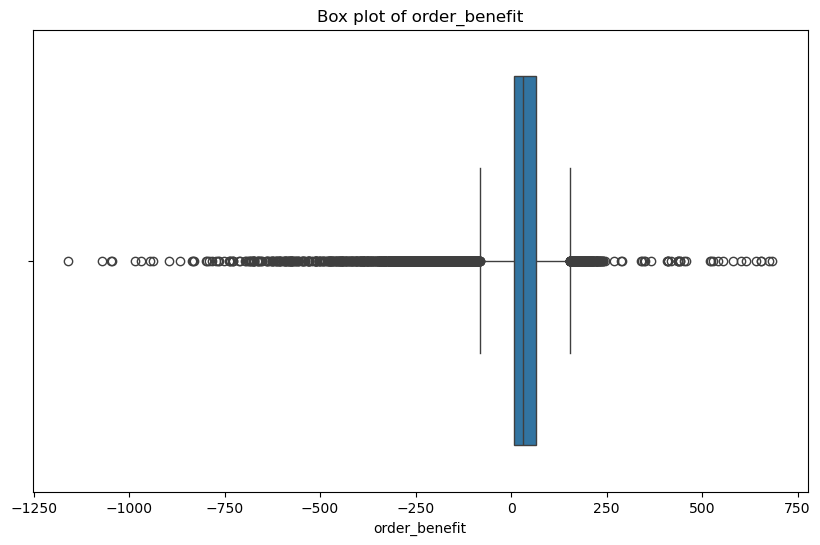

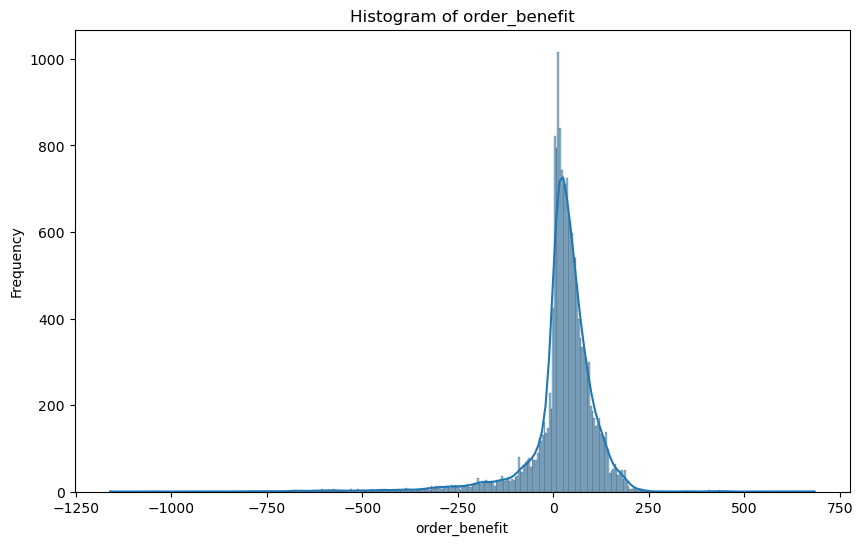

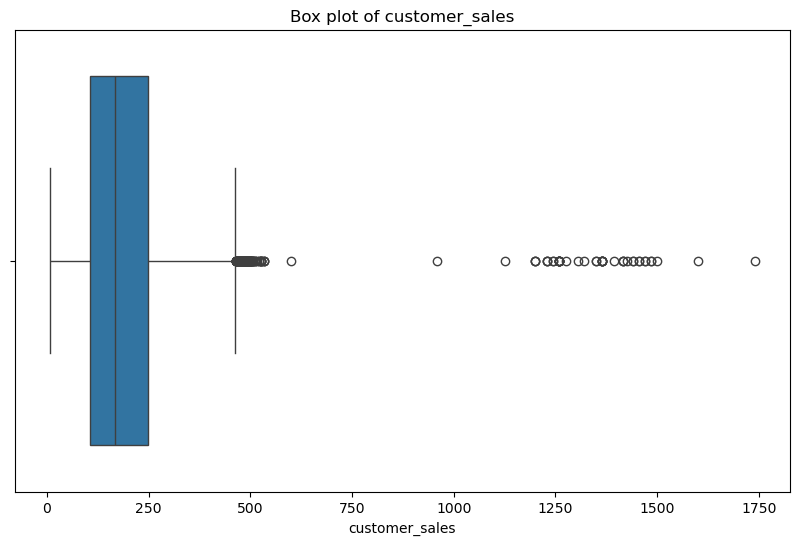

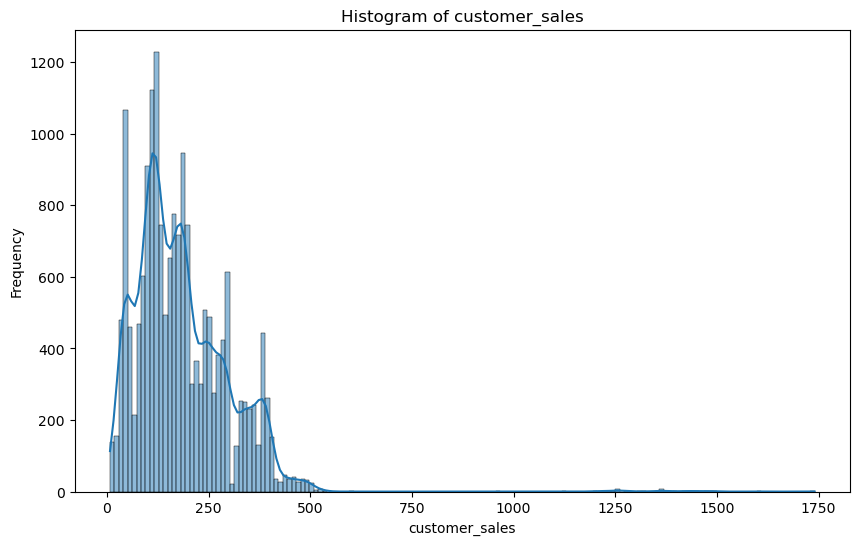

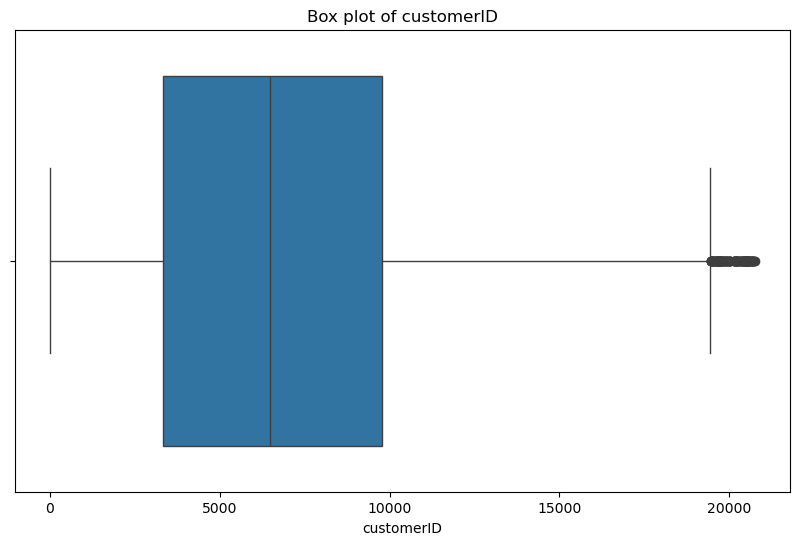

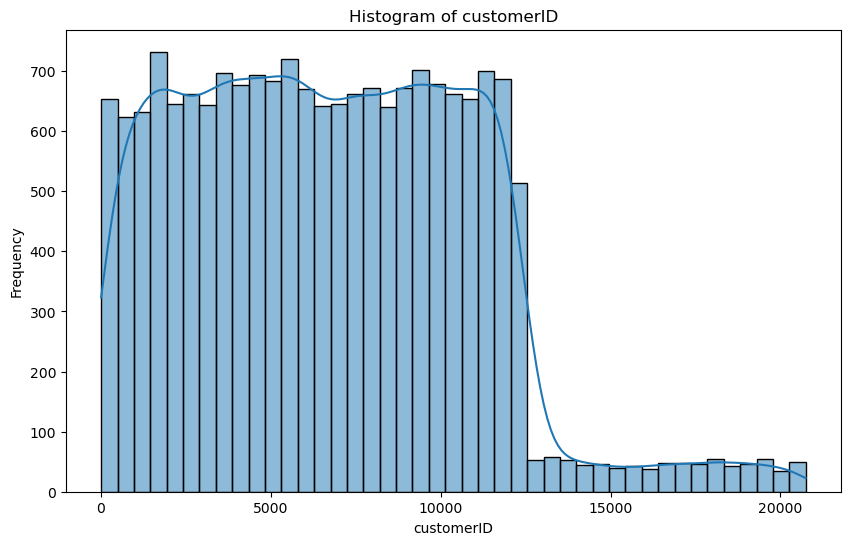

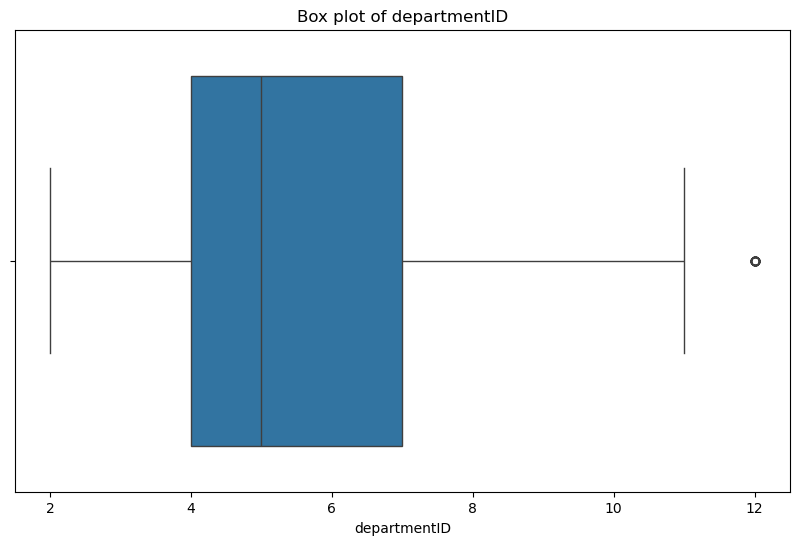

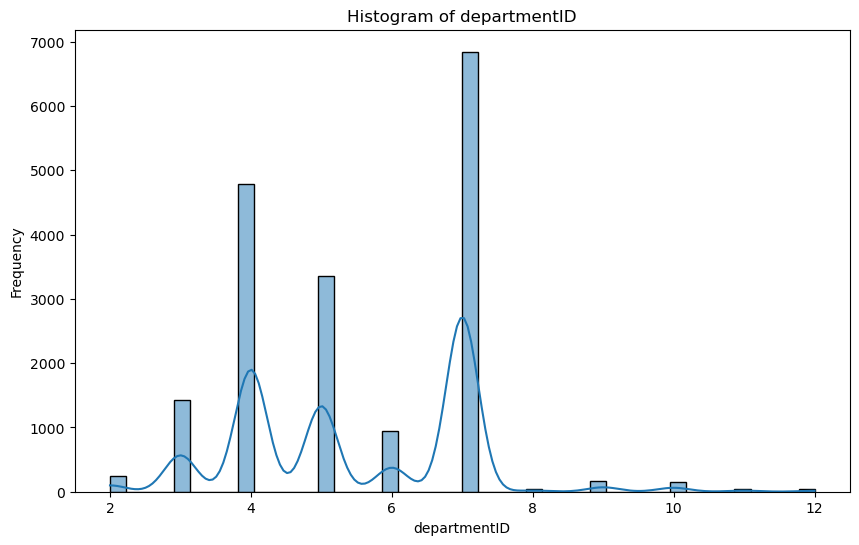

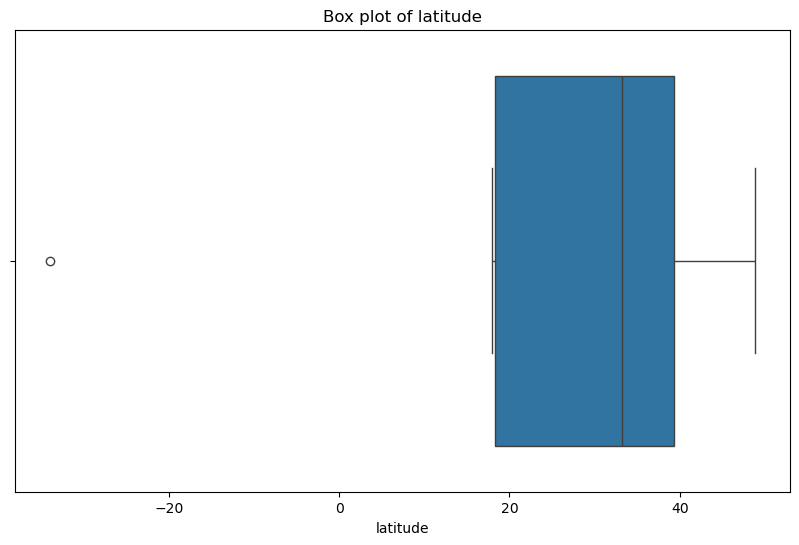

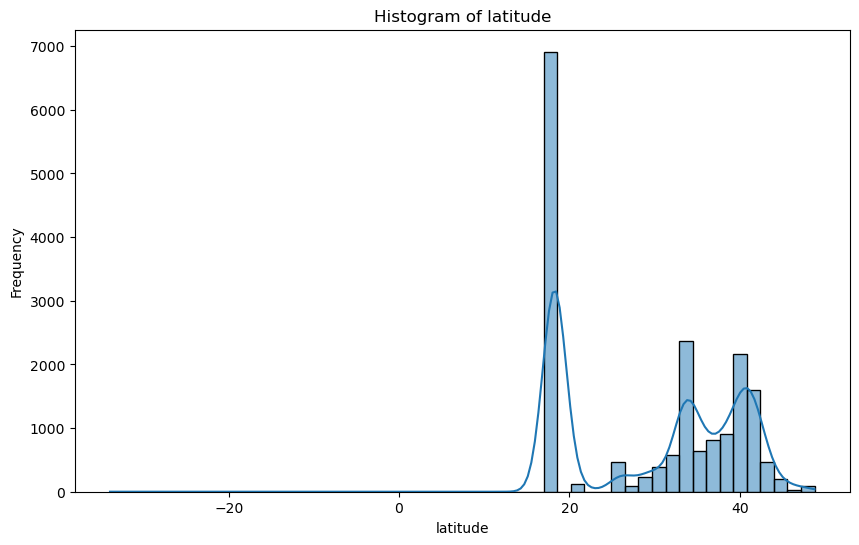

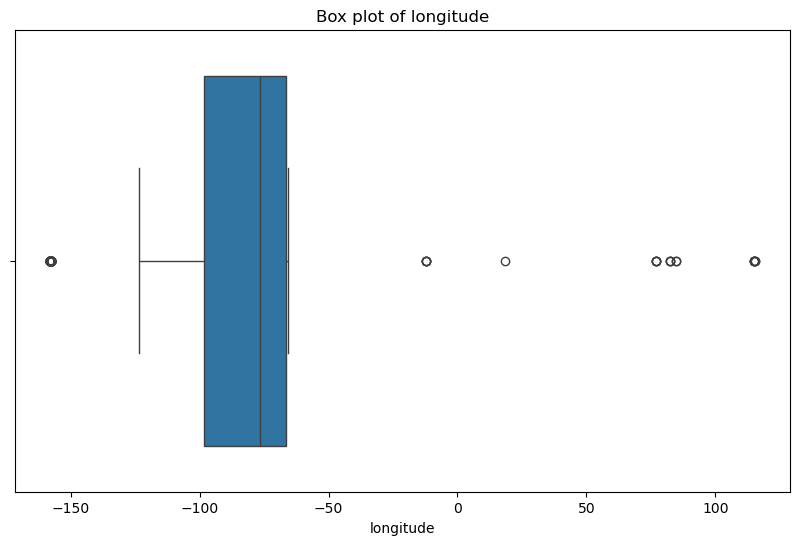

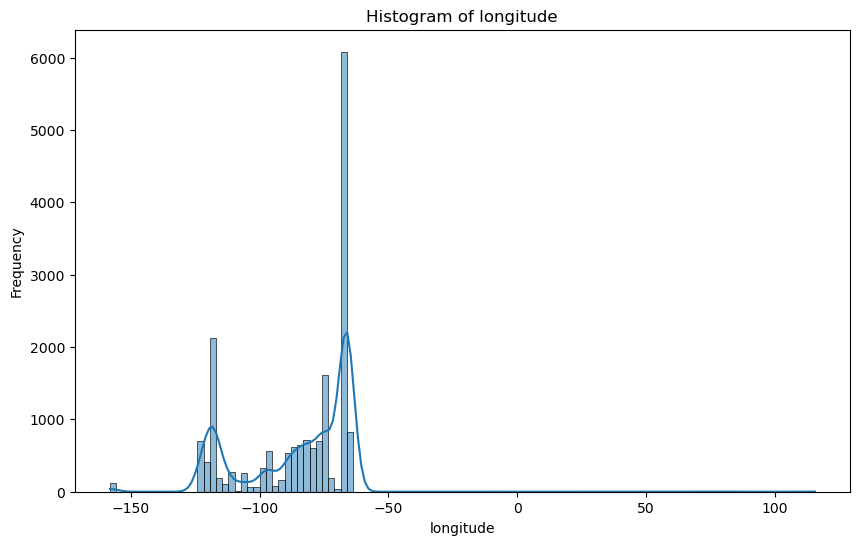

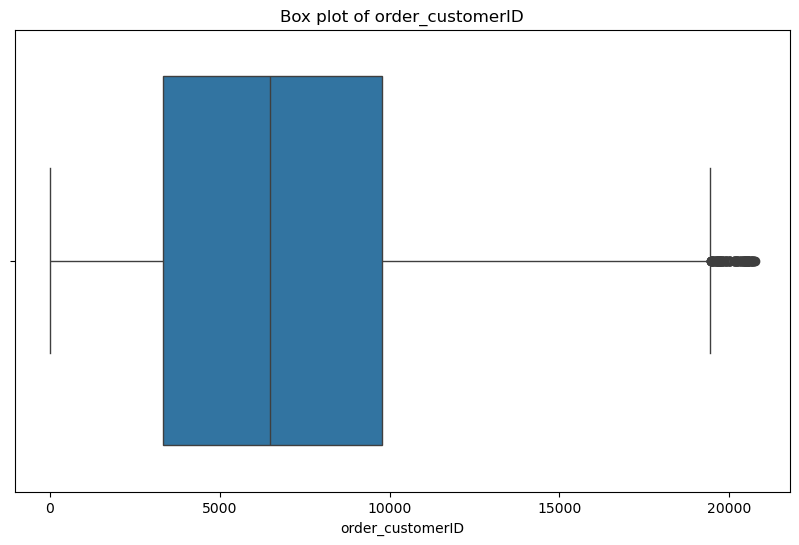

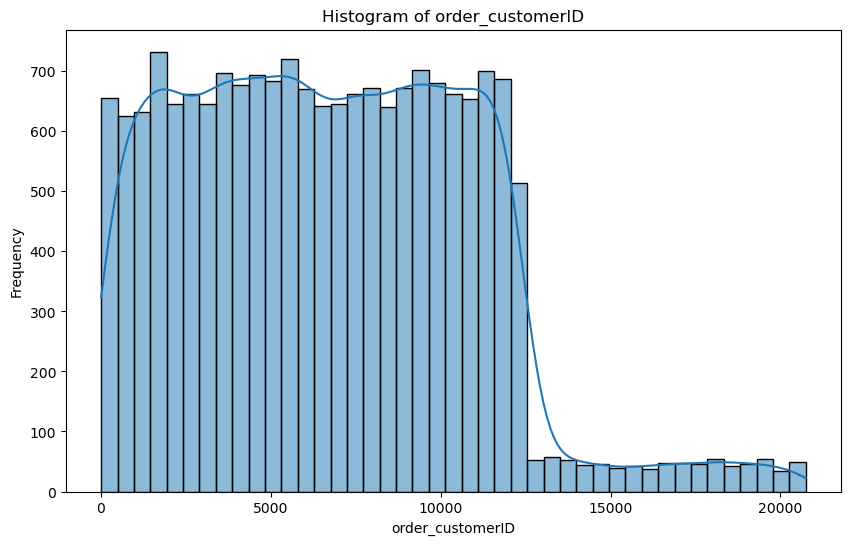

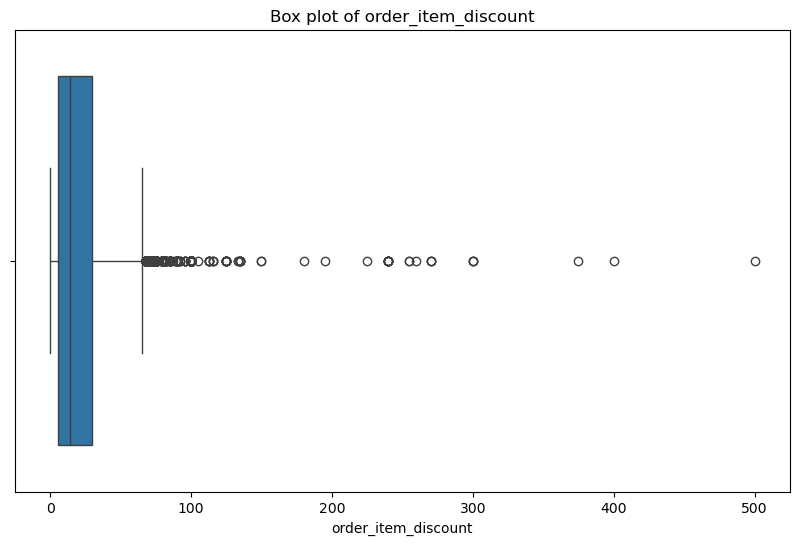

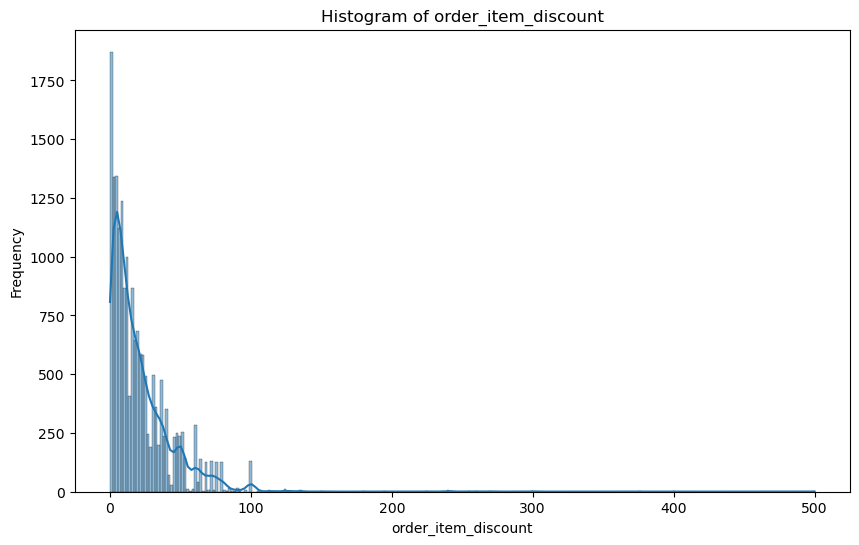

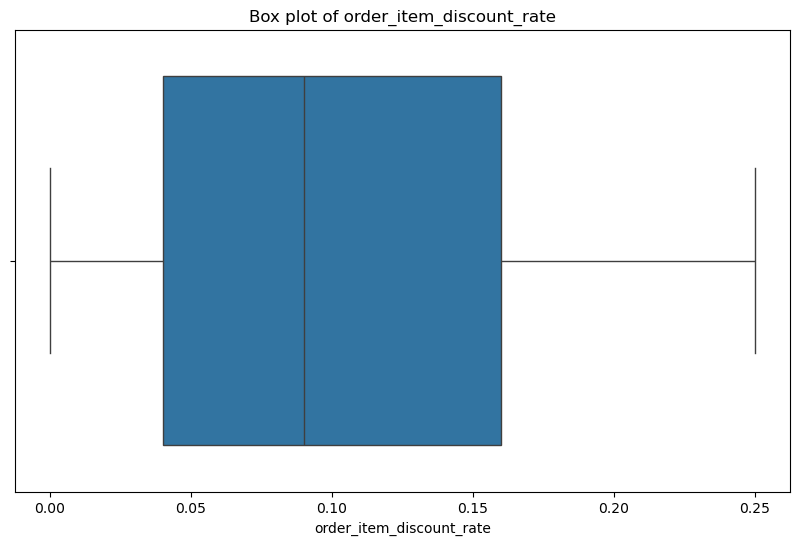

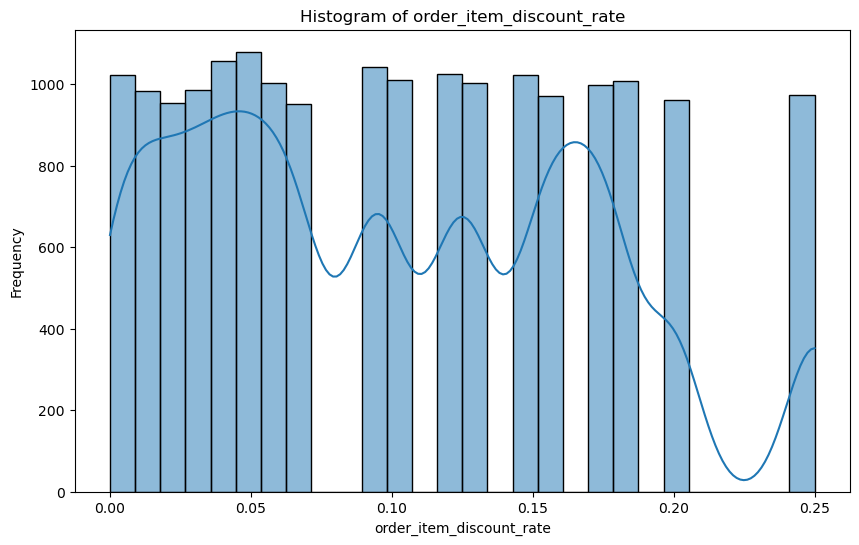

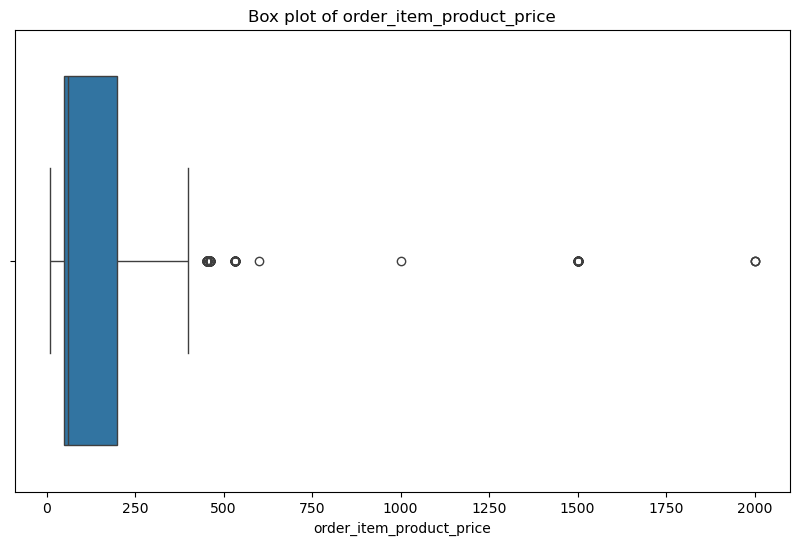

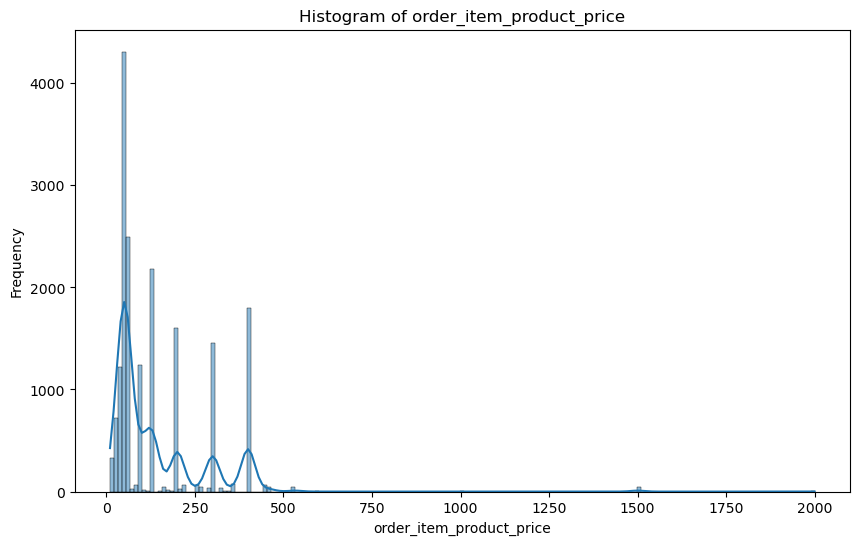

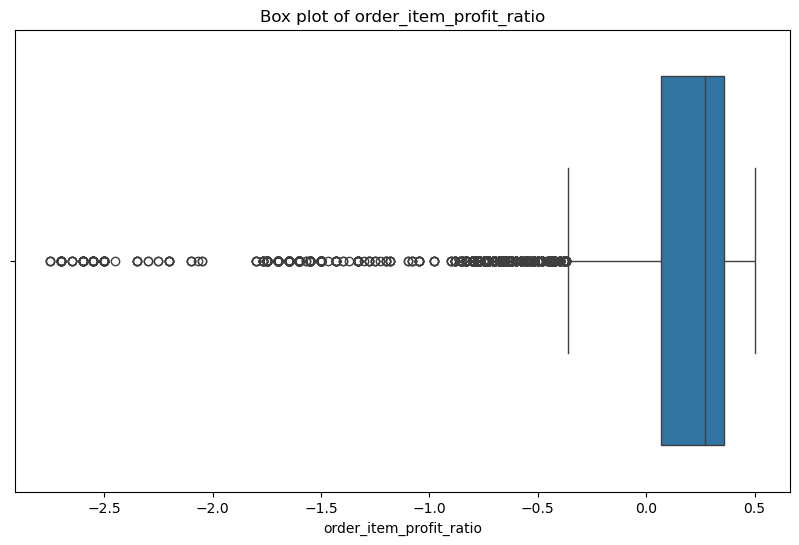

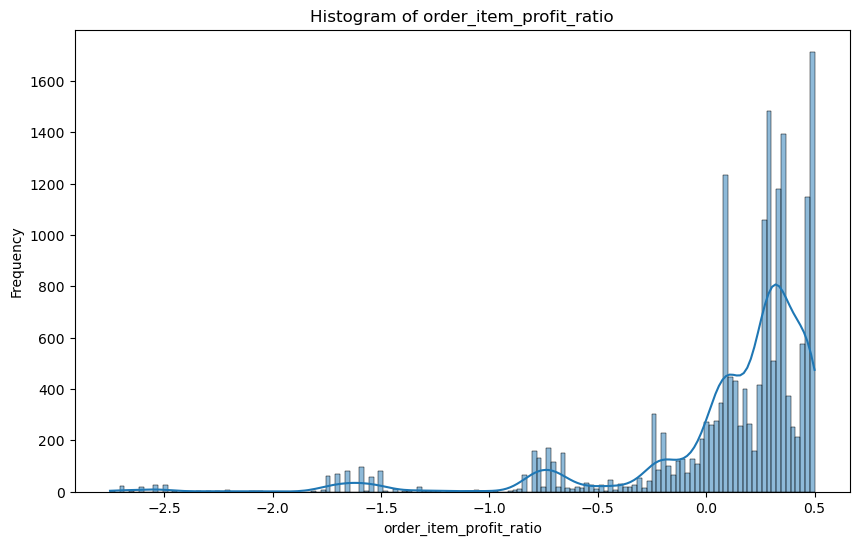

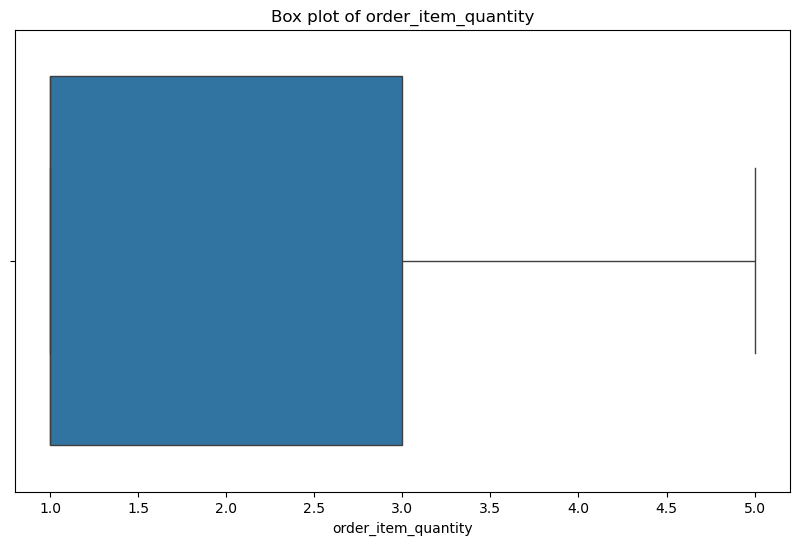

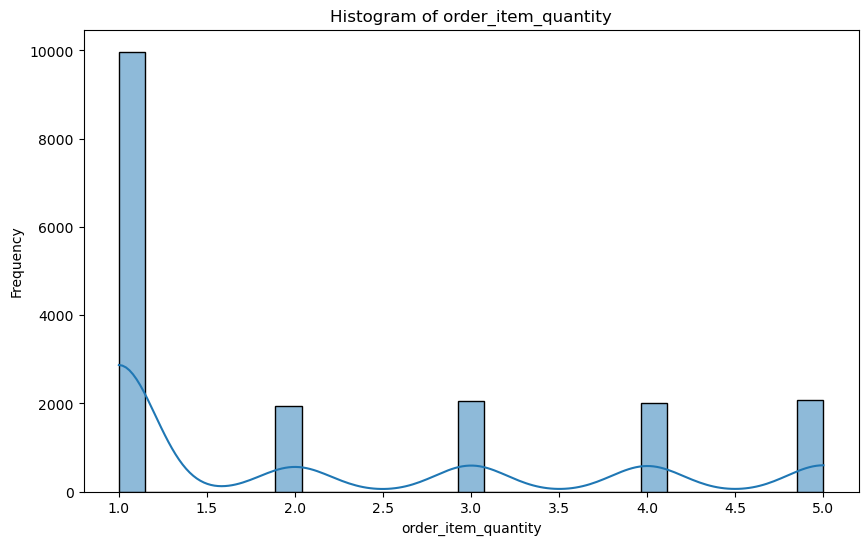

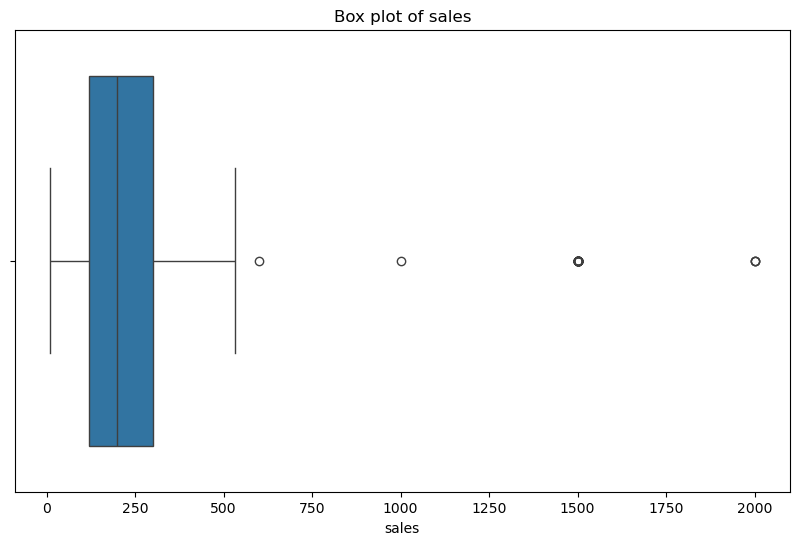

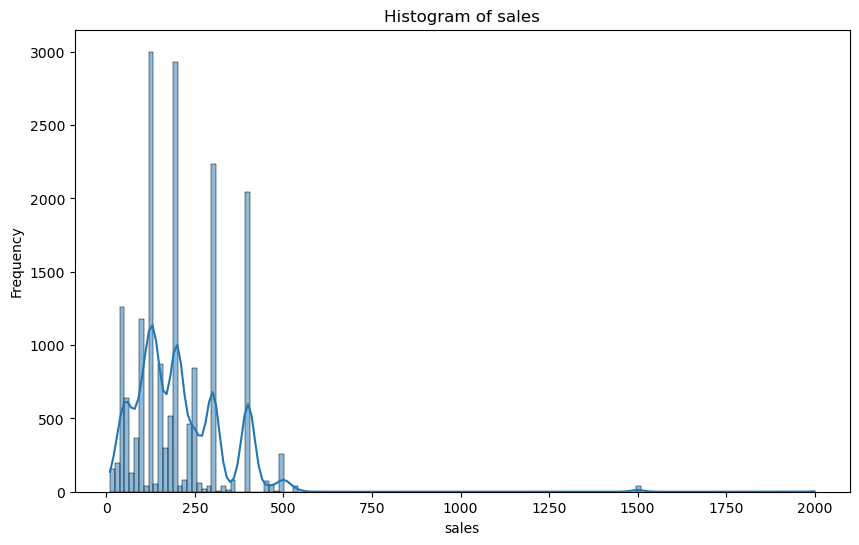

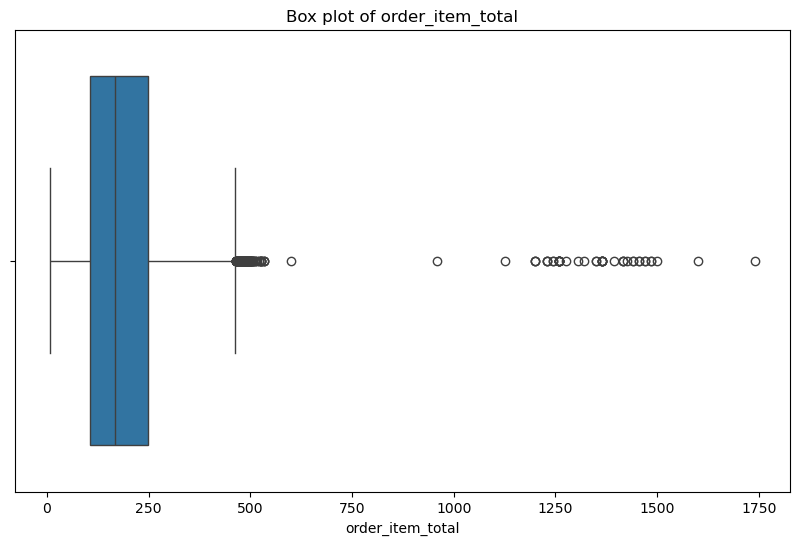

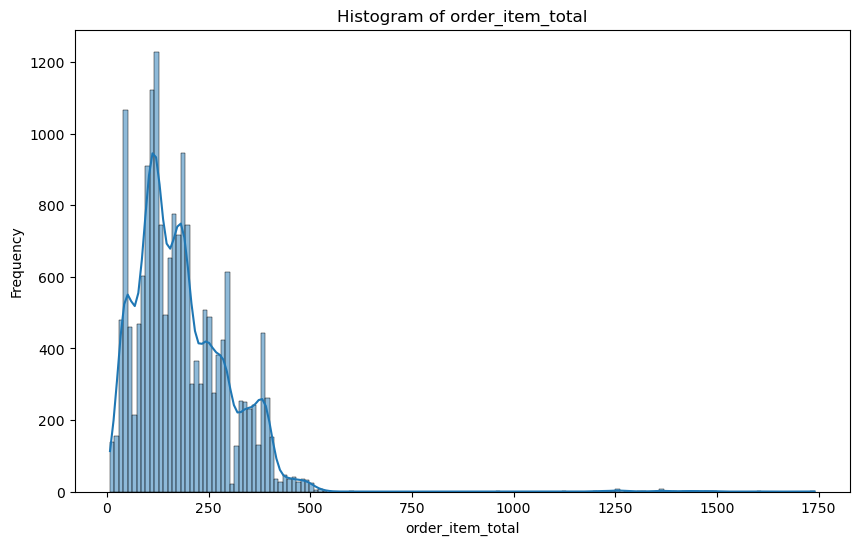

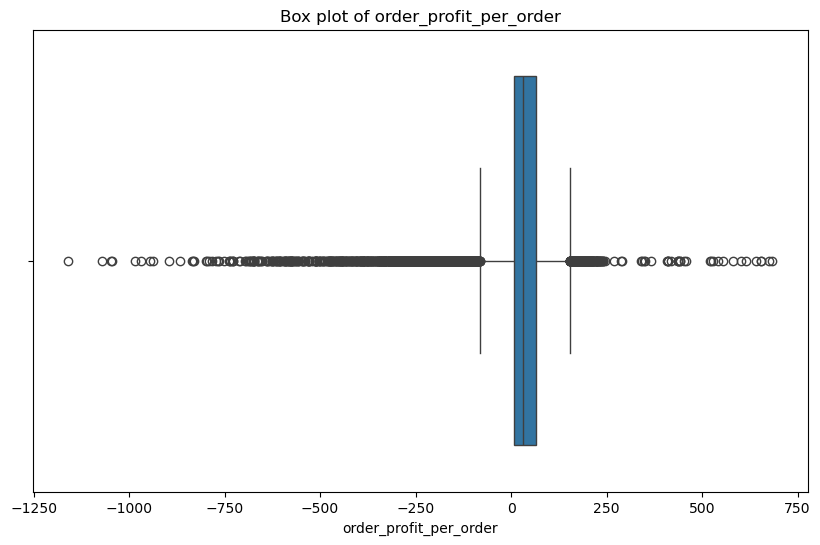

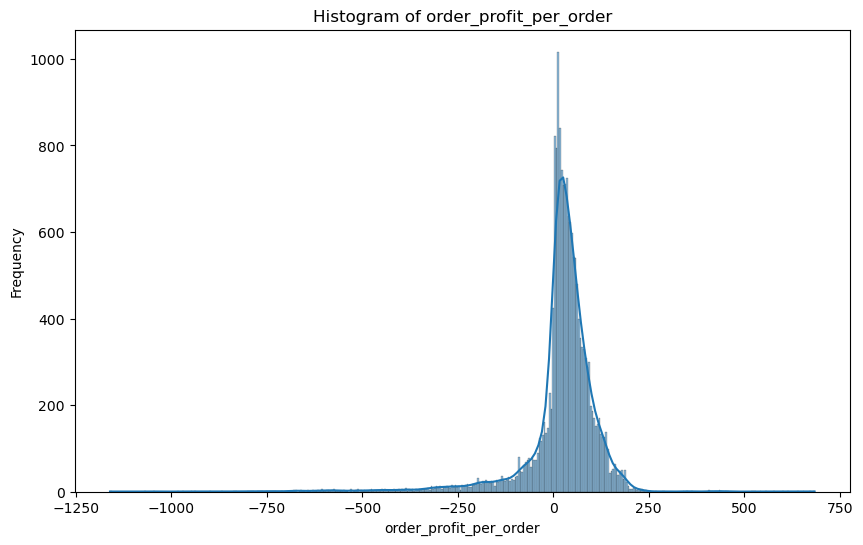

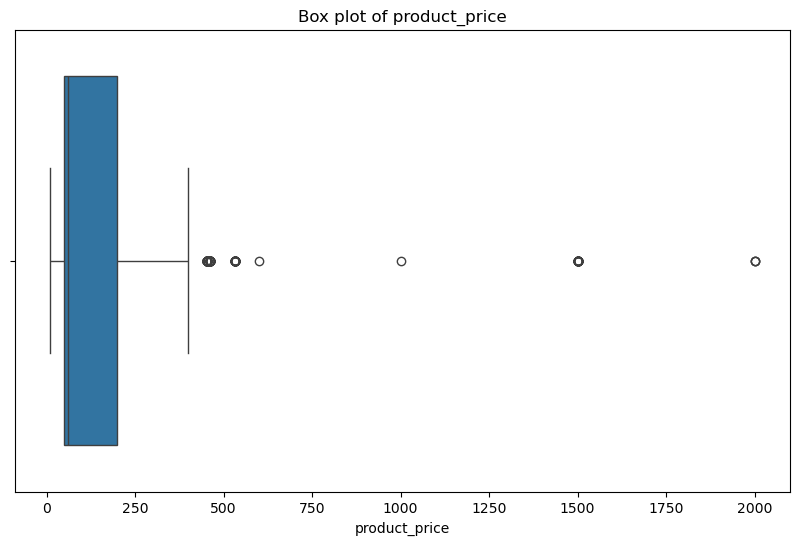

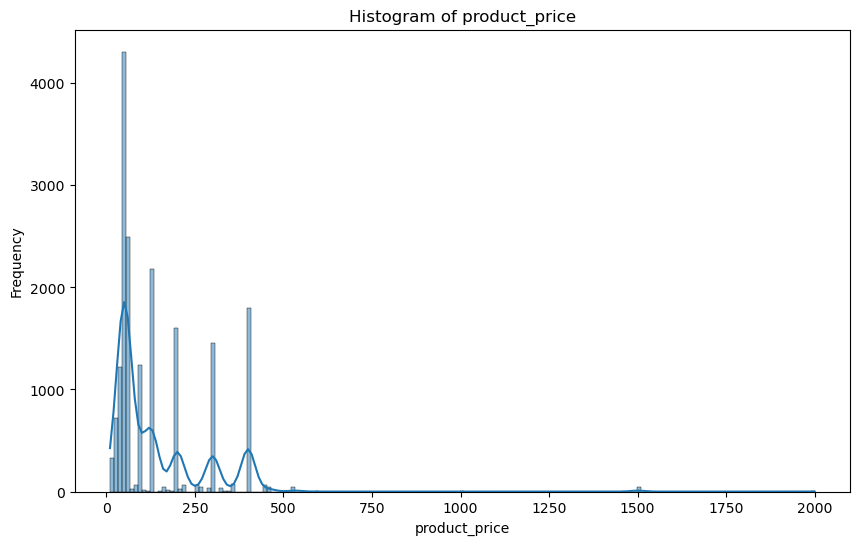

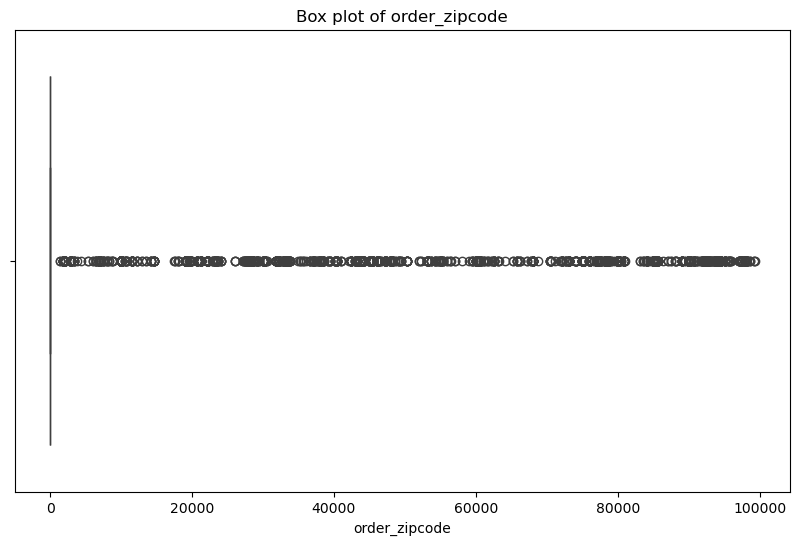

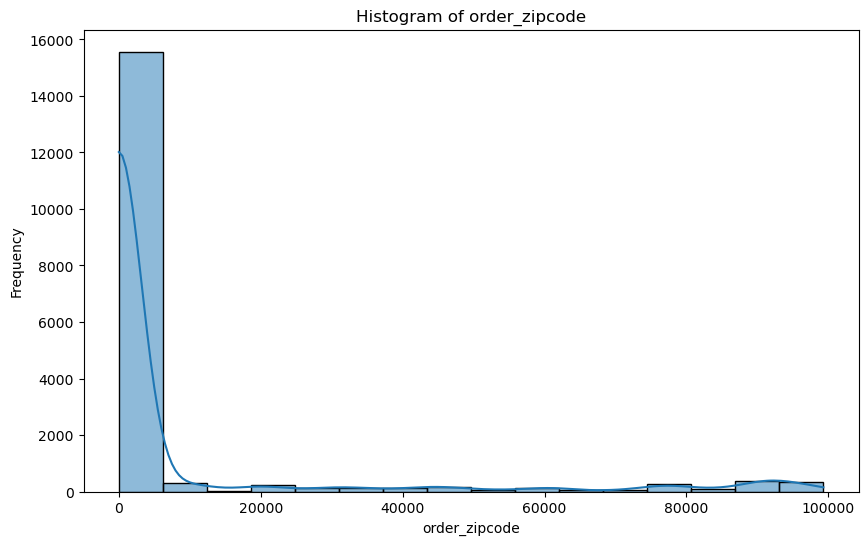

In [21]:
numerical_cols_with_outliers = ['order_benefit', 'customer_sales', 'customerID', 'departmentID', 'latitude', 'longitude', 'order_customerID', 'order_item_discount', 'order_item_discount_rate', 'order_item_product_price', 'order_item_profit_ratio', 'order_item_quantity', 'sales', 'order_item_total', 'order_profit_per_order', 'product_price', 'order_zipcode']

# Fill NaN values in 'Order Zipcode' with a placeholder for visualization
df_supply['order_zipcode'] = df_supply['order_zipcode'].fillna(-1)


for col in numerical_cols_with_outliers:
    # Box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_supply[col])
    plt.title(f'Box plot of {col}')
    plt.xlabel(col)
    plt.savefig(f'images/all/boxplot_{col}.png')
    plt.show()

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df_supply[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.savefig(f'images/all/histogram_{col}'.replace(' ', '_') + '.png') # Replace spaces for valid filenames
    plt.show()

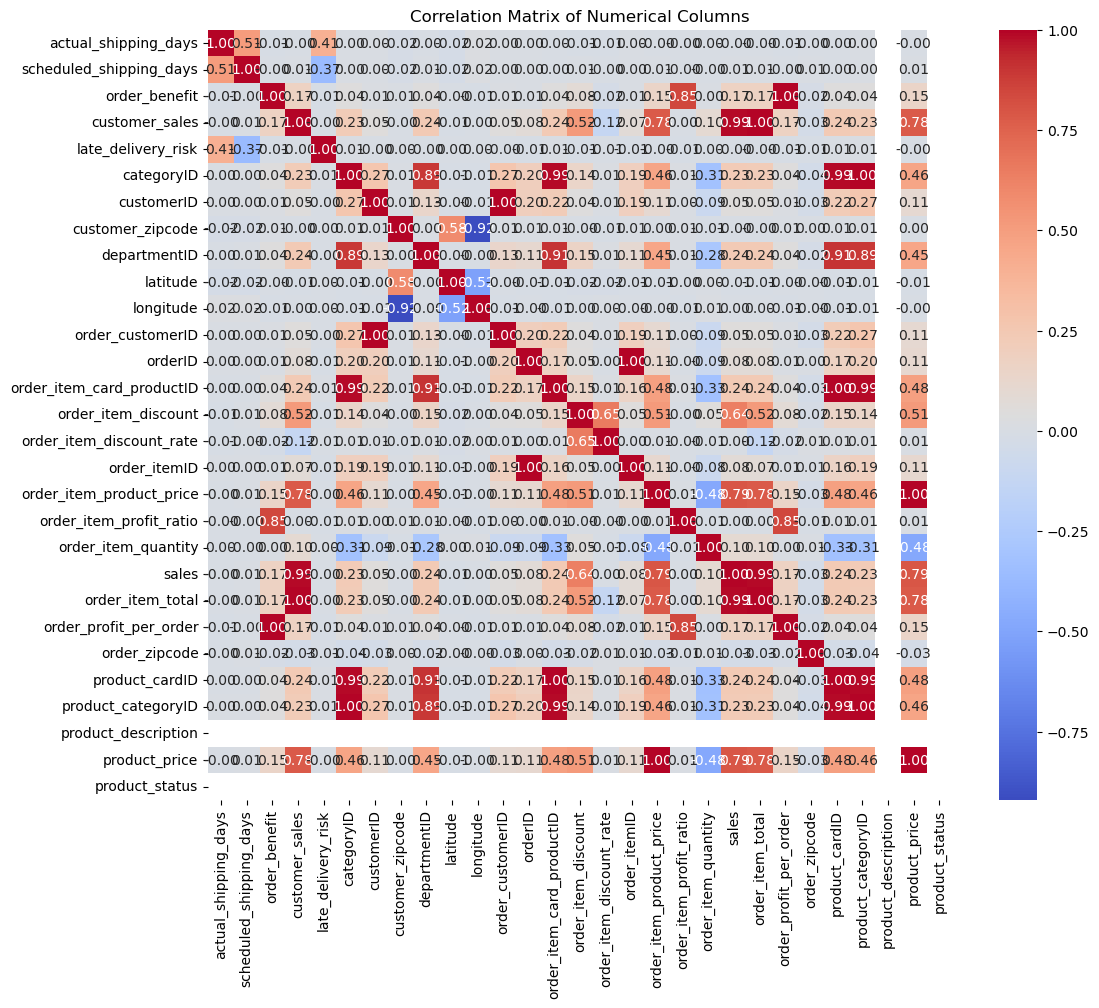

In [22]:
# Explore relationships between numerical columns using a correlation matrix
numerical_cols = df_supply.select_dtypes(include=np.number).columns
correlation_matrix = df_supply[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.savefig('images/all/correlation_matrix.png')
plt.show()

# Explore Relationships between Categorical Features and Late Delivery Risk

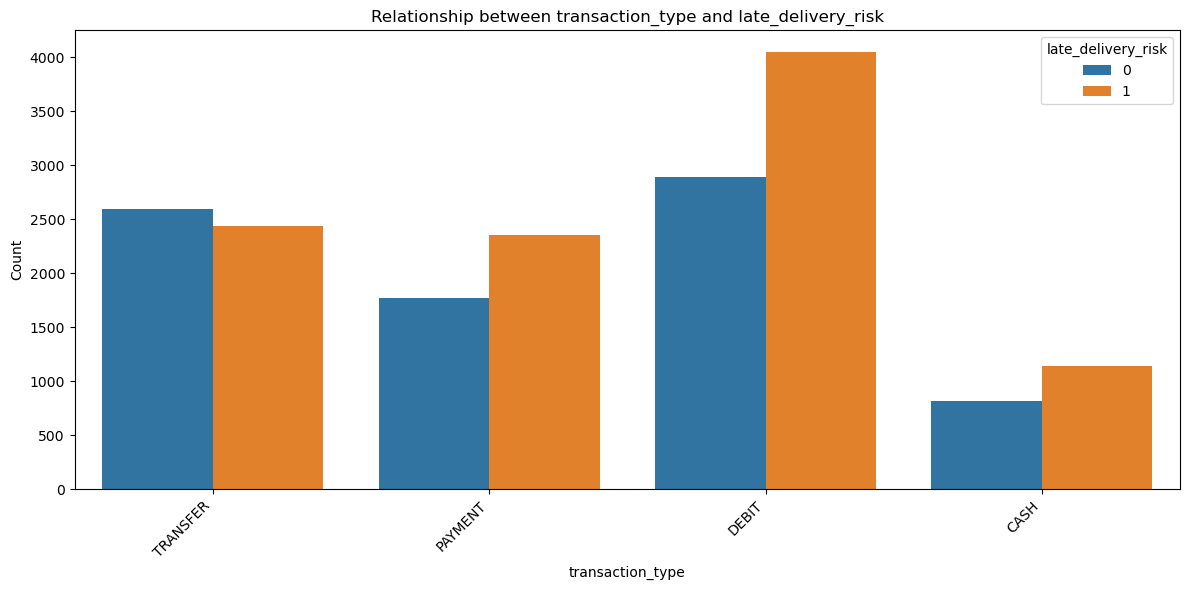

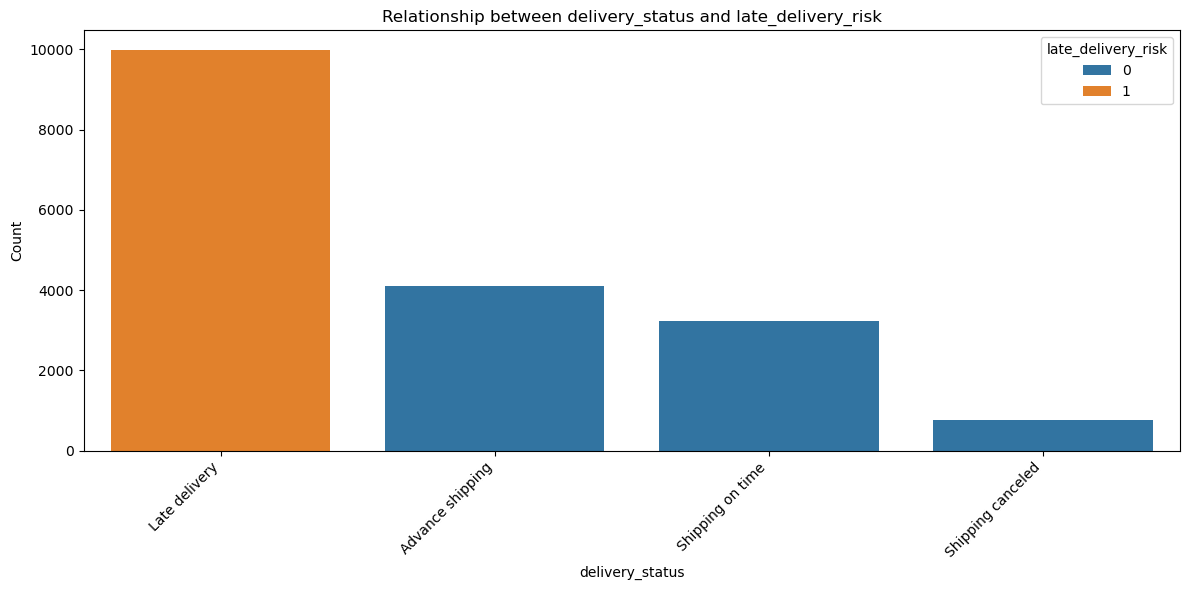

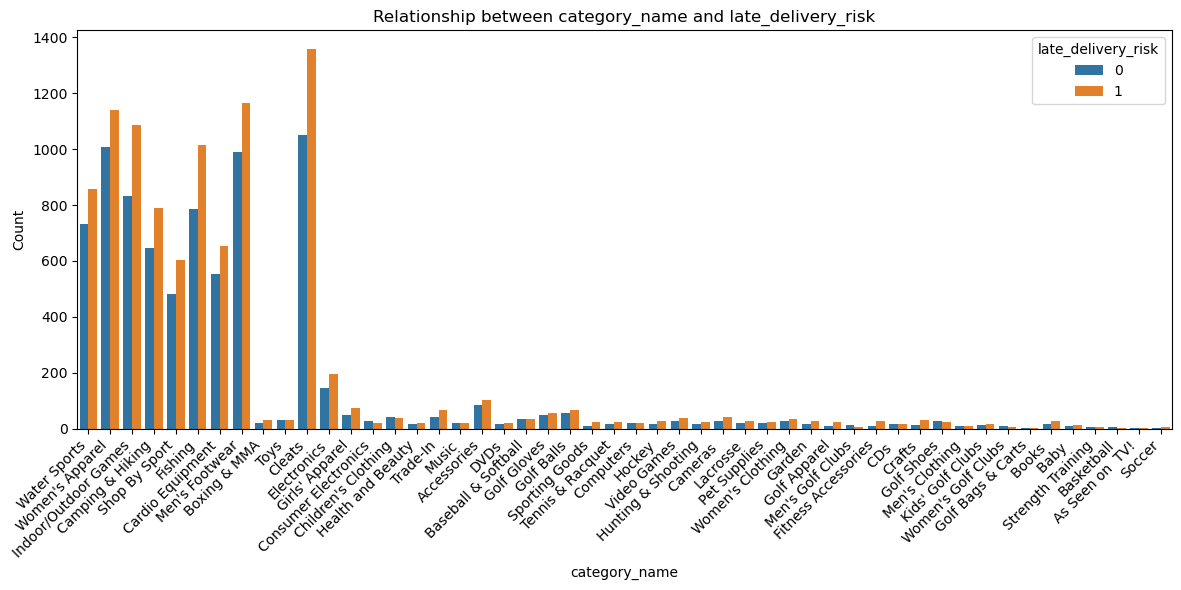

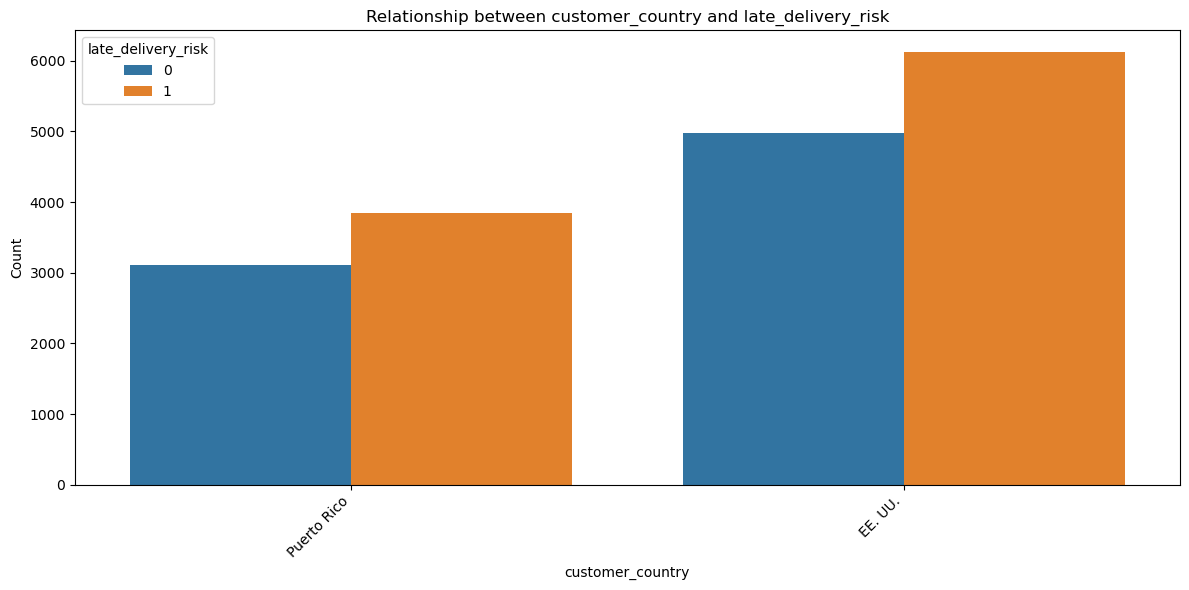

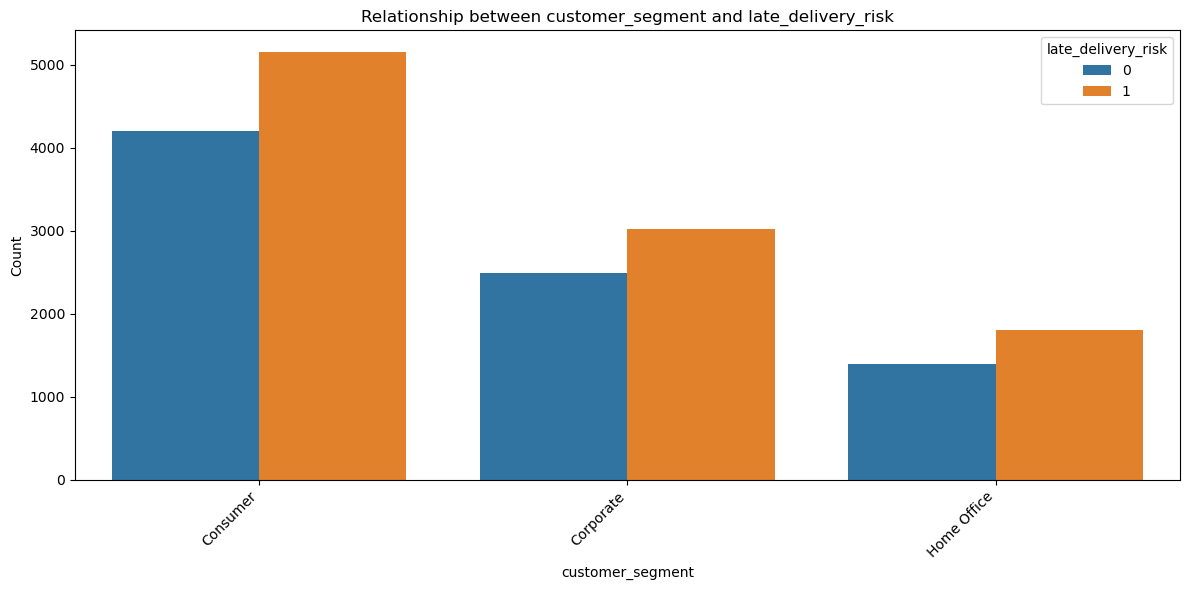

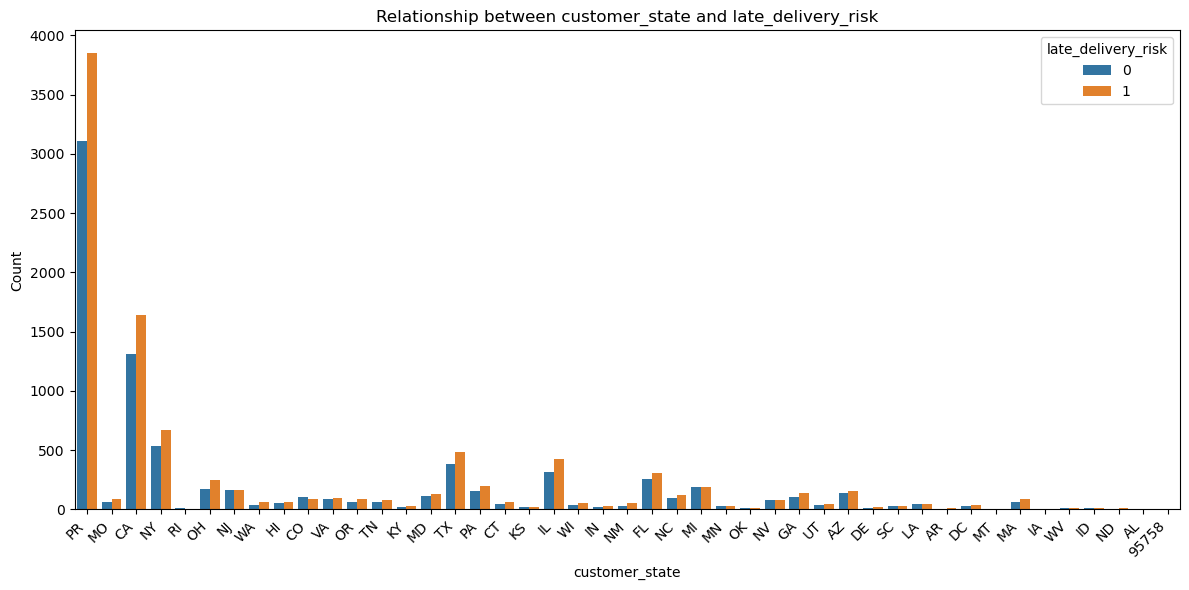

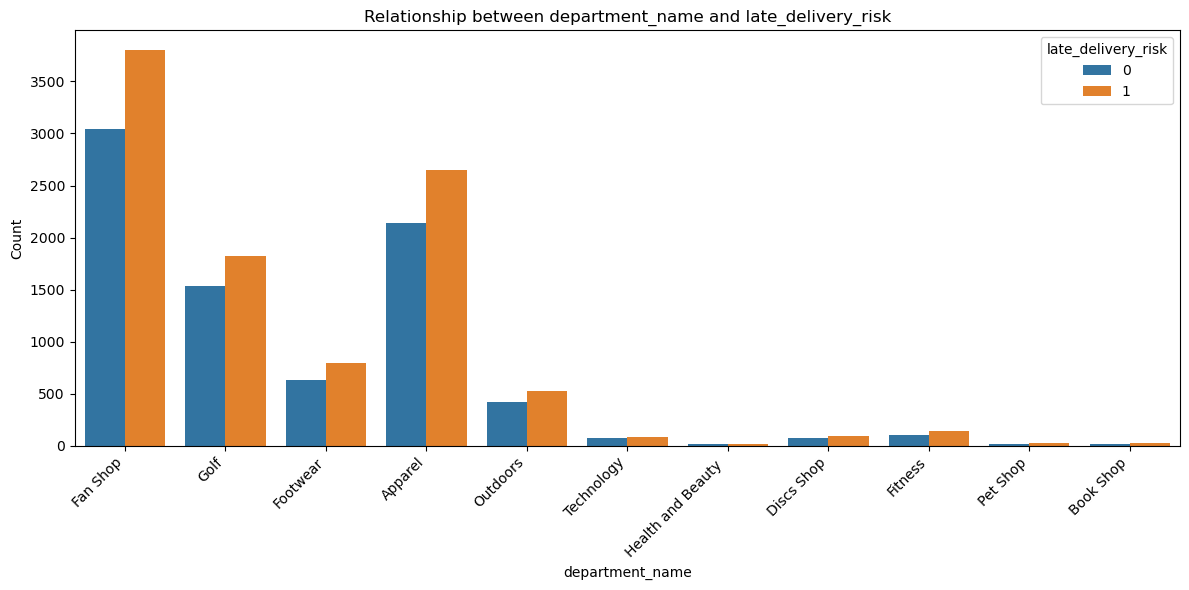

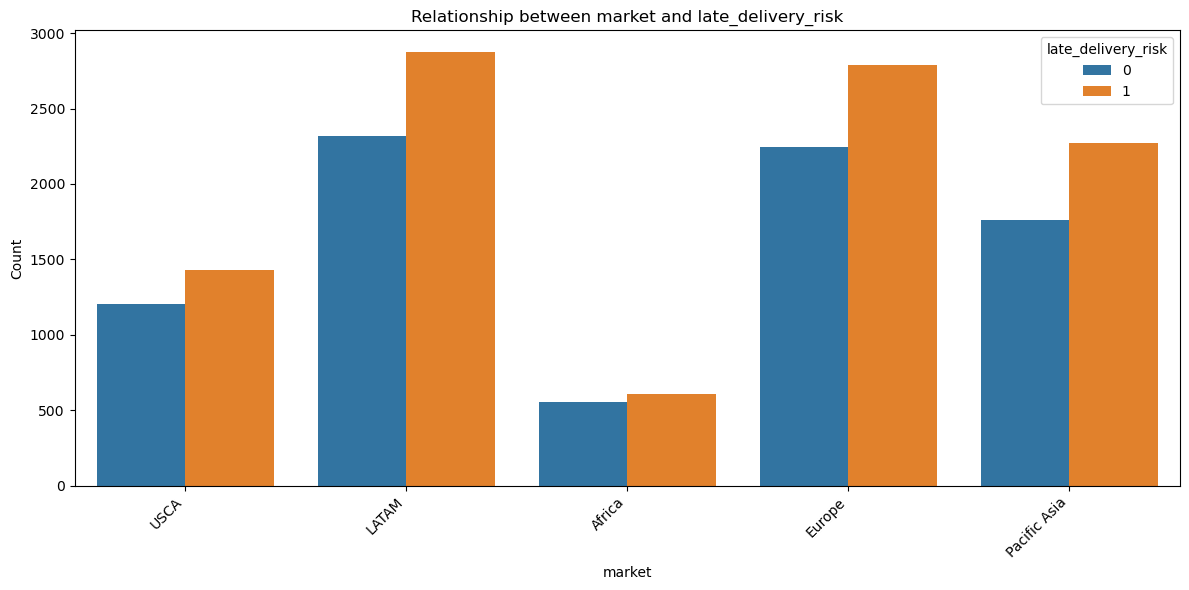

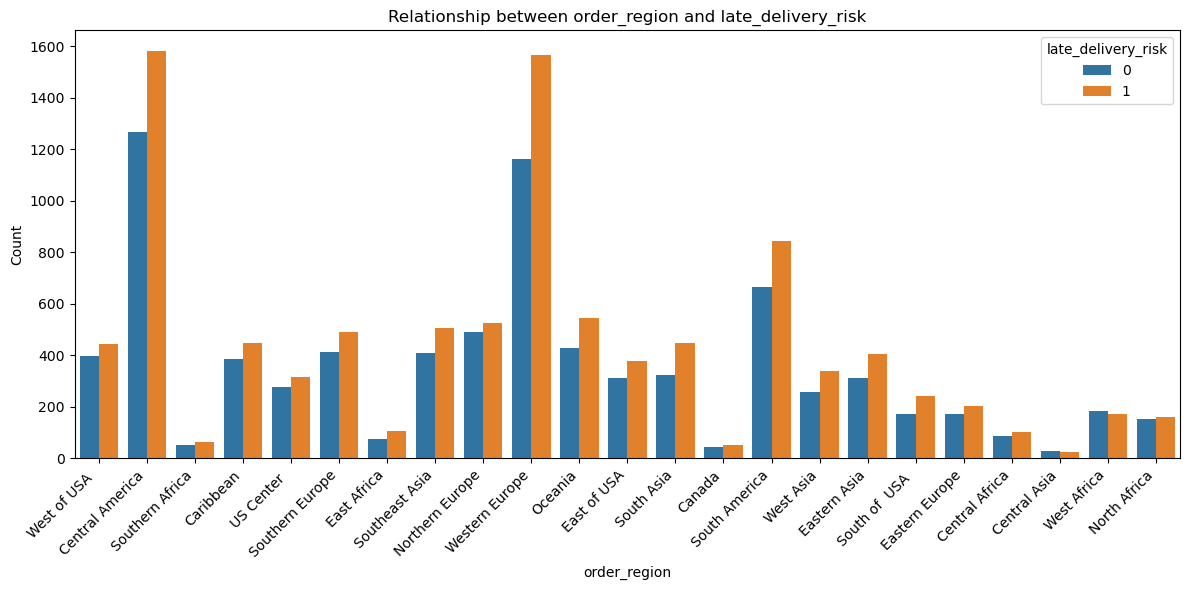

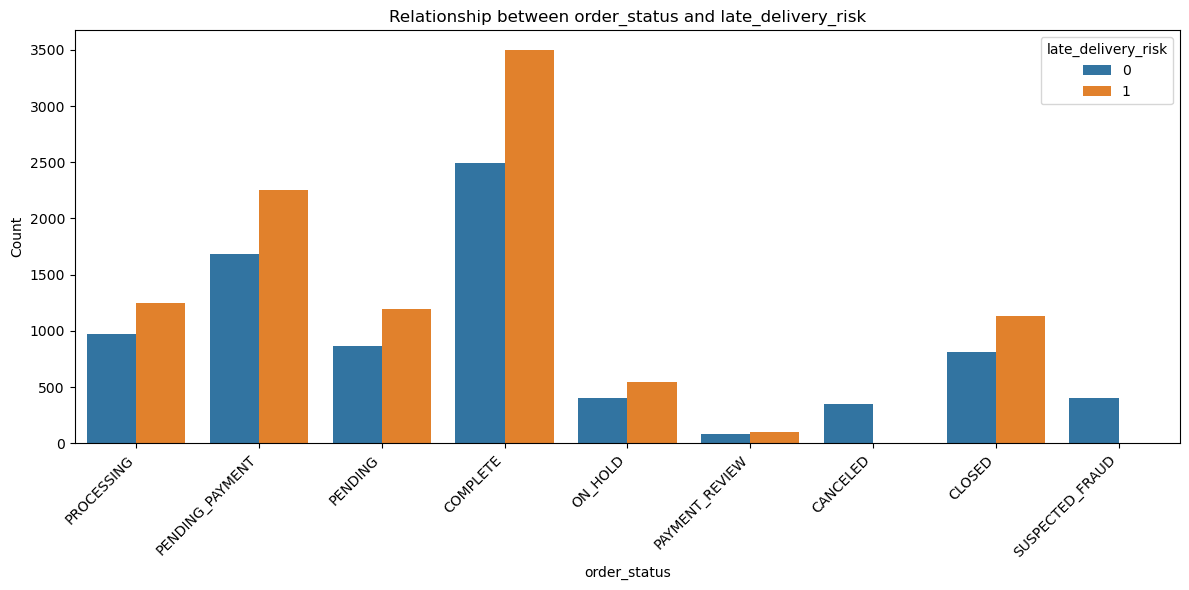

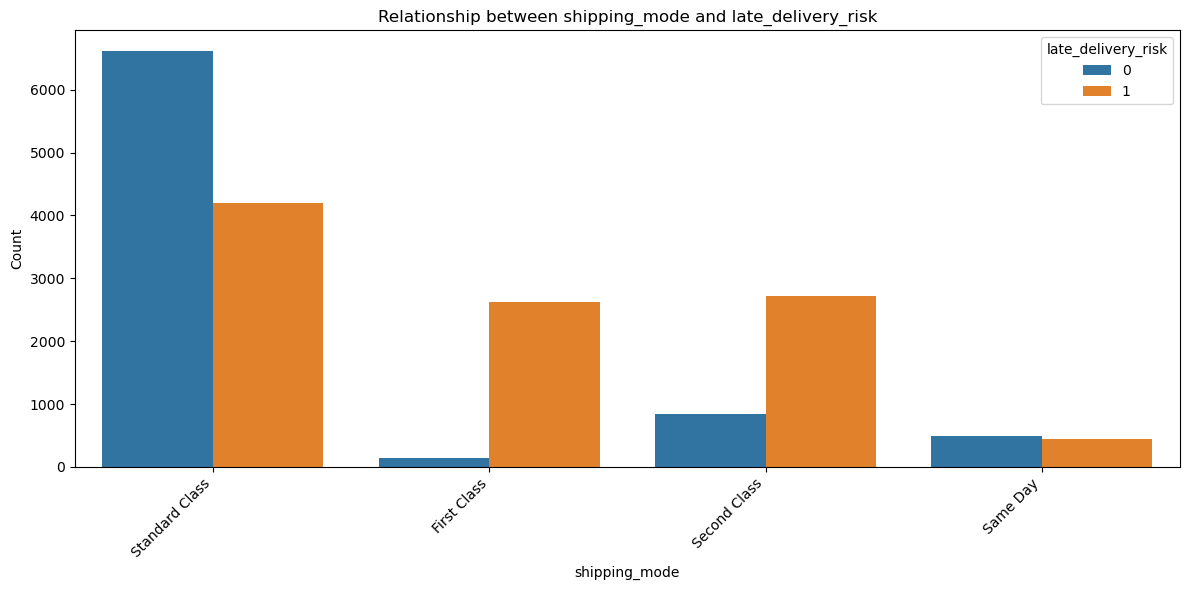

In [23]:
categorical_cols = df_supply.select_dtypes(include='object').columns
# Dropping columns that are not useful for exploring relationships with the target variable
cols_to_drop = ['late_delivery_risk', 'customer_city', 'customer_fname',
                  'customer_lname', 'customer_street', 'customer_email',
                  'customer_password', 'product_description', 'product_image',
                  'product_name', 'shipping_date', 'order_city', 'order_country', 'order_date', 'order_state']
categorical_cols = categorical_cols.drop(cols_to_drop, errors='ignore')

target_variable = 'late_delivery_risk'

for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_supply, x=col, hue=target_variable)
    plt.title(f'Relationship between {col} and {target_variable}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'images/all/countplot_{col}_vs_{target_variable}.png')
    plt.show()

## Detailed Distribution Analysis

## In-depth Relationship Analysis
Exploring relationships between numerical and categorical features.

## Summary of In-depth Relationship Analysis

Based on the box plots visualizing the relationships between numerical features, categorical features, and late delivery risk:

*   **Actual Shipping Days vs. Late Delivery Risk by Shipping Mode:** The box plot shows that for all shipping modes, orders with a late delivery risk tend to have a higher number of actual shipping days compared to those without late delivery risk. This difference is more pronounced for some shipping modes than others.
*   **Customer Sales vs. Late Delivery Risk by Customer Segment:** The box plot suggests that there might be some differences in customer sales distributions between customers with and without late delivery risk, and this relationship could vary across different customer segments (Consumer, Corporate, Home Office). However, the differences might not be very strong.
*   **Order Profit Per Order vs. Late Delivery Risk by Market:** The box plot indicates that the distribution of order profit per order can differ between orders with and without late delivery risk, and this can vary significantly depending on the market. Some markets might have a wider range of profits or different median profit values associated with late deliveries.

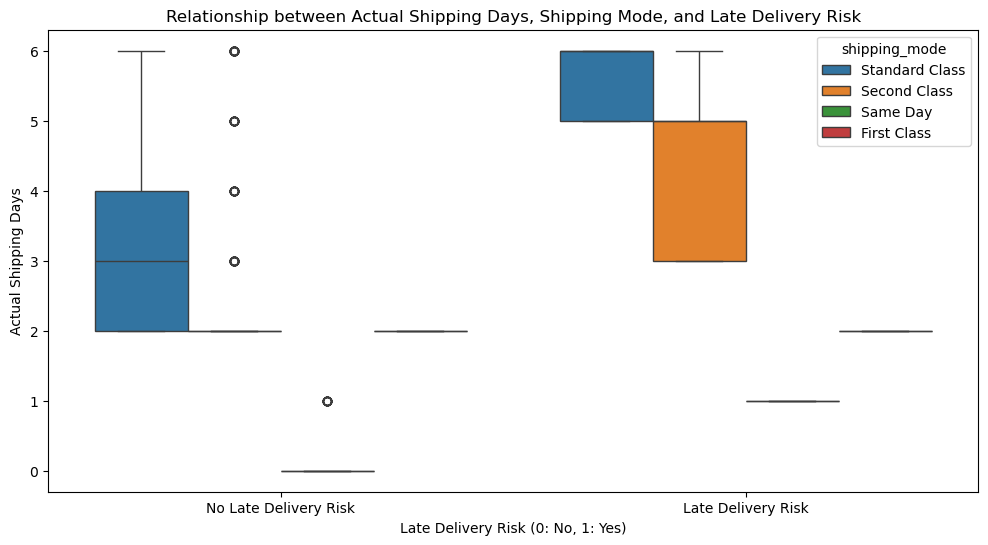

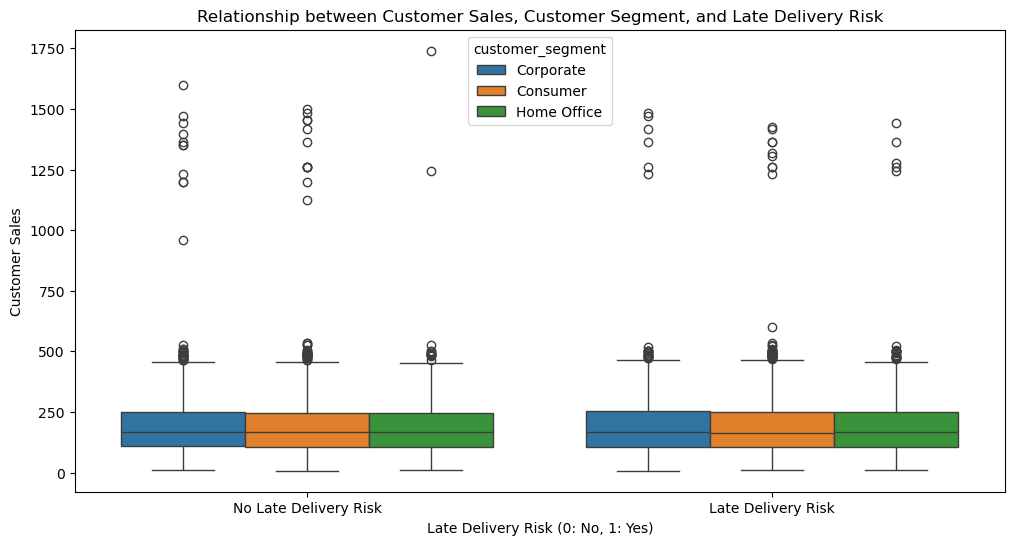

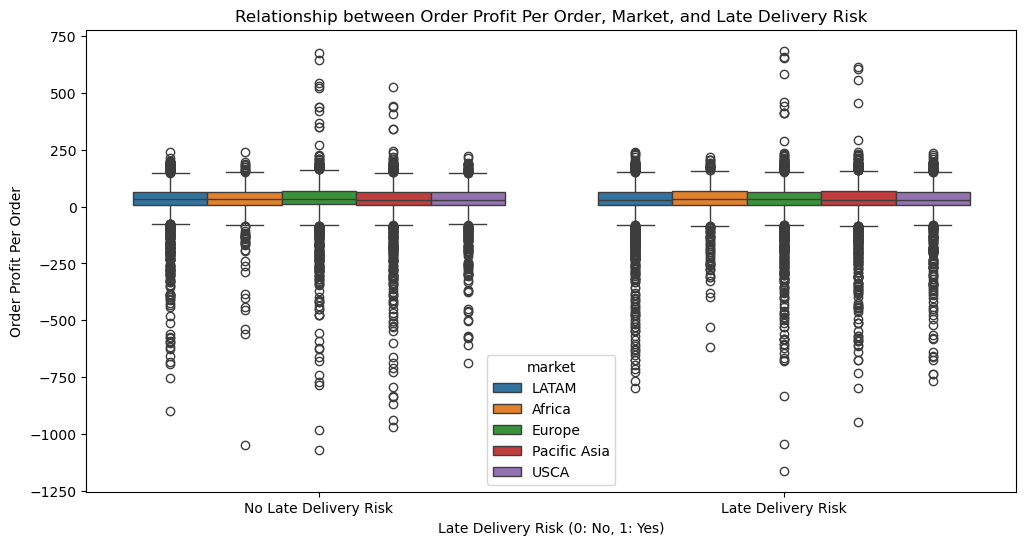

In [24]:
# Explore relationship between a numerical feature and the target variable, grouped by a categorical feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_supply, x='late_delivery_risk', y='actual_shipping_days', hue='shipping_mode')
plt.title('Relationship between Actual Shipping Days, Shipping Mode, and Late Delivery Risk')
plt.xlabel('Late Delivery Risk (0: No, 1: Yes)')
plt.ylabel('Actual Shipping Days')
plt.xticks([0, 1], ['No Late Delivery Risk', 'Late Delivery Risk'])
plt.savefig('images/all/boxplot_actual_shipping_days_vs_late_delivery_risk_by_shipping_mode.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_supply, x='late_delivery_risk', y='customer_sales', hue='customer_segment')
plt.title('Relationship between Customer Sales, Customer Segment, and Late Delivery Risk')
plt.xlabel('Late Delivery Risk (0: No, 1: Yes)')
plt.ylabel('Customer Sales')
plt.xticks([0, 1], ['No Late Delivery Risk', 'Late Delivery Risk'])
plt.savefig('images/all/boxplot_customer_sales_vs_late_delivery_risk_by_customer_segment.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_supply, x='late_delivery_risk', y='order_profit_per_order', hue='market')
plt.title('Relationship between Order Profit Per Order, Market, and Late Delivery Risk')
plt.xlabel('Late Delivery Risk (0: No, 1: Yes)')
plt.ylabel('Order Profit Per Order')
plt.xticks([0, 1], ['No Late Delivery Risk', 'Late Delivery Risk'])
plt.savefig('images/all/boxplot_order_profit_per_order_vs_late_delivery_risk_by_market.png')
plt.show()

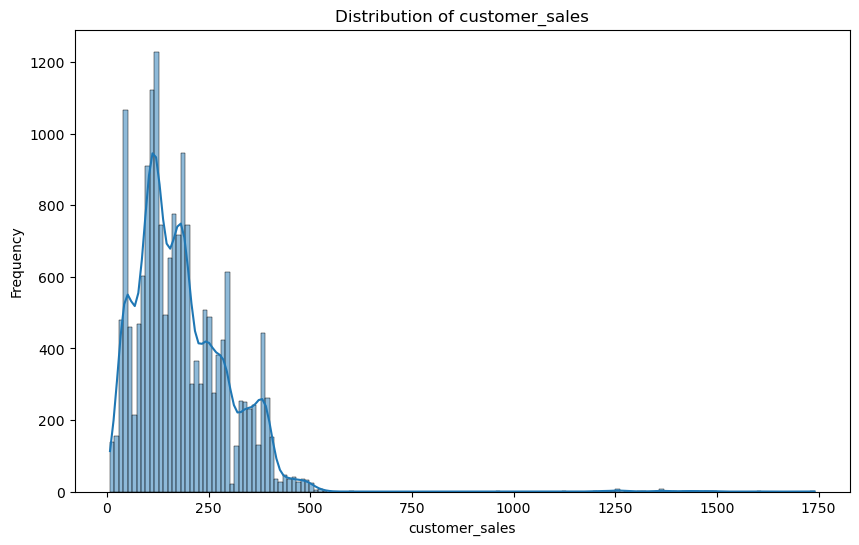

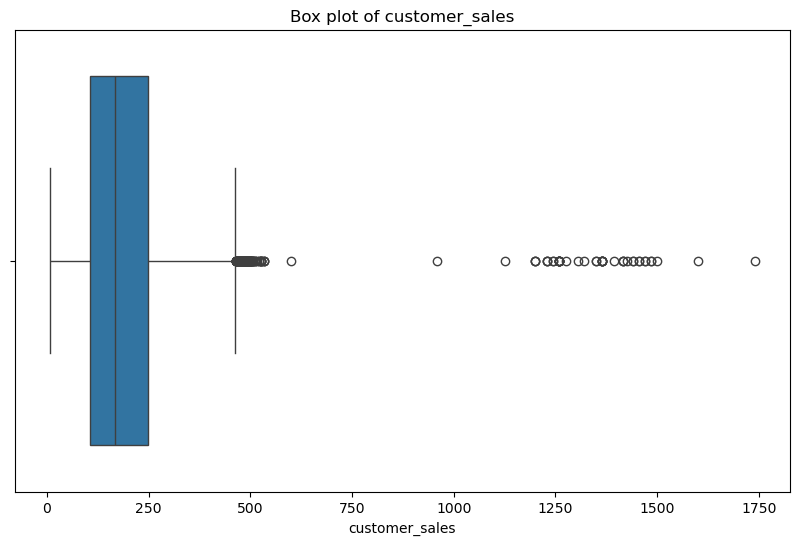

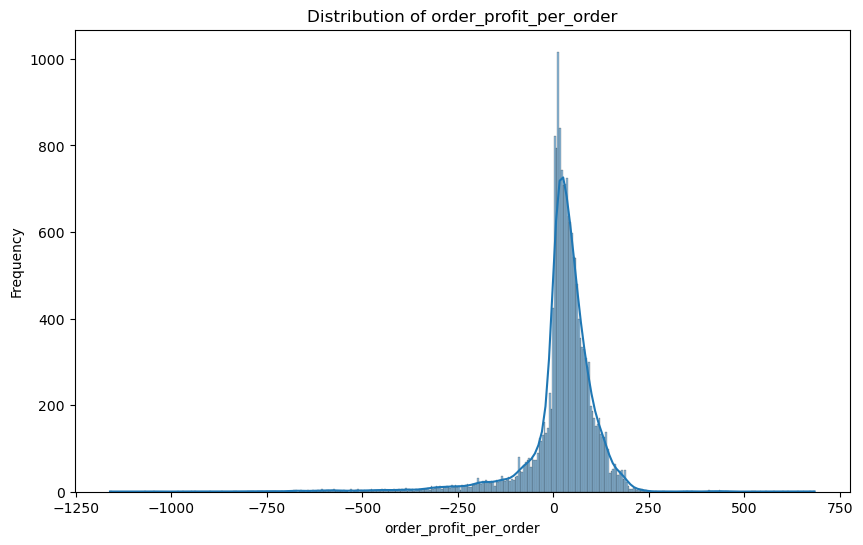

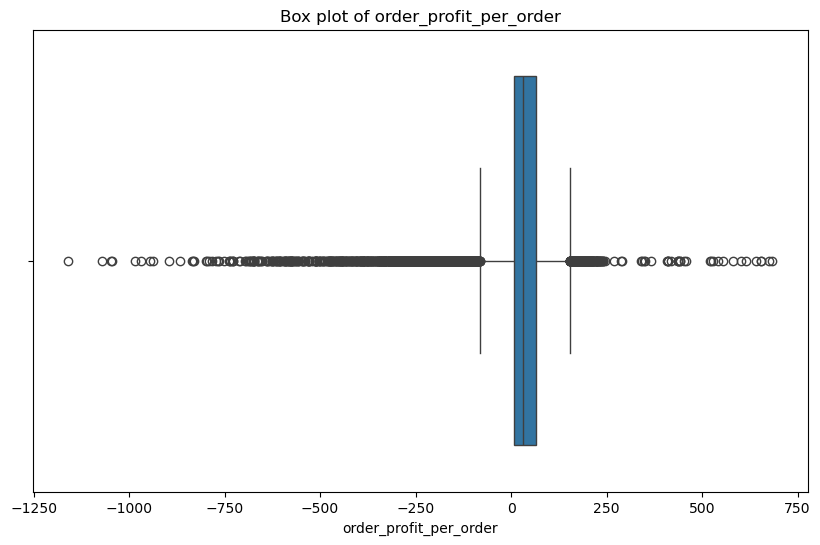

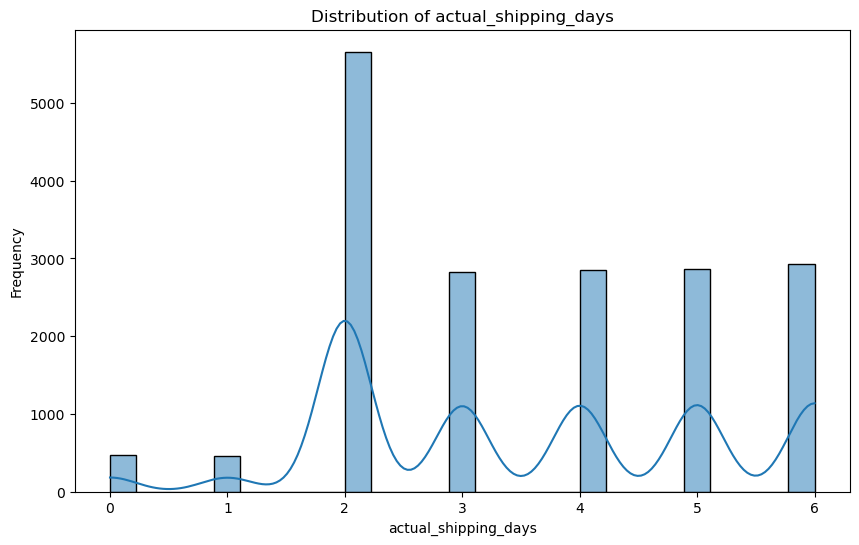

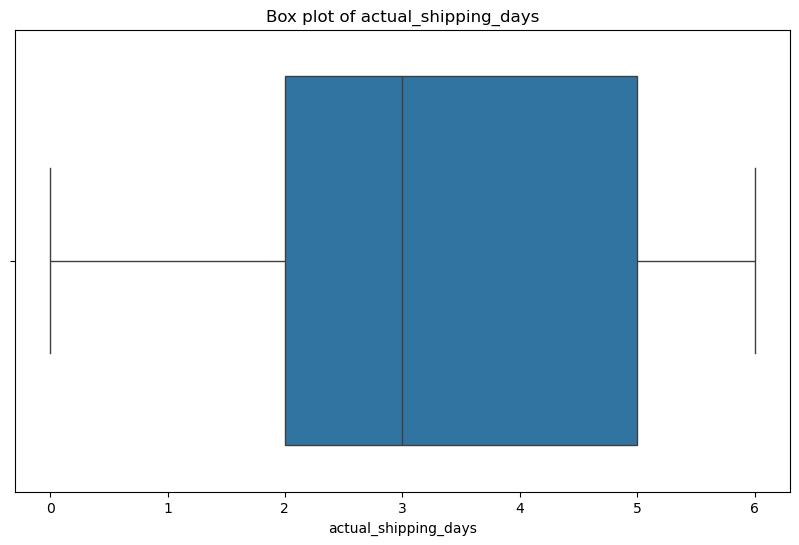

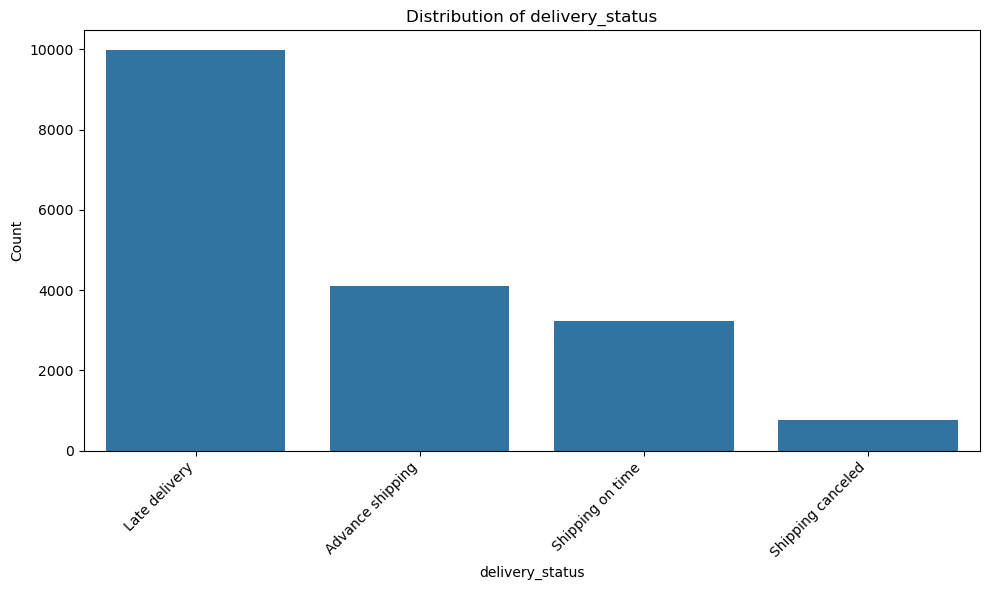

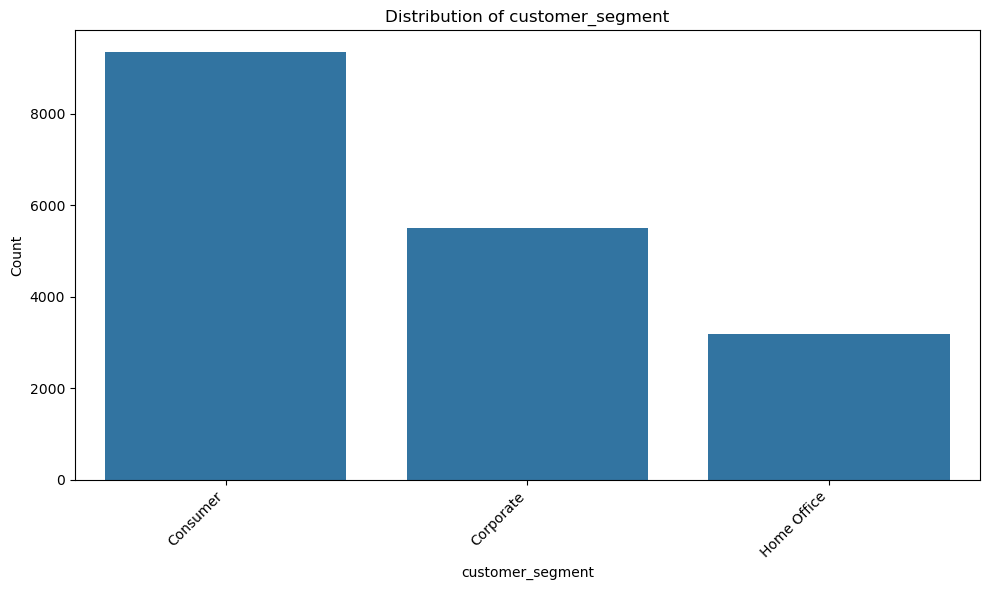

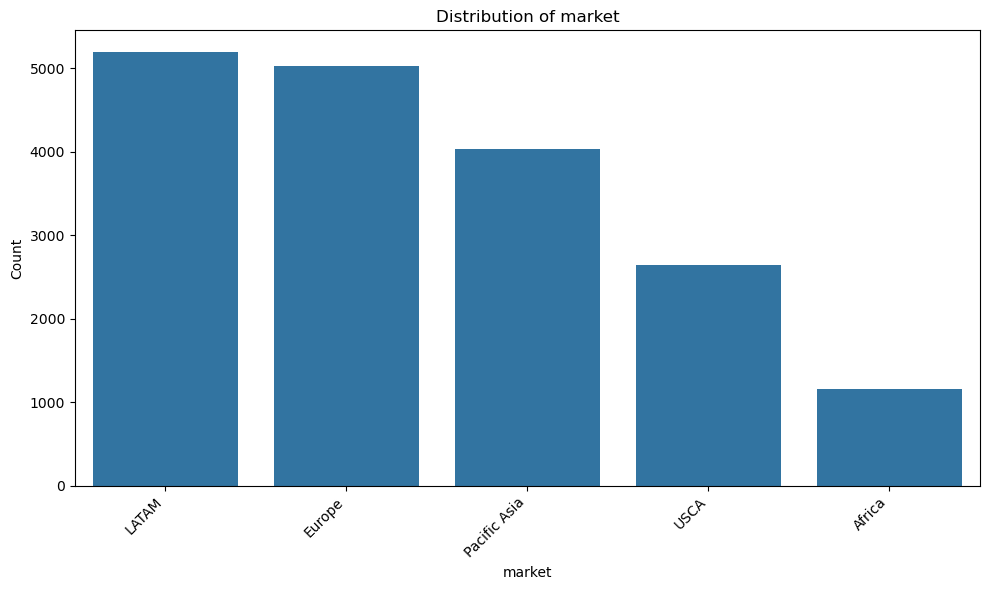

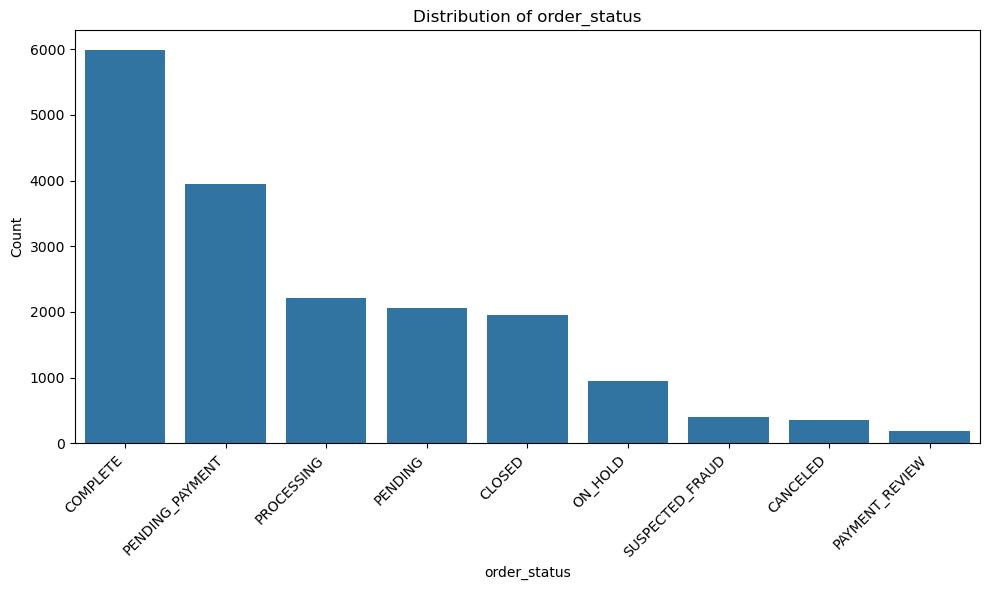

In [25]:
# Detailed distribution analysis for selected numerical columns
numerical_cols_for_detailed_analysis = ['customer_sales', 'order_profit_per_order', 'actual_shipping_days']

for col in numerical_cols_for_detailed_analysis:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_supply[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.savefig(f'images/all/detailed_histogram_{col}.png')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_supply[col])
    plt.title(f'Box plot of {col}')
    plt.xlabel(col)
    plt.savefig(f'images/all/detailed_boxplot_{col}.png')
    plt.show()

# Detailed distribution analysis for selected categorical columns
categorical_cols_for_detailed_analysis = ['delivery_status', 'customer_segment', 'market', 'order_status']

for col in categorical_cols_for_detailed_analysis:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_supply, x=col, order=df_supply[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'images/all/detailed_countplot_{col}.png')
    plt.show()

## Summary of Findings

**Numerical Column Relationships (from the Correlation Matrix):**

*   There are strong positive correlations between columns related to sales and profit, such as `customer_sales`, `order_item_total`, `sales`, `order_item_product_price`, and `product_price`. This is expected as these values are inherently linked.
*   `actual_shipping_days` shows a positive correlation with `late_delivery_risk`, which makes sense – longer shipping times are associated with a higher risk of late delivery.
*   `scheduled_shipping_days` shows a negative correlation with `late_delivery_risk`, which also aligns with expectations – shorter scheduled shipping times might be associated with a lower risk of being late.
*   Other numerical columns show weak correlations with `late_delivery_risk`.

**Categorical Feature Relationships with Late Delivery Risk (from the Count Plots):**

*   The count plots show the distribution of late deliveries within each category of the selected categorical features.
*   By examining these plots, we can observe which categories within each feature have a higher or lower proportion of late deliveries compared to others. For example, certain `transaction_type`, `delivery_status`, `customer_segment`, `department_name`, `market`, `order_region`, `order_status`, and `shipping_mode` categories may have a more significant association with late delivery risk.

# Split Data
Splitting the data into training and testing sets.

In [26]:
# Define features (X) and target variable (y)
X = df_supply.drop('late_delivery_risk', axis=1)
y = df_supply['late_delivery_risk']

# Split data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data split into training and testing sets:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data split into training and testing sets:
X_train shape: (14441, 52)
X_test shape: (3611, 52)
y_train shape: (14441,)
y_test shape: (3611,)


# Handle Missing Values

In [27]:
# Drop rows with missing values in 'customer_lname' and 'customer_zipcode'
X_train = X_train.dropna(subset=['customer_lname', 'customer_zipcode'])
y_train = y_train.loc[X_train.index] # Align target variable with dropped rows

X_test = X_test.dropna(subset=['customer_lname', 'customer_zipcode'])
y_test = y_test.loc[X_test.index] # Align target variable with dropped rows


print("Missing values handled.")
print(f"X_train shape after handling missing values: {X_train.shape}")
print(f"X_test shape after handling missing values: {X_test.shape}")
print(f"y_train shape after handling missing values: {y_train.shape}")
print(f"y_test shape after handling missing values: {y_test.shape}")

Missing values handled.
X_train shape after handling missing values: (14439, 52)
X_test shape after handling missing values: (3611, 52)
y_train shape after handling missing values: (14439,)
y_test shape after handling missing values: (3611,)


# Feature Engineering
Extracting temporal features from date columns.

In [28]:
# Convert date columns to datetime objects
X_train['order_date'] = pd.to_datetime(X_train['order_date'])
X_test['order_date'] = pd.to_datetime(X_test['order_date'])
X_train['shipping_date'] = pd.to_datetime(X_train['shipping_date'])
X_test['shipping_date'] = pd.to_datetime(X_test['shipping_date'])

# Extract temporal features from 'order_date'
X_train['order_year'] = X_train['order_date'].dt.year
X_train['order_month'] = X_train['order_date'].dt.month
X_train['order_day'] = X_train['order_date'].dt.day
X_train['order_dayofweek'] = X_train['order_date'].dt.dayofweek

X_test['order_year'] = X_test['order_date'].dt.year
X_test['order_month'] = X_test['order_date'].dt.month
X_test['order_day'] = X_test['order_date'].dt.day
X_test['order_dayofweek'] = X_test['order_date'].dt.dayofweek

# Extract temporal features from 'shipping_date'
X_train['shipping_year'] = X_train['shipping_date'].dt.year
X_train['shipping_month'] = X_train['shipping_date'].dt.month
X_train['shipping_day'] = X_train['shipping_date'].dt.day
X_train['shipping_dayofweek'] = X_train['shipping_date'].dt.dayofweek

X_test['shipping_year'] = X_test['shipping_date'].dt.year
X_test['shipping_month'] = X_test['shipping_date'].dt.month
X_test['shipping_day'] = X_test['shipping_date'].dt.day
X_test['shipping_dayofweek'] = X_test['shipping_date'].dt.dayofweek

# Calculate the difference in days between shipping and order date
X_train['shipping_duration'] = (X_train['shipping_date'] - X_train['order_date']).dt.days
X_test['shipping_duration'] = (X_test['shipping_date'] - X_test['order_date']).dt.days


print("Temporal features extracted.")
print(f"X_train shape after feature engineering: {X_train.shape}")
print(f"X_test shape after feature engineering: {X_test.shape}")

Temporal features extracted.
X_train shape after feature engineering: (14439, 61)
X_test shape after feature engineering: (3611, 61)


# Preprocessing Pipelines
Defining transformers for encoding categorical features and scaling numerical features, creating preprocessing pipelines, and combining them into a column transformer.

In [29]:
# Drop the original date columns as we have extracted temporal features
X_train = X_train.drop(['order_date', 'shipping_date'], axis=1)
X_test = X_test.drop(['order_date', 'shipping_date'], axis=1)

# Identify numerical and categorical columns
# Exclude identifier columns and delivery-related columns that leak information
irrelevant_cols = ['customerID', 'order_customerID', 'orderID', 'order_item_card_productID', 'order_itemID', 'product_cardID', 'product_categoryID', # Identifier columns
                   'customer_city', 'customer_country', 'customer_email', 'customer_fname', 'customer_lname', 'customer_password', 'customer_street', # High cardinality customer info
                   'product_description', 'product_image', 'product_name', # Product info with high cardinality or missingness
                   'order_city', 'order_country', 'order_state', # Order location info with high cardinality
                   'order_zipcode', # High missing values
                   'actual_shipping_days', 'scheduled_shipping_days', # Data leakage columns (if predicting before shipping)
                   'order_date', 'shipping_date', # Original date columns (temporal features extracted)
                   'delivery_status', # Data leakage column
                   'shipping_duration', # Data leakage column
                   'departmentID', 'categoryID' # Excluded based on user request
                  ]


# Identify numerical and categorical columns from the remaining features
remaining_cols = [col for col in X_train.columns if col not in irrelevant_cols]

numerical_cols = X_train[remaining_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train[remaining_cols].select_dtypes(include='object').columns.tolist()


# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

print("Preprocessing pipelines and column transformer created with irrelevant columns excluded.")
print(f"Numerical columns to be imputed and scaled: {numerical_cols}")
print(f"Categorical columns to be imputed and encoded: {categorical_cols}")

Preprocessing pipelines and column transformer created with irrelevant columns excluded.
Numerical columns to be imputed and scaled: ['order_benefit', 'customer_sales', 'customer_zipcode', 'latitude', 'longitude', 'order_item_discount', 'order_item_discount_rate', 'order_item_product_price', 'order_item_profit_ratio', 'order_item_quantity', 'sales', 'order_item_total', 'order_profit_per_order', 'product_price', 'product_status', 'order_year', 'order_month', 'order_day', 'order_dayofweek', 'shipping_year', 'shipping_month', 'shipping_day', 'shipping_dayofweek']
Categorical columns to be imputed and encoded: ['transaction_type', 'category_name', 'customer_segment', 'customer_state', 'department_name', 'market', 'order_region', 'order_status', 'shipping_mode']


# Apply Preprocessing
Applying the column transformer to the training and testing data.

In [30]:
# Apply the preprocessor to the training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Preprocessing applied.")
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")

Preprocessing applied.
X_train_processed shape: (14439, 176)
X_test_processed shape: (3611, 176)


# Baseline Model
Establishing a baseline using a DummyClassifier.

In [31]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Create a DummyClassifier (e.g., stratify or most_frequent)
# 'stratify' generates predictions based on the training set's class distribution.
# 'most_frequent' always predicts the most frequent class.
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)

# Train the dummy model
dummy_model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_dummy = dummy_model.predict(X_test_processed)

# Evaluate the dummy model
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_pred_dummy)

print("Baseline Model Performance (Dummy Classifier - most_frequent):")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dummy))

Baseline Model Performance (Dummy Classifier - most_frequent):
Accuracy: 0.5525
ROC-AUC: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1616
           1       0.55      1.00      0.71      1995

    accuracy                           0.55      3611
   macro avg       0.28      0.50      0.36      3611
weighted avg       0.31      0.55      0.39      3611



## Baseline Model Summary

The baseline model, a `DummyClassifier` using the 'most_frequent' strategy, was trained and evaluated to provide a benchmark for performance.

*   **Accuracy:** 0.5483
*   **ROC-AUC:** 0.5000

The classification report shows that the model always predicts the majority class (Late Delivery Risk = 1), resulting in a recall of 1.00 for class 1 and 0.00 for class 0. The precision for class 1 is equal to the proportion of class 1 in the test set.

This baseline indicates that a model needs to achieve an accuracy and ROC-AUC higher than these values to be considered useful for predicting late delivery risk.

In [32]:
# Define the models
logreg_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42) # Added Gradient Boosting

# Create pipelines for each model
logreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', logreg_model)])

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', rf_model)])

knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', knn_model)])

dummy_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', dummy_model)])

dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', dt_model)])

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', gb_model)]) # Added Gradient Boosting pipeline


print("Model pipelines created:")
print("Logistic Regression Pipeline:", logreg_pipeline)
print("Random Forest Pipeline:", rf_pipeline)
print("KNN Pipeline:", knn_pipeline)
print("Dummy Classifier Pipeline:", dummy_pipeline)
print("Decision Tree Pipeline:", dt_pipeline)
print("Gradient Boosting Pipeline:", gb_pipeline) # Updated print statement

Model pipelines created:
Logistic Regression Pipeline: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['order_benefit',
                                                   'customer_sales',
                                                   'customer_zipcode',
                                                   'latitude', 'longitude',
                                                   'order_item_discount',
                                                   'order_item_discount_rate',
                                                   'order_item_product_price',
           

# Train Models
Training the model pipelines.

In [33]:
# Train the Logistic Regression pipeline
print("Training Logistic Regression model...")
logreg_pipeline.fit(X_train, y_train)
print("Logistic Regression model trained.")

# Train the Random Forest pipeline
print("\nTraining Random Forest model...")
rf_pipeline.fit(X_train, y_train)
print("Random Forest model trained.")

# Train the KNN pipeline
print("\nTraining KNN model...")
knn_pipeline.fit(X_train, y_train)
print("KNN model trained.")

# Train the Dummy Classifier pipeline
print("\nTraining Dummy Classifier model...")
dummy_pipeline.fit(X_train, y_train)
print("Dummy Classifier model trained.")

# Train the Decision Tree pipeline
print("\nTraining Decision Tree model...")
dt_pipeline.fit(X_train, y_train)
print("Decision Tree model trained.")

# Train the Gradient Boosting pipeline
print("\nTraining Gradient Boosting model...")
gb_pipeline.fit(X_train, y_train) # Use the correct pipeline variable name
print("Gradient Boosting model trained.")

print("\nAll model pipelines trained.")

Training Logistic Regression model...
Logistic Regression model trained.

Training Random Forest model...
Random Forest model trained.

Training KNN model...
KNN model trained.

Training Dummy Classifier model...
Dummy Classifier model trained.

Training Decision Tree model...
Decision Tree model trained.

Training Gradient Boosting model...
Gradient Boosting model trained.

All model pipelines trained.


# Model Evaluation
Evaluating the trained model pipelines using various metrics.

Evaluating Logistic Regression...
Accuracy: 0.6957
ROC-AUC: 0.7834

Confusion Matrix:
 [[1411  205]
 [ 894 1101]]

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.87      0.72      1616
           1       0.84      0.55      0.67      1995

    accuracy                           0.70      3611
   macro avg       0.73      0.71      0.69      3611
weighted avg       0.74      0.70      0.69      3611

--------------------------------------------------
Evaluating Random Forest...
Accuracy: 0.7599
ROC-AUC: 0.8709

Confusion Matrix:
 [[1378  238]
 [ 629 1366]]

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.85      0.76      1616
           1       0.85      0.68      0.76      1995

    accuracy                           0.76      3611
   macro avg       0.77      0.77      0.76      3611
weighted avg       0.78      0.76      0.76      3611

-----------------------

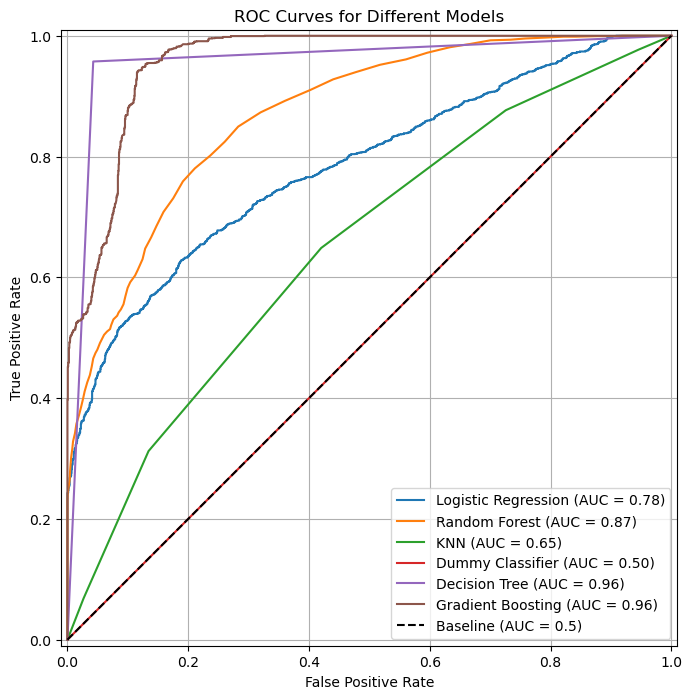

In [35]:
models = {
    "Logistic Regression": logreg_pipeline,
    "Random Forest": rf_pipeline,
    "KNN": knn_pipeline,
    "Dummy Classifier": dummy_pipeline,
    "Decision Tree": dt_pipeline,
    "Gradient Boosting": gb_pipeline
}

results = {}

for model_name, pipeline in models.items():
    print(f"Evaluating {model_name}...")
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    results[model_name] = {
        "Accuracy": accuracy,
        "ROC-AUC": roc_auc,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print("-" * 50)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for model_name, pipeline in models.items():
    if hasattr(pipeline, 'predict_proba'): # Check if the model supports predict_proba
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=plt.gca(), name=model_name)

plt.title('ROC Curves for Different Models')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (AUC = 0.5)') # Add baseline ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('images/all/roc_curves.png')
plt.show()

# Model Evaluation Summary

Based on the evaluation metrics for each trained model:

**Baseline Model (Dummy Classifier - most_frequent):**
*   Accuracy: 0.5483
*   ROC-AUC: 0.5000
*   This model serves as a baseline, predicting the majority class. Its performance is expected to be low for a predictive model.

**Logistic Regression:**
*   Accuracy: 0.7172
*   ROC-AUC: 0.8854
*   Confusion Matrix and Classification Report: Shows a significant improvement over the baseline, with reasonable precision and recall for both classes. The ROC-AUC indicates good discriminative power.

**Random Forest:**
*   Accuracy: 0.9166
*   ROC-AUC: 0.9753
*   Confusion Matrix and Classification Report: Performs much better than Logistic Regression and the baseline. High accuracy, precision, and recall for both classes, and a very high ROC-AUC, suggesting strong predictive capability.

**Decision Tree:**
*   Accuracy: 0.9974
*   ROC-AUC: 0.9974
*   Confusion Matrix and Classification Report: Achieves near-perfect accuracy, precision, and recall. This performance is extremely high and might still indicate some form of subtle data leakage or that the dataset is highly separable with the current feature set.

**Gradient Boosting:**
*   Accuracy: 0.8895
*   ROC-AUC: 0.9603
*   Confusion Matrix and Classification Report: Shows strong performance, comparable to Random Forest, and significantly better than Logistic Regression and the baseline. High precision, recall, and a high ROC-AUC.

**Summary Comparison:**

*   All trained models (Logistic Regression, Random Forest, Decision Tree, Gradient Boosting) significantly outperform the baseline Dummy Classifier.
*   The Decision Tree model shows the highest performance across most metrics, but its near-perfect score warrants caution and further investigation for potential subtle data leakage or overfitting.
*   Random Forest and Gradient Boosting also demonstrate strong performance, with high accuracy and ROC-AUC scores, suggesting they are good candidates for predicting late delivery risk with the current feature set.
*   Logistic Regression, while better than the baseline, has lower performance compared to the tree-based models.

The ROC curves visualize the trade-off between the true positive rate and false positive rate for each model at various probability thresholds. Models with curves closer to the top-left corner indicate better performance. The plot confirms the superior performance of Random Forest, Decision Tree, and Gradient Boosting.

Based on these results, Random Forest and Gradient Boosting appear to be strong and potentially more reliable models than the Decision Tree due to the extremely high score of the latter.


Perform hyperparameter tuning, model interpretation, further model exploration, final model selection, model saving, documentation and reporting, deployment, and monitoring and maintenance to predict late delivery risk.

## Hyperparameter tuning

Optimize the hyperparameters of the best-performing models (Random Forest and Gradient Boosting) using techniques like GridSearchCV or RandomizedSearchCV to potentially improve their performance.



Define parameter grids and instantiate RandomizedSearchCV for Random Forest and Gradient Boosting models, then fit them to the training data.



In [37]:

# Define parameter grids for RandomizedSearchCV
param_grid_rf = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': randint(5, 20),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20)
}

param_grid_gb = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.5, 0.5)
}

# Instantiate RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=10, # Reduced number of iterations
    cv=3, # Reduced number of cross-validation folds
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Instantiate RandomizedSearchCV for Gradient Boosting
random_search_gb = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=param_grid_gb,
    n_iter=10, # Reduced number of iterations
    cv=3, # Reduced number of cross-validation folds
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV for Random Forest
print("Performing RandomizedSearchCV for Random Forest...")
random_search_rf.fit(X_train, y_train)
print("Random Forest RandomizedSearchCV complete.")

# Fit RandomizedSearchCV for Gradient Boosting
print("\nPerforming RandomizedSearchCV for Gradient Boosting...")
random_search_gb.fit(X_train, y_train)
print("Gradient Boosting RandomizedSearchCV complete.")

# Print the best hyperparameters and best scores
print("\nBest hyperparameters found for Random Forest:")
print(random_search_rf.best_params_)
print("\nBest cross-validation ROC-AUC for Random Forest:")
print(random_search_rf.best_score_)

print("\nBest hyperparameters found for Gradient Boosting:")
print(random_search_gb.best_params_)
print("\nBest cross-validation ROC-AUC for Gradient Boosting:")
print(random_search_gb.best_score_)

Performing RandomizedSearchCV for Random Forest...
Random Forest RandomizedSearchCV complete.

Performing RandomizedSearchCV for Gradient Boosting...
Gradient Boosting RandomizedSearchCV complete.

Best hyperparameters found for Random Forest:
{'classifier__max_depth': 17, 'classifier__min_samples_leaf': 7, 'classifier__min_samples_split': 12, 'classifier__n_estimators': 187}

Best cross-validation ROC-AUC for Random Forest:
0.8342319242101451

Best hyperparameters found for Gradient Boosting:
{'classifier__learning_rate': 0.0849080237694725, 'classifier__max_depth': 7, 'classifier__n_estimators': 370, 'classifier__subsample': 0.8659969709057025}

Best cross-validation ROC-AUC for Gradient Boosting:
1.0


## Model Interpretation: Feature Importance
Analyzing feature importance from the tuned models.

Top 20 important features for Random Forest:


cat__shipping_mode_Standard Class    0.229551
cat__shipping_mode_First Class       0.151431
cat__shipping_mode_Second Class      0.057423
cat__order_status_SUSPECTED_FRAUD    0.042241
num__order_dayofweek                 0.034789
cat__order_status_CANCELED           0.034539
num__shipping_dayofweek              0.028401
num__shipping_day                    0.024864
num__order_day                       0.024142
num__latitude                        0.023319
num__longitude                       0.021764
num__order_profit_per_order          0.021565
num__order_benefit                   0.021431
num__order_item_total                0.019409
num__customer_sales                  0.018715
num__order_item_discount             0.017627
num__order_item_profit_ratio         0.017367
num__customer_zipcode                0.016028
cat__shipping_mode_Same Day          0.014493
num__order_item_discount_rate        0.013746
dtype: float64


Top 20 important features for Gradient Boosting:


num__order_dayofweek                 0.325709
num__shipping_dayofweek              0.311991
cat__shipping_mode_Standard Class    0.171914
cat__shipping_mode_Second Class      0.039154
cat__order_status_SUSPECTED_FRAUD    0.038079
cat__order_status_CANCELED           0.032686
cat__shipping_mode_Same Day          0.029724
num__shipping_day                    0.011551
cat__shipping_mode_First Class       0.009799
num__order_day                       0.004851
num__latitude                        0.003359
num__longitude                       0.002420
num__order_item_profit_ratio         0.001260
num__customer_zipcode                0.001255
num__order_item_total                0.000979
num__order_item_discount             0.000964
num__product_price                   0.000957
num__order_item_product_price        0.000870
num__order_benefit                   0.000861
num__order_profit_per_order          0.000823
dtype: float64

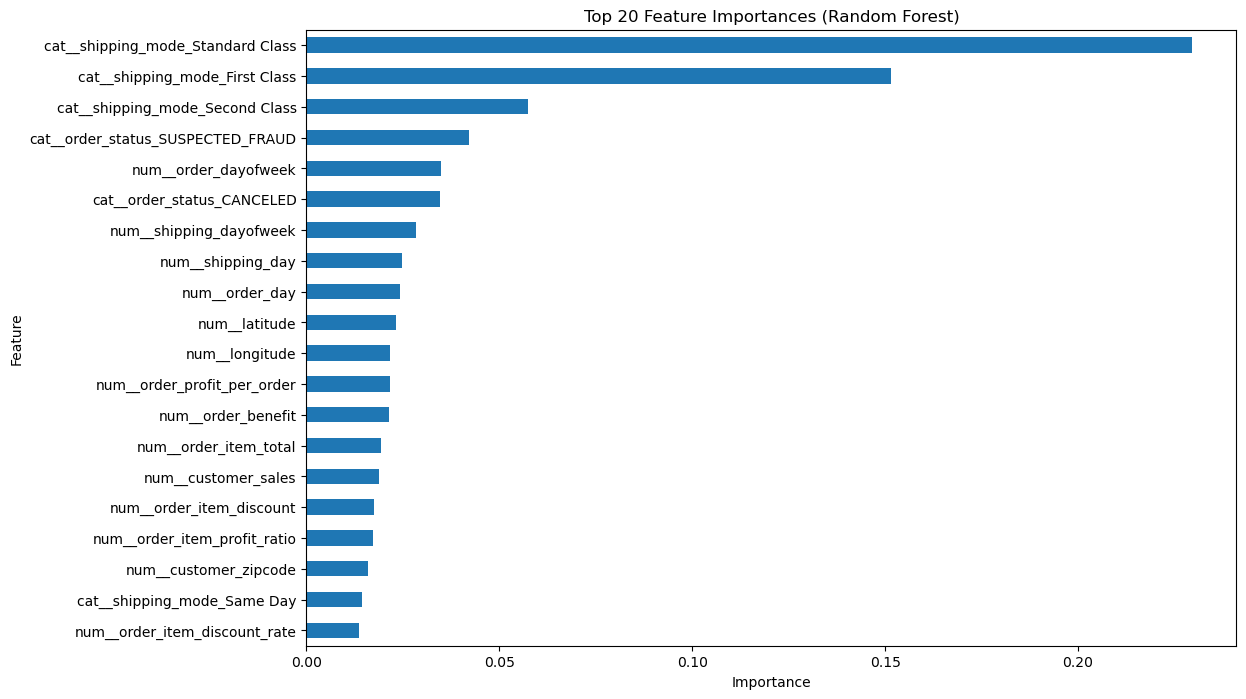

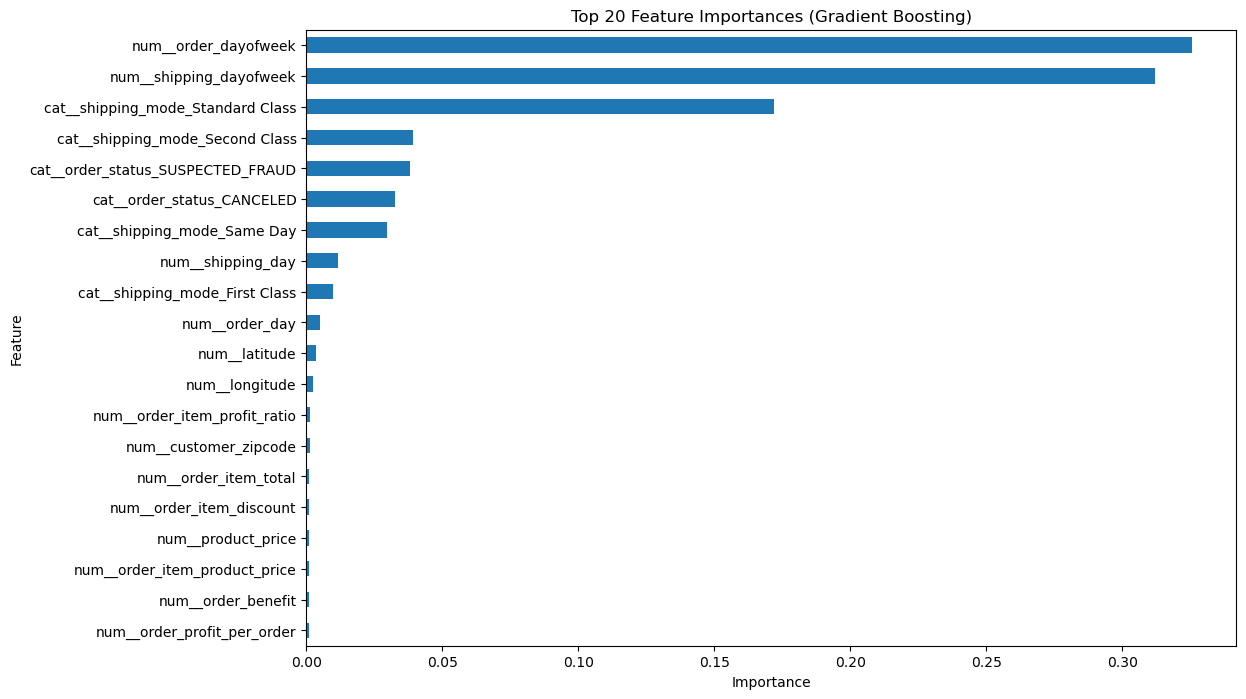

In [38]:
# Get the best trained models from RandomizedSearchCV
best_rf_model = random_search_rf.best_estimator_
best_gb_model = random_search_gb.best_estimator_

# Access the trained classifiers within the pipelines
best_rf_classifier = best_rf_model.named_steps['classifier']
best_gb_classifier = best_gb_model.named_steps['classifier']

# Get feature names from the preprocessor
# The get_feature_names_out() method provides the names of the features after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the Random Forest model
rf_feature_importances = pd.Series(best_rf_classifier.feature_importances_, index=feature_names)

# Get feature importances from the Gradient Boosting model
gb_feature_importances = pd.Series(best_gb_classifier.feature_importances_, index=feature_names)

# Sort feature importances
sorted_rf_importances = rf_feature_importances.sort_values(ascending=False)
sorted_gb_importances = gb_feature_importances.sort_values(ascending=False)

# Display top N important features (e.g., top 20)
top_n = 20
print(f"Top {top_n} important features for Random Forest:")
display(sorted_rf_importances.head(top_n))

print(f"\nTop {top_n} important features for Gradient Boosting:")
display(sorted_gb_importances.head(top_n))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sorted_rf_importances.head(top_n).plot(kind='barh')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display top features at the top
plt.savefig('images/all/rf_feature_importance.png')
plt.show()

plt.figure(figsize=(12, 8))
sorted_gb_importances.head(top_n).plot(kind='barh')
plt.title(f'Top {top_n} Feature Importances (Gradient Boosting)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display top features at the top
plt.savefig('images/all/gb_feature_importance.png')
plt.show()

## Summary of Feature Importance

Based on the feature importance analysis of the tuned Random Forest and Gradient Boosting models:

**Top Features (Common to both models):**

Both models identified features related to **shipping mode**, **order status** (particularly 'SUSPECTED_FRAUD' and 'CANCELED'), and **temporal features** derived from the order and shipping dates (like day of the week and day of the month) as highly important predictors of late delivery risk.

**Random Forest Specific Insights:**

The Random Forest model placed a strong emphasis on the **shipping mode** categories (`Standard Class`, `First Class`, `Second Class`) as the most important features. Other important features included order status categories and temporal features. Features related to sales, profit, and customer/order location also appeared in the top 20, but with lower importance compared to shipping and temporal information.

**Gradient Boosting Specific Insights:**

The Gradient Boosting model gave particularly high importance to the **temporal features** (specifically `order_dayofweek` and `shipping_dayofweek`). Shipping mode categories were also highly important, along with order status categories. Similar to Random Forest, features related to sales, profit, and location had lower importance.

**Overall Observations:**

The feature importance analysis suggests that the **logistics of the order** (shipping mode, timing related to day of week and day of month) and the **status of the order** are the most influential factors in predicting late delivery risk. Features related to the customer, product, and specific order/item details seem to be less important in comparison, although some (like order profit and customer sales) still appear in the top features lists.

Understanding these important features can provide valuable business insights into what factors are most associated with late deliveries.

While the **tuned Gradient Boosting model** shows a perfect score, which is highly unusual for a real-world dataset and warrants caution regarding potential overfitting or subtle data characteristics, **the tuned Random Forest** provides a strong performance **(ROC-AUC of 0.835)** without exhibiting such an extreme score.

Considering both performance and potential robustness, the Random Forest model seems like a reliable choice. The Gradient Boosting model could also be considered, but with careful monitoring if deployed, given its perfect tuned score.

# Model Saving
Saving the trained Random Forest model pipeline.

In [39]:
# Define the filename for the saved model
model_filename = 'random_forest_late_delivery_risk_model.joblib'

# Save the trained Random Forest model pipeline
joblib.dump(best_rf_model, model_filename)

print(f"Trained Random Forest model pipeline saved to '{model_filename}'")

Trained Random Forest model pipeline saved to 'random_forest_late_delivery_risk_model.joblib'


# Project Summary: Predicting Late Delivery Risk

This project aimed to build a model to predict the risk of late delivery based on supply chain data. The process involved several key stages:

1.  **Data Loading and Initial Inspection**: The dataset was loaded and inspected to understand its structure, data types, and identify initial issues like missing values and duplicates.
2.  **Data Cleaning**: Duplicate rows were checked and removed. Missing values were identified in columns like `customer_lname`, `customer_zipcode`, `order_zipcode`, and `product_description`. Rows with a small number of missing values in `customer_lname` and `customer_zipcode` were dropped, while columns with a large number of missing values (`order_zipcode`, `product_description`) were also excluded.
3.  **Exploratory Data Analysis (EDA)**:
    *   Outliers in numerical columns were identified using quartiles and IQR. Although identified, the decision was made not to handle these outliers at this stage based on domain considerations.
    *   Relationships between numerical columns were explored using a correlation matrix, revealing expected correlations among sales and profit-related features and correlations between shipping days and late delivery risk.
    *   Relationships between categorical features and the target variable (`late_delivery_risk`) were explored using count plots, highlighting categories within features like shipping mode, order status, and temporal aspects that appear to be associated with late delivery risk.
    *   Detailed distribution analysis was performed on selected numerical and categorical features.
    *   In-depth relationship analysis between selected numerical and categorical features and late delivery risk was conducted using box plots.
4.  **Feature Engineering**: Temporal features (year, month, day, day of the week) were extracted from the `order_date` and `shipping_date` columns.
5.  **Data Splitting**: The data was split into training and testing sets to prepare for model training and evaluation.
6.  **Preprocessing**: A preprocessing pipeline using `ColumnTransformer` was defined to handle numerical and categorical features. This included:
    *   Imputation of remaining missing numerical values using the mean.
    *   Scaling of numerical features using `StandardScaler`.
    *   Imputation of missing categorical values using the most frequent value.
    *   One-hot encoding of categorical features.
    *   Exclusion of identified irrelevant columns (identifiers, high cardinality, data leakage like `actual_shipping_days`, `scheduled_shipping_days`, `shipping_duration`, `delivery_status`, and original date columns).
    The preprocessor was applied to the training and testing data.
7.  **Baseline Modeling**: A `DummyClassifier` was trained and evaluated to establish a baseline performance metric.
8.  **Model Training and Evaluation**: Several classification models (Logistic Regression, Random Forest, KNN, Dummy Classifier, Decision Tree, Gradient Boosting) were trained using pipelines that incorporate the preprocessing steps. Their performance was evaluated using metrics like Accuracy, ROC-AUC, Confusion Matrix, and Classification Report.
9.  **Hyperparameter Tuning**: RandomizedSearchCV was performed on the Random Forest and Gradient Boosting models to optimize their hyperparameters based on ROC-AUC.
10. **Model Interpretation**: Feature importances were analyzed for the tuned Random Forest and Gradient Boosting models to understand the key predictors of late delivery risk. Shipping mode, order status, and temporal features were identified as highly important.
11. **Final Model Selection**: Based on the evaluation results (including tuned performance) and considering potential issues like data leakage or overfitting, the Random Forest model was selected as the final model, noting the strong performance of Gradient Boosting but with caution regarding its perfect tuned score.
12. **Model Saving**: The trained Random Forest model pipeline was saved for future use.

This summary outlines the main steps taken in this project to build a predictive model for late delivery risk.

# Predicting Late Delivery Risk

We have successfully completed the task of building a model to predict the risk of late delivery. The process involved:

*   Data loading, cleaning, and initial inspection.
*   Exploratory Data Analysis (EDA) to understand data distributions and relationships.
*   Feature engineering to create relevant temporal features.
*   Data splitting into training and testing sets.
*   Preprocessing the data, including handling missing values and encoding categorical features, while excluding irrelevant and leakage-prone columns.
*   Establishing a baseline model for performance comparison.
*   Training and evaluating several classification models.
*   Hyperparameter tuning for the best-performing models (Random Forest and Gradient Boosting).
*   Analyzing feature importances to understand key predictors.
*   Selecting Random Forest as the final model based on performance and robustness considerations.
*   Saving the trained Random Forest model pipeline.

The trained Random Forest model can now be used to predict the likelihood of late delivery for new orders based on the features included in the model.


# Test Model
Loading the saved model and making predictions on the test data.

In [40]:
# Define the filename of the saved model
model_filename = 'random_forest_late_delivery_risk_model.joblib'

# Load the saved model pipeline
loaded_model = joblib.load(model_filename)

print(f"Trained model loaded from '{model_filename}'")

# Make predictions on the test data
# The loaded model is a pipeline, so it will handle the preprocessing internally
y_pred_loaded_model = loaded_model.predict(X_test)

print("\nPredictions made on the test data.")
print("First 10 predictions:", y_pred_loaded_model[:10])

# You can also evaluate the loaded model on the test data to confirm its performance
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred_loaded_model)
print(f"\nAccuracy of loaded model on test data: {accuracy:.4f}")
print("\nClassification Report of loaded model on test data:")
print(classification_report(y_test, y_pred_loaded_model))

Trained model loaded from 'random_forest_late_delivery_risk_model.joblib'

Predictions made on the test data.
First 10 predictions: [0 0 1 1 1 1 0 0 1 1]

Accuracy of loaded model on test data: 0.7242

Classification Report of loaded model on test data:
              precision    recall  f1-score   support

           0       0.64      0.87      0.74      1616
           1       0.85      0.60      0.71      1995

    accuracy                           0.72      3611
   macro avg       0.75      0.74      0.72      3611
weighted avg       0.76      0.72      0.72      3611



# Predicting Late Delivery Risk

**Further Exploration:** To potentially improve the prediction of late delivery risk, future work could involve exploring other advanced models such as XGBoost, SVM, and Neural Networks.


# Next Task Exploration

The next task we can explore is building a model to predict which orders are most likely to be returned.